In [5]:
!pip install sdv # install the synthetic data vault library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
import pandas as pd
# import torch.nn.functional as F


import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer,PowerTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data value libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libs
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# set random seed
seed= 1234

# set dimension of categorical embedding
cat_emb_dim= 2

# set number of neurons per layes
mlp_layers=[1024,1024,1024,1024]

# set non-linear activation function
activation='lrelu'

# set number of diffusion steps
diffusion_steps= 1000

# set diffusion stop and end betas
diffusion_beta_start= 1e-4
diffusion_beta_end= 0.02

# set diffusion scheduler
scheduler= 'exp'

# set number of training epochs
epochs= 500

# set the training batch size
batch_size= 512

# set the training learning rate
learning_rate= 1e-4

# set the device
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

beta_start=1e-4
beta_end=0.02

# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Data prepration

In [5]:
# define a preproces data function


from datetime import datetime
import calendar
import numpy as np
import pandas as pd
import random
import os
import numpy as np
import tensorflow as tf

# Set seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


def preprocess_data_czech(df):
    #df = pd.read_csv('tr_by_acct_w_age.csv')

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)
    #df["datetime"] = pd.to_datetime(df["datetime"])

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] =  df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    df["td"] = df[["account_id", "datetime"]].groupby("account_id").diff()
    df["td"] = df["td"].apply(lambda x: x.days)
    df["td"].fillna(0.0, inplace=True)


    # dtme - days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)


    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    # create tcode by concating fields in "cat_code_fields"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)

    df["tcode"] = tcode

    conditions = [
    (df['day'] >= 1) & (df['day'] <= 10),
    (df['day'] > 10) & (df['day'] <= 20),
    (df['day'] > 20) & (df['day'] <= 31)
      ]

    categories = ['first', 'middle', 'last']

    # Use numpy.select() to map the numbers to categories
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')


    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']

    # Use pd.cut() to convert ages to categorical groups
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    result = df.groupby('account_id')['datetime'].agg(['min', 'max'])
    result['duration'] = result['max'] - result['min']
    result_sorted = result.sort_values('duration', ascending=False)

    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount']/ LOG_AMOUNT_SCALE
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td']/TD_SCALE

    return df, LOG_AMOUNT_SCALE , TD_SCALE

In [6]:
real = pd.read_csv('tr_by_acct_w_age.csv')
real = real.sort_values(by = ["account_id", "date"])
raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(real)



all_real = raw_data[['account_id', 'tcode', 'datetime', 'amount', 'td', 'day', 'month', 'year']]
all_real['type'] = all_real['tcode'].str.split('__').str[0]
all_real['raw_amount'] = all_real.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_real_cf = all_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

/tmp/ipython-input-3939612794.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["td"].fillna(0.0, inplace=True)


## Model

In [ ]:
# import numpy as np
# from sklearn.preprocessing import (
#     MinMaxScaler, StandardScaler, RobustScaler,
#     QuantileTransformer, PowerTransformer,
#     PolynomialFeatures, KBinsDiscretizer, SplineTransformer
# )
# from scipy import stats

In [ ]:
# class RobustQuantileTransformer:
#     """Combined robust and quantile transformation"""

#     def __init__(self, quantile_range=(5, 95), output_distribution='normal'):
#         self.quantile_range = quantile_range
#         self.output_distribution = output_distribution
#         self.robust_scaler = RobustScaler(quantile_range=quantile_range)
#         self.quantile_transformer = QuantileTransformer(
#             output_distribution=output_distribution,
#             random_state=42
#         )

#     def fit(self, X):
#         # First apply robust scaling to handle outliers
#         X_robust = self.robust_scaler.fit_transform(X)
#         # Then apply quantile transformation
#         self.quantile_transformer.fit(X_robust)
#         return self

#     def transform(self, X):
#         X_robust = self.robust_scaler.transform(X)
#         return self.quantile_transformer.transform(X_robust)

#     def inverse_transform(self, X):
#         X_inv_quantile = self.quantile_transformer.inverse_transform(X)
#         return self.robust_scaler.inverse_transform(X_inv_quantile)

In [ ]:
# from scipy.stats import norm, rankdata
# import numpy as np

# class CustomQuantileGaussianTransformer:
#     def fit(self, X):
#         X = np.asarray(X)
#         self.n_samples_, self.n_features_ = X.shape
#         self.sorted_X_ = []
#         for i in range(self.n_features_):
#             col = X[:, i]
#             self.sorted_X_.append(np.sort(col))
#         return self

#     def transform(self, X):
#         X = np.asarray(X)
#         X_out = np.zeros_like(X, dtype=float)
#         for i in range(X.shape[1]):
#             ranks = rankdata(X[:, i], method='average') / (len(X[:, i]) + 1)
#             X_out[:, i] = norm.ppf(ranks)
#         return X_out

#     def inverse_transform(self, X_transformed):
#         X_transformed = np.asarray(X_transformed)
#         X_out = np.zeros_like(X_transformed, dtype=float)
#         for i in range(X_transformed.shape[1]):
#             uniform_vals = norm.cdf(X_transformed[:, i])
#             percentiles = np.linspace(0, 1, self.n_samples_, endpoint=False) + 0.5 / self.n_samples_
#             X_out[:, i] = np.interp(uniform_vals, percentiles, self.sorted_X_[i])
#         return X_out


In [ ]:
x = torch.empty(n_sequences, seq_len, n_num_features)
y = torch.randn_like(x)  # ✅ Works because x is a tensor

# torch.randn_like((n_sequences, seq_len, n_num_features))

NameError: name 'seq_len' is not defined

## Model with normal distribution

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

# import pandas as pd
# import numpy as np
# import math
# import random
# import os
# from datetime import datetime, timedelta
# import calendar
# from tqdm import tqdm
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# # Quality evaluation imports
# from sdv.metadata import SingleTableMetadata
# from sdv import evaluation

# # =============================================================================
# # CONFIGURATION
# # =============================================================================
# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 512
# learning_rate = 2e-4
# n_sequences = 5000

# # =============================================================================
# # STUDENT-T DISTRIBUTION DDPM DIFFUSER (Fixed)
# # =============================================================================
# class NormalDDPMDiffuser(object):
#     def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
#         self.total_steps = total_steps
#         self.device = device
#         self.df = df

#         # Determine noise scheduler scale
#         scale = 1000 / total_steps

#         # Scale beta start and end
#         beta_start = scale * beta_start
#         beta_end = scale * beta_end

#         # Create linear schedule for betas
#         betas = torch.linspace(beta_start, beta_end, self.total_steps)

#         # Determine linear noise schedule alphas
#         self.alphas = 1.0 - betas
#         self.betas = betas.to(device)
#         self.alphas = self.alphas.to(device)
#         self.alphas_hat = torch.cumprod(self.alphas, dim=0).to(device)

#     def sample_random_timesteps(self, n: int):
#         return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

#     def add_t_noise(self, x_num, t):
#         # Fix: Ensure proper device placement and tensor dimensions
#         sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None].to(self.device)
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None].to(self.device)

#         # Generate noise with same shape as input
#         noise_num = torch.randn_like(x_num).to(self.device)

#         # Add noise
#         x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

#         return x_noise_num, noise_num

#     def sample(self, model_out, z_norm, timesteps):
#         # Fix: Ensure proper tensor dimensions for sampling
#         sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None].to(self.device)
#         betas_t = self.betas[timesteps][:, None, None].to(self.device)
#         sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None].to(self.device)
#         epsilon_t = torch.sqrt(self.betas[timesteps])[:, None, None].to(self.device)

#         # Generate random noise
#         random_noise = torch.randn_like(z_norm).to(self.device)
#         random_noise[timesteps == 0] = 0.0

#         # Calculate model mean
#         model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

#         # Return denoised sample
#         z_norm = model_mean + (epsilon_t * random_noise)
#         return z_norm

# # =============================================================================
# # DATA PREPROCESSING (Fixed)
# # =============================================================================
# def preprocess_data_czech(df):
#     # Set seeds for reproducibility
#     random.seed(0)
#     np.random.seed(0)

#     czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
#     df["datetime"] = df["date"].apply(czech_date_parser)

#     df["month"] = df["datetime"].dt.month
#     df["day"] = df["datetime"].dt.day
#     df["dow"] = df["datetime"].dt.dayofweek
#     df["year"] = df["datetime"].dt.year
#     df["doy"] = df["datetime"].dt.dayofyear

#     # Sort by account_id and datetime before calculating time differences
#     df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

#     # Calculate time differences
#     df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

#     # Days till month end
#     df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

#     # Raw amount calculation
#     df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

#     # Transaction code creation
#     cat_code_fields = ['type', 'operation', 'k_symbol']
#     TCODE_SEP = "__"
#     tcode = df[cat_code_fields[0]].astype(str)
#     for ccf in cat_code_fields[1:]:
#         tcode += TCODE_SEP + df[ccf].astype(str)
#     df["tcode"] = tcode

#     # Day of month categories
#     conditions = [
#         (df['day'] >= 1) & (df['day'] <= 10),
#         (df['day'] > 10) & (df['day'] <= 20),
#         (df['day'] > 20) & (df['day'] <= 31)
#     ]
#     categories = ['first', 'middle', 'last']
#     df['DoM_cat'] = np.select(conditions, categories, default='unknown')

#     # Age group binning
#     bin_edges = [17, 30, 40, 50, 60, 81]
#     labels = ['18-30', '31-40', '41-50', '51-60', '61+']
#     df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
#     df['age_group'] = df['age_group'].astype('object')

#     # Log amount scaling
#     df['log_amount'] = np.log10(df['amount'] + 1)
#     LOG_AMOUNT_SCALE = df['log_amount'].std()
#     df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

#     # Time difference scaling
#     TD_SCALE = df['td'].std()
#     df['td_sc'] = df['td'] / TD_SCALE

#     return df

# # =============================================================================
# # DATASET (Fixed)
# # =============================================================================
# class TemporalSequentialDataset(Dataset):
#     def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
#         self.sequences = []
#         for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
#             account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
#             if len(account_data) >= min_seq_length:
#                 for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
#                     end_idx = min(start_idx + sequence_length, len(account_data))
#                     seq_data = account_data.iloc[start_idx:end_idx]

#                     # Pad sequences if they're shorter than sequence_length
#                     if len(seq_data) < sequence_length:
#                         # Pad with the last row repeated
#                         padding_needed = sequence_length - len(seq_data)
#                         last_row = seq_data.iloc[-1:].copy()
#                         padding = pd.concat([last_row] * padding_needed, ignore_index=True)
#                         seq_data = pd.concat([seq_data, padding], ignore_index=True)

#                     self.sequences.append({
#                         'cat_data': seq_data[cat_attrs].values,
#                         'num_data': seq_data[num_attrs].values
#                     })

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         seq = self.sequences[idx]
#         return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# # =============================================================================
# # MODEL (Fixed)
# # =============================================================================
# class TemporalLSTMSynthesizer(nn.Module):
#     def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
#         super().__init__()
#         self.n_cat_features = n_cat_features
#         self.n_num_features = n_num_features

#         self.cat_embeddings = nn.ModuleList([
#             nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
#         ])

#         total_input_dim = n_cat_features * cat_emb_dim + n_num_features

#         self.time_embed = nn.Sequential(
#             nn.Linear(64, hidden_dim),
#             nn.SiLU(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )

#         self.input_projection = nn.Linear(total_input_dim, hidden_dim)
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

#         self.cat_heads = nn.ModuleList([
#             nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
#         ])
#         self.num_head = nn.Linear(hidden_dim, n_num_features)

#     def embed_time(self, timesteps, dim_out=64):
#         half = dim_out // 2
#         freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
#         args = timesteps[:, None].float() * freqs[None]
#         return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

#     def forward(self, x_cat, x_num, timesteps):
#         batch_size, seq_len, _ = x_num.shape

#         # Embed categorical features
#         cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
#                            for i in range(self.n_cat_features)], dim=-1)

#         # Combine features
#         x = torch.cat([cat_emb, x_num], dim=-1)
#         x_proj = self.input_projection(x)

#         # Add time embedding
#         time_emb = self.time_embed(self.embed_time(timesteps))
#         x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

#         # LSTM processing
#         lstm_out, _ = self.lstm(x_with_time)

#         # Generate outputs
#         cat_outputs = [head(lstm_out) for head in self.cat_heads]
#         num_output = self.num_head(lstm_out)

#         return cat_outputs, num_output

# # =============================================================================
# # DATE VALIDATION UTILITIES
# # =============================================================================
# def validate_and_fix_dates(day, month, year):
#     """
#     Validate and fix invalid date combinations
#     Returns corrected day, month, year
#     """
#     # Ensure values are within valid ranges
#     year = max(1995, min(2025, year))  # Reasonable year range
#     month = max(1, min(12, month))

#     # Get the maximum valid day for the given month and year
#     max_day = calendar.monthrange(year, month)[1]
#     day = max(1, min(max_day, day))

#     return day, month, year

# def apply_date_constraints_to_sequences(generated_cat, cat_attrs, label_encoders):
#     """
#     Apply date validation constraints to generated categorical data
#     """
#     # Find indices of date-related features
#     day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
#     month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
#     year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

#     if day_idx is None or month_idx is None or year_idx is None:
#         return generated_cat

#     # Convert to numpy for easier manipulation
#     generated_cat_np = generated_cat.cpu().numpy()

#     # Process each sequence
#     for seq_idx in range(generated_cat_np.shape[0]):
#         for time_idx in range(generated_cat_np.shape[1]):
#             # Get current encoded values
#             day_encoded = generated_cat_np[seq_idx, time_idx, day_idx]
#             month_encoded = generated_cat_np[seq_idx, time_idx, month_idx]
#             year_encoded = generated_cat_np[seq_idx, time_idx, year_idx]

#             # Decode to actual values
#             try:
#                 day_actual = int(label_encoders['day'].inverse_transform([day_encoded])[0])
#                 month_actual = int(label_encoders['month'].inverse_transform([month_encoded])[0])
#                 year_actual = int(label_encoders['year'].inverse_transform([year_encoded])[0])

#                 # Validate and fix dates
#                 day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_actual, month_actual, year_actual)

#                 # Re-encode the fixed values
#                 day_fixed_encoded = label_encoders['day'].transform([str(day_fixed)])[0]
#                 month_fixed_encoded = label_encoders['month'].transform([str(month_fixed)])[0]
#                 year_fixed_encoded = label_encoders['year'].transform([str(year_fixed)])[0]

#                 # Update the generated data
#                 generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed_encoded
#                 generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed_encoded
#                 generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed_encoded

#             except (ValueError, IndexError):
#                 # If decoding fails, use safe defaults
#                 # Use middle values that are always valid
#                 safe_day = label_encoders['day'].transform(['15'])[0]  # 15th is always valid
#                 safe_month = label_encoders['month'].transform(['6'])[0]  # June
#                 safe_year = label_encoders['year'].transform(['2020'])[0]  # Safe year

#                 generated_cat_np[seq_idx, time_idx, day_idx] = safe_day
#                 generated_cat_np[seq_idx, time_idx, month_idx] = safe_month
#                 generated_cat_np[seq_idx, time_idx, year_idx] = safe_year

#     return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# # =============================================================================
# # TRAINING (Fixed)
# # =============================================================================
# def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
#     model.train()
#     cat_criterion = nn.CrossEntropyLoss()
#     num_criterion = nn.MSELoss()

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
#             batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

#             # Sample random timesteps
#             timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

#             # Add noise to numerical data
#             noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

#             # Forward pass
#             cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

#             # Calculate losses
#             cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
#                                        batch_cat[:, :, i].view(-1))
#                           for i, cat_out in enumerate(cat_outputs))
#             num_loss = num_criterion(num_output, noise_target)
#             total_loss = cat_loss + num_loss

#             # Backward pass
#             optimizer.zero_grad()
#             total_loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             epoch_loss += total_loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
#         scheduler.step()

# # =============================================================================
# # GENERATION (Fixed)
# # =============================================================================
# def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
#                       cat_attrs, label_encoders):
#     model.eval()

#     # Initialize categorical data randomly
#     x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
#     for i, n_tokens in enumerate(n_cat_tokens):
#         x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

#     # Initialize numerical data with noise
#     x_num = torch.randn(n_sequences, seq_len, n_num_features, device=device)

#     with torch.no_grad():
#         for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
#             timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

#             # Get model predictions
#             cat_outputs, num_output = model(x_cat, x_num, timesteps)

#             # Denoise numerical data
#             x_num = diffuser.sample(num_output, x_num, timesteps)

#             # Update categorical data periodically
#             if t % 100 == 0:
#                 for i, cat_out in enumerate(cat_outputs):
#                     probs = torch.softmax(cat_out, dim=-1)
#                     x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

#                 # Apply date constraints after updating categorical data
#                 x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

#     # Final date validation
#     x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

#     return x_cat, x_num

# def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
#                                          label_encoders, num_scaler):
#     """Create dataframe from generated sequences with date validation"""
#     final_sequences = []

#     for seq_idx in range(generated_cat.shape[0]):
#         seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
#         seq_cat = generated_cat[seq_idx].cpu().numpy()

#         seq_df = pd.DataFrame()

#         # Add numerical features
#         for i, col in enumerate(num_attrs):
#             seq_df[col] = seq_num[:, i]

#         # Add categorical features with additional validation
#         for i, col in enumerate(cat_attrs):
#             try:
#                 decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
#                 seq_df[col] = decoded_values
#             except ValueError:
#                 # Handle any remaining encoding issues
#                 print(f"Warning: Issues with decoding {col}, using safe defaults")
#                 if col == 'day':
#                     seq_df[col] = [15] * len(seq_cat)  # Safe default day
#                 elif col == 'month':
#                     seq_df[col] = [6] * len(seq_cat)   # Safe default month
#                 elif col == 'year':
#                     seq_df[col] = [2020] * len(seq_cat) # Safe default year
#                 else:
#                     # For other categorical features, use the most common value
#                     most_common = label_encoders[col].classes_[0]
#                     seq_df[col] = [most_common] * len(seq_cat)

#         # Additional date validation at DataFrame level
#         if all(col in seq_df.columns for col in ['day', 'month', 'year']):
#             for idx in range(len(seq_df)):
#                 day_val = int(seq_df.loc[idx, 'day'])
#                 month_val = int(seq_df.loc[idx, 'month'])
#                 year_val = int(seq_df.loc[idx, 'year'])

#                 day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

#                 seq_df.loc[idx, 'day'] = day_fixed
#                 seq_df.loc[idx, 'month'] = month_fixed
#                 seq_df.loc[idx, 'year'] = year_fixed

#         seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
#         final_sequences.append(seq_df)

#     return pd.concat(final_sequences, ignore_index=True)

# # =============================================================================
# # MAIN EXECUTION
# # =============================================================================
# if __name__ == "__main__":
#     print("Loading data...")
#     try:
#         real = pd.read_csv('tr_by_acct_w_age.csv')
#     except FileNotFoundError:
#         print("Error: CSV file not found.")
#         exit()

#     # Preprocess data
#     raw_data = preprocess_data_czech(real)
#     cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
#     num_attrs = ['amount', 'raw_amount', 'td']

#     df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

#     # Encode categorical features
#     label_encoders = {}
#     n_cat_tokens = []
#     for attr in cat_attrs:
#         le = LabelEncoder()
#         df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
#         label_encoders[attr] = le
#         n_cat_tokens.append(len(le.classes_))

#     # Scale numerical features
#     num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
#     df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

#     # Create dataset and dataloader
#     dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     # Initialize model
#     model = TemporalLSTMSynthesizer(
#         n_cat_features=len(cat_attrs),
#         n_cat_tokens=n_cat_tokens,
#         cat_emb_dim=cat_emb_dim,
#         n_num_features=len(num_attrs)
#     ).to(device)

#     # Initialize diffuser and optimizer
#     diffuser = NormalDDPMDiffuser(total_steps=diffusion_steps, device=device)
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

#     print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

#     # Train the model
#     train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

#     # Generate sequences
#     print("Generating sequences...")
#     generated_cat, generated_num = generate_sequences(
#         model, diffuser, n_sequences, sequence_length,
#         len(cat_attrs), n_cat_tokens, len(num_attrs),
#         cat_attrs, label_encoders
#     )

#     # Create final dataframe
#     synth_data = create_dataframe_with_date_constraints(
#         generated_cat, generated_num, cat_attrs, num_attrs,
#         label_encoders, num_scaler
#     )

#     # Prepare data for evaluation
#     synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
#     synth_sorted = synth_sorted.dropna()

#     # Prepare real data for comparison
#     real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
#     # real_comparison = real_comparison.dropna()

#     print(f"\nGenerated data shape: {synth_sorted.shape}")
#     print("\nSample generated data:")
#     print(synth_sorted.head(10))

#     # Verify no invalid dates exist
#     print("\nDate validation check:")
#     for idx, row in synth_sorted.head(20).iterrows():
#         try:
#             test_date = datetime(int(row['year']), int(row['month']), int(row['day']))
#             print(f"✓ Valid date: {test_date.strftime('%Y-%m-%d')}")
#         except ValueError as e:
#             print(f"✗ Invalid date found: Year={row['year']}, Month={row['month']}, Day={row['day']} - {e}")

#     # Save synthetic data
#     synth_sorted.to_csv('synthetic_transactions_fixed.csv', index=False)
#     print("\nSynthetic data saved to 'synthetic_transactions_fixed.csv'")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

import pandas as pd
import numpy as np
import math
import random
import os
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quality evaluation imports
from sdv.metadata import SingleTableMetadata
from sdv import evaluation

# =============================================================================
# CONFIGURATION
# =============================================================================
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
sequence_length = 80
min_seq_length = 20
cat_emb_dim = 16
mlp_layers = [128, 128]
diffusion_steps = 1000  # Reduced for efficiency
epochs = 50  # Reduced for efficiency
batch_size = 550
learning_rate = 2e-4
n_sequences = 5000

# =============================================================================
# STUDENT-T DISTRIBUTION DDPM DIFFUSER (Fixed)
# =============================================================================
class NormalDDPMDiffuser(object):
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.total_steps = total_steps
        self.device = device

        # Determine noise scheduler scale
        scale = 1000 / total_steps

        # Scale beta start and end
        beta_start = scale * beta_start
        beta_end = scale * beta_end

        # Create linear schedule for betas
        betas = torch.linspace(beta_start, beta_end, self.total_steps)

        # Determine linear noise schedule alphas
        self.alphas = 1.0 - betas
        self.betas = betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_hat = torch.cumprod(self.alphas, dim=0).to(device)

    def sample_random_timesteps(self, n: int):
        return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

    def add_t_noise(self, x_num, t):
        # Fix: Ensure proper device placement and tensor dimensions
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None].to(self.device)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None].to(self.device)

        # Generate noise with same shape as input
        noise_num = torch.randn_like(x_num).to(self.device)

        # Add noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        return x_noise_num, noise_num

    def sample(self, model_out, z_norm, timesteps):
        # Fix: Ensure proper tensor dimensions for sampling
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None].to(self.device)
        betas_t = self.betas[timesteps][:, None, None].to(self.device)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None].to(self.device)
        epsilon_t = torch.sqrt(self.betas[timesteps])[:, None, None].to(self.device)

        # Generate random noise
        random_noise = torch.randn_like(z_norm).to(self.device)
        random_noise[timesteps == 0] = 0.0

        # Calculate model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # Return denoised sample
        z_norm = model_mean + (epsilon_t * random_noise)
        return z_norm

# =============================================================================
# DATA PREPROCESSING (Fixed)
# =============================================================================
def preprocess_data_czech(df):
    # Set seeds for reproducibility
    random.seed(0)
    np.random.seed(0)

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] = df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    # Sort by account_id and datetime before calculating time differences
    df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

    # Calculate time differences
    df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

    # Days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    # Raw amount calculation
    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

    # Transaction code creation
    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)
    df["tcode"] = tcode

    # Day of month categories
    conditions = [
        (df['day'] >= 1) & (df['day'] <= 10),
        (df['day'] > 10) & (df['day'] <= 20),
        (df['day'] > 20) & (df['day'] <= 31)
    ]
    categories = ['first', 'middle', 'last']
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')

    # Age group binning
    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    # Log amount scaling
    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

    # Time difference scaling
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td'] / TD_SCALE

    return df

# =============================================================================
# DATASET (Fixed)
# =============================================================================
class TemporalSequentialDataset(Dataset):
    def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
        self.sequences = []
        for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
            account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
            if len(account_data) >= min_seq_length:
                for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
                    end_idx = min(start_idx + sequence_length, len(account_data))
                    seq_data = account_data.iloc[start_idx:end_idx]

                    # Pad sequences if they're shorter than sequence_length
                    if len(seq_data) < sequence_length:
                        # Pad with the last row repeated
                        padding_needed = sequence_length - len(seq_data)
                        last_row = seq_data.iloc[-1:].copy()
                        padding = pd.concat([last_row] * padding_needed, ignore_index=True)
                        seq_data = pd.concat([seq_data, padding], ignore_index=True)

                    self.sequences.append({
                        'cat_data': seq_data[cat_attrs].values,
                        'num_data': seq_data[num_attrs].values
                    })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# =============================================================================
# MODEL (Fixed)
# =============================================================================
class TemporalLSTMSynthesizer(nn.Module):
    def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
        super().__init__()
        self.n_cat_features = n_cat_features
        self.n_num_features = n_num_features

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
        ])

        total_input_dim = n_cat_features * cat_emb_dim + n_num_features

        self.time_embed = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.input_projection = nn.Linear(total_input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
        ])
        self.num_head = nn.Linear(hidden_dim, n_num_features)

    def embed_time(self, timesteps, dim_out=64):
        half = dim_out // 2
        freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x_cat, x_num, timesteps):
        batch_size, seq_len, _ = x_num.shape

        # Embed categorical features
        cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
                           for i in range(self.n_cat_features)], dim=-1)

        # Combine features
        x = torch.cat([cat_emb, x_num], dim=-1)
        x_proj = self.input_projection(x)

        # Add time embedding
        time_emb = self.time_embed(self.embed_time(timesteps))
        x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x_with_time)

        # Generate outputs
        cat_outputs = [head(lstm_out) for head in self.cat_heads]
        num_output = self.num_head(lstm_out)

        return cat_outputs, num_output

# =============================================================================
# DATE VALIDATION UTILITIES
# =============================================================================
def validate_and_fix_dates(day, month, year):
    """
    Validate and fix invalid date combinations
    Returns corrected day, month, year
    """
    # Ensure values are within valid ranges
    year = max(1995, min(2025, year))  # Reasonable year range
    month = max(1, min(12, month))

    # Get the maximum valid day for the given month and year
    max_day = calendar.monthrange(year, month)[1]
    day = max(1, min(max_day, day))

    return day, month, year

def apply_date_constraints_to_sequences(generated_cat, cat_attrs, label_encoders):
    """
    Apply date validation constraints to generated categorical data
    """
    # Find indices of date-related features
    day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
    month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
    year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

    if day_idx is None or month_idx is None or year_idx is None:
        return generated_cat

    # Convert to numpy for easier manipulation
    generated_cat_np = generated_cat.cpu().numpy()

    # Process each sequence
    for seq_idx in range(generated_cat_np.shape[0]):
        for time_idx in range(generated_cat_np.shape[1]):
            # Get current encoded values
            day_encoded = generated_cat_np[seq_idx, time_idx, day_idx]
            month_encoded = generated_cat_np[seq_idx, time_idx, month_idx]
            year_encoded = generated_cat_np[seq_idx, time_idx, year_idx]

            # Decode to actual values
            try:
                day_actual = int(label_encoders['day'].inverse_transform([day_encoded])[0])
                month_actual = int(label_encoders['month'].inverse_transform([month_encoded])[0])
                year_actual = int(label_encoders['year'].inverse_transform([year_encoded])[0])

                # Validate and fix dates
                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_actual, month_actual, year_actual)

                # Re-encode the fixed values
                day_fixed_encoded = label_encoders['day'].transform([str(day_fixed)])[0]
                month_fixed_encoded = label_encoders['month'].transform([str(month_fixed)])[0]
                year_fixed_encoded = label_encoders['year'].transform([str(year_fixed)])[0]

                # Update the generated data
                generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed_encoded
                generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed_encoded
                generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed_encoded

            except (ValueError, IndexError):
                # If decoding fails, use safe defaults
                # Use middle values that are always valid
                safe_day = label_encoders['day'].transform(['15'])[0]  # 15th is always valid
                safe_month = label_encoders['month'].transform(['6'])[0]  # June
                safe_year = label_encoders['year'].transform(['2020'])[0]  # Safe year

                generated_cat_np[seq_idx, time_idx, day_idx] = safe_day
                generated_cat_np[seq_idx, time_idx, month_idx] = safe_month
                generated_cat_np[seq_idx, time_idx, year_idx] = safe_year

    return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# =============================================================================
# TRAINING (Fixed)
# =============================================================================
def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
    model.train()
    cat_criterion = nn.CrossEntropyLoss()
    num_criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

            # Sample random timesteps
            timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

            # Add noise to numerical data
            noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

            # Forward pass
            cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

            # Calculate losses
            cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
                                       batch_cat[:, :, i].view(-1))
                          for i, cat_out in enumerate(cat_outputs))
            num_loss = num_criterion(num_output, noise_target)
            total_loss = cat_loss + num_loss

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
        scheduler.step()

# =============================================================================
# GENERATION (Fixed)
# =============================================================================
def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
                      cat_attrs, label_encoders):
    model.eval()

    # Initialize categorical data randomly
    x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
    for i, n_tokens in enumerate(n_cat_tokens):
        x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

    # Initialize numerical data with noise
    x_num = torch.randn(n_sequences, seq_len, n_num_features, device=device)

    with torch.no_grad():
        for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
            timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

            # Get model predictions
            cat_outputs, num_output = model(x_cat, x_num, timesteps)

            # Denoise numerical data
            x_num = diffuser.sample(num_output, x_num, timesteps)

            # Update categorical data periodically
            if t % 100 == 0:
                for i, cat_out in enumerate(cat_outputs):
                    probs = torch.softmax(cat_out, dim=-1)
                    x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

                # Apply date constraints after updating categorical data
                x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    # Final date validation
    x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    return x_cat, x_num

def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
                                         label_encoders, num_scaler):
    """Create dataframe from generated sequences with date validation"""
    final_sequences = []

    for seq_idx in range(generated_cat.shape[0]):
        seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
        seq_cat = generated_cat[seq_idx].cpu().numpy()

        seq_df = pd.DataFrame()

        # Add numerical features
        for i, col in enumerate(num_attrs):
            seq_df[col] = seq_num[:, i]

        # Add categorical features with additional validation
        for i, col in enumerate(cat_attrs):
            try:
                decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
                seq_df[col] = decoded_values
            except ValueError:
                # Handle any remaining encoding issues
                print(f"Warning: Issues with decoding {col}, using safe defaults")
                if col == 'day':
                    seq_df[col] = [15] * len(seq_cat)  # Safe default day
                elif col == 'month':
                    seq_df[col] = [6] * len(seq_cat)   # Safe default month
                elif col == 'year':
                    seq_df[col] = [2020] * len(seq_cat) # Safe default year
                else:
                    # For other categorical features, use the most common value
                    most_common = label_encoders[col].classes_[0]
                    seq_df[col] = [most_common] * len(seq_cat)

        # Additional date validation at DataFrame level
        if all(col in seq_df.columns for col in ['day', 'month', 'year']):
            for idx in range(len(seq_df)):
                day_val = int(seq_df.loc[idx, 'day'])
                month_val = int(seq_df.loc[idx, 'month'])
                year_val = int(seq_df.loc[idx, 'year'])

                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

                seq_df.loc[idx, 'day'] = day_fixed
                seq_df.loc[idx, 'month'] = month_fixed
                seq_df.loc[idx, 'year'] = year_fixed

        seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
        final_sequences.append(seq_df)

    return pd.concat(final_sequences, ignore_index=True)

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    print("Loading data...")
    try:
        real = pd.read_csv('tr_by_acct_w_age.csv')
    except FileNotFoundError:
        print("Error: CSV file not found.")
        exit()

    # Preprocess data
    raw_data = preprocess_data_czech(real)
    cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
    num_attrs = ['amount', 'raw_amount', 'td']

    df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

    # Encode categorical features
    label_encoders = {}
    n_cat_tokens = []
    for attr in cat_attrs:
        le = LabelEncoder()
        df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
        label_encoders[attr] = le
        n_cat_tokens.append(len(le.classes_))

    # Scale numerical features
    num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
    df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # Create dataset and dataloader
    dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = TemporalLSTMSynthesizer(
        n_cat_features=len(cat_attrs),
        n_cat_tokens=n_cat_tokens,
        cat_emb_dim=cat_emb_dim,
        n_num_features=len(num_attrs)
    ).to(device)

    # Initialize diffuser and optimizer
    diffuser = NormalDDPMDiffuser(total_steps=diffusion_steps, device=device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

    # Train the model
    train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

    # Generate sequences
    print("Generating sequences...")
    generated_cat, generated_num = generate_sequences(
        model, diffuser, n_sequences, sequence_length,
        len(cat_attrs), n_cat_tokens, len(num_attrs),
        cat_attrs, label_encoders
    )

    # Create final dataframe
    synth_data = create_dataframe_with_date_constraints(
        generated_cat, generated_num, cat_attrs, num_attrs,
        label_encoders, num_scaler
    )

    # Prepare data for evaluation
    synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
    synth_sorted = synth_sorted.dropna()

    # # Prepare real data for comparison
    # real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
    # # real_comparison = real_comparison.dropna()

    # print(f"\nGenerated data shape: {synth_sorted.shape}")
    # print("\nSample generated data:")
    # print(synth_sorted.head(10))

    # # Verify no invalid dates exist
    # print("\nDate validation check:")
    # for idx, row in synth_sorted.head(20).iterrows():
    #     try:
    #         test_date = datetime(int(row['year']), int(row['month']), int(row['day']))
    #         print(f"✓ Valid date: {test_date.strftime('%Y-%m-%d')}")
    #     except ValueError as e:
    #         print(f"✗ Invalid date found: Year={row['year']}, Month={row['month']}, Day={row['day']} - {e}")

    # # Save synthetic data
    # synth_sorted.to_csv('synthetic_transactions_fixed.csv', index=False)
    # print("\nSynthetic data saved to 'synthetic_transactions_fixed.csv'")

Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:28<00:00, 159.68it/s]


Training model with 313,086 parameters...


Epoch 1: 100%|██████████| 36/36 [00:04<00:00,  8.95it/s]


Epoch 1 - Loss: 14.1226


Epoch 2: 100%|██████████| 36/36 [00:02<00:00, 17.19it/s]


Epoch 2 - Loss: 12.5356


Epoch 3: 100%|██████████| 36/36 [00:02<00:00, 17.20it/s]


Epoch 3 - Loss: 11.0965


Epoch 4: 100%|██████████| 36/36 [00:02<00:00, 17.16it/s]


Epoch 4 - Loss: 9.8390


Epoch 5: 100%|██████████| 36/36 [00:02<00:00, 17.39it/s]


Epoch 5 - Loss: 8.7614


Epoch 6: 100%|██████████| 36/36 [00:02<00:00, 16.42it/s]


Epoch 6 - Loss: 7.8701


Epoch 7: 100%|██████████| 36/36 [00:02<00:00, 15.96it/s]


Epoch 7 - Loss: 7.1126


Epoch 8: 100%|██████████| 36/36 [00:02<00:00, 17.10it/s]


Epoch 8 - Loss: 6.4405


Epoch 9: 100%|██████████| 36/36 [00:02<00:00, 17.18it/s]


Epoch 9 - Loss: 5.8369


Epoch 10: 100%|██████████| 36/36 [00:02<00:00, 17.25it/s]


Epoch 10 - Loss: 5.2941


Epoch 11: 100%|██████████| 36/36 [00:02<00:00, 16.97it/s]


Epoch 11 - Loss: 4.8065


Epoch 12: 100%|██████████| 36/36 [00:02<00:00, 16.08it/s]


Epoch 12 - Loss: 4.3728


Epoch 13: 100%|██████████| 36/36 [00:02<00:00, 16.29it/s]


Epoch 13 - Loss: 4.0002


Epoch 14: 100%|██████████| 36/36 [00:02<00:00, 16.89it/s]


Epoch 14 - Loss: 3.6853


Epoch 15: 100%|██████████| 36/36 [00:02<00:00, 17.05it/s]


Epoch 15 - Loss: 3.4229


Epoch 16: 100%|██████████| 36/36 [00:02<00:00, 16.98it/s]


Epoch 16 - Loss: 3.1984


Epoch 17: 100%|██████████| 36/36 [00:02<00:00, 16.92it/s]


Epoch 17 - Loss: 3.0029


Epoch 18: 100%|██████████| 36/36 [00:02<00:00, 15.27it/s]


Epoch 18 - Loss: 2.8229


Epoch 19: 100%|██████████| 36/36 [00:02<00:00, 14.18it/s]


Epoch 19 - Loss: 2.6692


Epoch 20: 100%|██████████| 36/36 [00:02<00:00, 16.87it/s]


Epoch 20 - Loss: 2.5274


Epoch 21: 100%|██████████| 36/36 [00:02<00:00, 16.91it/s]


Epoch 21 - Loss: 2.3907


Epoch 22: 100%|██████████| 36/36 [00:02<00:00, 16.88it/s]


Epoch 22 - Loss: 2.2722


Epoch 23: 100%|██████████| 36/36 [00:02<00:00, 16.10it/s]


Epoch 23 - Loss: 2.1652


Epoch 24: 100%|██████████| 36/36 [00:02<00:00, 16.02it/s]


Epoch 24 - Loss: 2.0655


Epoch 25: 100%|██████████| 36/36 [00:02<00:00, 16.76it/s]


Epoch 25 - Loss: 1.9760


Epoch 26: 100%|██████████| 36/36 [00:02<00:00, 16.81it/s]


Epoch 26 - Loss: 1.8995


Epoch 27: 100%|██████████| 36/36 [00:02<00:00, 14.59it/s]


Epoch 27 - Loss: 1.8272


Epoch 28: 100%|██████████| 36/36 [00:02<00:00, 16.78it/s]


Epoch 28 - Loss: 1.7643


Epoch 29: 100%|██████████| 36/36 [00:02<00:00, 15.38it/s]


Epoch 29 - Loss: 1.7078


Epoch 30: 100%|██████████| 36/36 [00:02<00:00, 16.74it/s]


Epoch 30 - Loss: 1.6588


Epoch 31: 100%|██████████| 36/36 [00:02<00:00, 16.71it/s]


Epoch 31 - Loss: 1.6127


Epoch 32: 100%|██████████| 36/36 [00:02<00:00, 16.64it/s]


Epoch 32 - Loss: 1.5758


Epoch 33: 100%|██████████| 36/36 [00:02<00:00, 16.78it/s]


Epoch 33 - Loss: 1.5396


Epoch 34: 100%|██████████| 36/36 [00:02<00:00, 16.33it/s]


Epoch 34 - Loss: 1.5084


Epoch 35: 100%|██████████| 36/36 [00:02<00:00, 15.80it/s]


Epoch 35 - Loss: 1.4746


Epoch 36: 100%|██████████| 36/36 [00:02<00:00, 16.59it/s]


Epoch 36 - Loss: 1.4525


Epoch 37: 100%|██████████| 36/36 [00:02<00:00, 16.59it/s]


Epoch 37 - Loss: 1.4374


Epoch 38: 100%|██████████| 36/36 [00:02<00:00, 16.70it/s]


Epoch 38 - Loss: 1.4172


Epoch 39: 100%|██████████| 36/36 [00:02<00:00, 16.65it/s]


Epoch 39 - Loss: 1.4028


Epoch 40: 100%|██████████| 36/36 [00:02<00:00, 15.79it/s]


Epoch 40 - Loss: 1.3879


Epoch 41: 100%|██████████| 36/36 [00:02<00:00, 16.13it/s]


Epoch 41 - Loss: 1.3759


Epoch 42: 100%|██████████| 36/36 [00:02<00:00, 16.48it/s]


Epoch 42 - Loss: 1.3679


Epoch 43: 100%|██████████| 36/36 [00:02<00:00, 14.52it/s]


Epoch 43 - Loss: 1.3601


Epoch 44: 100%|██████████| 36/36 [00:02<00:00, 16.64it/s]


Epoch 44 - Loss: 1.3556


Epoch 45: 100%|██████████| 36/36 [00:02<00:00, 16.20it/s]


Epoch 45 - Loss: 1.3534


Epoch 46: 100%|██████████| 36/36 [00:02<00:00, 15.74it/s]


Epoch 46 - Loss: 1.3445


Epoch 47: 100%|██████████| 36/36 [00:02<00:00, 16.48it/s]


Epoch 47 - Loss: 1.3484


Epoch 48: 100%|██████████| 36/36 [00:02<00:00, 16.53it/s]


Epoch 48 - Loss: 1.3449


Epoch 49: 100%|██████████| 36/36 [00:02<00:00, 16.47it/s]


Epoch 49 - Loss: 1.3436


Epoch 50: 100%|██████████| 36/36 [00:02<00:00, 16.45it/s]


Epoch 50 - Loss: 1.3440
Generating sequences...


Generating: 1000it [58:49,  3.53s/it]


In [ ]:
synth_sorted

,account_id,raw_amount,amount,td,tcode,year,day,month
0,1000,2661.350342,17805.718750,13.0,DEBIT__CASH WITHDRAWAL__nan,1998,24,2
1,1000,-30.000000,270.615936,0.0,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,1997,28,2
2,1000,-1595.890259,7793.574219,0.0,DEBIT__CASH WITHDRAWAL__nan,1997,25,3
3,1000,29736.066406,1582.276367,31.0,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,1995,28,5
4,1000,-3864.872314,1182.682129,6.0,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1997,13,3
...,...,...,...,...,...,...,...,...
399995,5999,159.341354,1889.860962,6.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1998,13,3
399996,5999,20754.548828,23961.734375,0.0,CREDIT__CREDIT IN CASH__nan,1998,10,2
399997,5999,11982.044922,22424.621094,3.0,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE P...,1998,10,2
399998,5999,-4760.479492,5841.738770,4.0,DEBIT__CASH WITHDRAWAL__nan,1995,18,8


## Model with student t-test

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

# import pandas as pd
# import numpy as np
# import math
# import random
# import os
# from datetime import datetime, timedelta
# import calendar
# from tqdm import tqdm
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# # Quality evaluation imports
# from sdv.metadata import SingleTableMetadata
# from sdv import evaluation

# # =============================================================================
# # CONFIGURATION
# # =============================================================================
# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 512
# learning_rate = 2e-4
# n_sequences = 5000

# # =============================================================================
# # STUDENT-T DISTRIBUTION DDPM DIFFUSER (Fixed)
# # =============================================================================
# class StudentTDDPMDiffuser(object):
#     def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
#         self.total_steps = total_steps
#         self.device = device
#         self.df = df

#         # Exponential schedule
#         scale = 1000 / total_steps
#         betas = torch.exp(torch.linspace(math.log(scale * beta_start),
#                                         math.log(scale * beta_end), total_steps))
#         self.alphas = (1.0 - betas).to(device)
#         self.betas = betas.to(device)
#         self.alphas_hat = torch.cumprod(self.alphas, dim=0)

#     def sample_random_timesteps(self, n: int):
#         return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

#     def sample_student_t(self, shape):
#         x = torch.randn(shape, device=self.device)
#         df_sample = max(3.0, float(self.df))
#         gamma_shape = df_sample / 2.0
#         gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
#                                    dtype=torch.float32, device=self.device).view(-1, 1, 1)
#         scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
#         return scaling * x / torch.sqrt(gamma_samples / df_sample)

#     def add_t_noise(self, x_num, t):
#         sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
#         noise_num = self.sample_student_t(x_num.shape)
#         return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

#     def sample(self, model_out, z_norm, timesteps):
#         sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
#         betas_t = self.betas[timesteps][:, None, None]
#         sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
#         epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

#         random_noise = self.sample_student_t(z_norm.shape)
#         random_noise[timesteps == 0] = 0.0

#         model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
#         return model_mean + (epsilon_t * random_noise)

# # =============================================================================
# # DATA PREPROCESSING (Fixed)
# # =============================================================================
# def preprocess_data_czech(df):
#     # Set seeds for reproducibility
#     random.seed(0)
#     np.random.seed(0)

#     czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
#     df["datetime"] = df["date"].apply(czech_date_parser)

#     df["month"] = df["datetime"].dt.month
#     df["day"] = df["datetime"].dt.day
#     df["dow"] = df["datetime"].dt.dayofweek
#     df["year"] = df["datetime"].dt.year
#     df["doy"] = df["datetime"].dt.dayofyear

#     # Sort by account_id and datetime before calculating time differences
#     df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

#     # Calculate time differences
#     df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

#     # Days till month end
#     df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

#     # Raw amount calculation
#     df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

#     # Transaction code creation
#     cat_code_fields = ['type', 'operation', 'k_symbol']
#     TCODE_SEP = "__"
#     tcode = df[cat_code_fields[0]].astype(str)
#     for ccf in cat_code_fields[1:]:
#         tcode += TCODE_SEP + df[ccf].astype(str)
#     df["tcode"] = tcode

#     # Day of month categories
#     conditions = [
#         (df['day'] >= 1) & (df['day'] <= 10),
#         (df['day'] > 10) & (df['day'] <= 20),
#         (df['day'] > 20) & (df['day'] <= 31)
#     ]
#     categories = ['first', 'middle', 'last']
#     df['DoM_cat'] = np.select(conditions, categories, default='unknown')

#     # Age group binning
#     bin_edges = [17, 30, 40, 50, 60, 81]
#     labels = ['18-30', '31-40', '41-50', '51-60', '61+']
#     df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
#     df['age_group'] = df['age_group'].astype('object')

#     # Log amount scaling
#     df['log_amount'] = np.log10(df['amount'] + 1)
#     LOG_AMOUNT_SCALE = df['log_amount'].std()
#     df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

#     # Time difference scaling
#     TD_SCALE = df['td'].std()
#     df['td_sc'] = df['td'] / TD_SCALE

#     return df

# # =============================================================================
# # DATASET (Fixed)
# # =============================================================================
# class TemporalSequentialDataset(Dataset):
#     def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
#         self.sequences = []
#         for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
#             account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
#             if len(account_data) >= min_seq_length:
#                 for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
#                     end_idx = min(start_idx + sequence_length, len(account_data))
#                     seq_data = account_data.iloc[start_idx:end_idx]

#                     # Pad sequences if they're shorter than sequence_length
#                     if len(seq_data) < sequence_length:
#                         # Pad with the last row repeated
#                         padding_needed = sequence_length - len(seq_data)
#                         last_row = seq_data.iloc[-1:].copy()
#                         padding = pd.concat([last_row] * padding_needed, ignore_index=True)
#                         seq_data = pd.concat([seq_data, padding], ignore_index=True)

#                     self.sequences.append({
#                         'cat_data': seq_data[cat_attrs].values,
#                         'num_data': seq_data[num_attrs].values
#                     })

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         seq = self.sequences[idx]
#         return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# # =============================================================================
# # MODEL (Fixed)
# # =============================================================================
# class TemporalLSTMSynthesizer(nn.Module):
#     def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
#         super().__init__()
#         self.n_cat_features = n_cat_features
#         self.n_num_features = n_num_features

#         self.cat_embeddings = nn.ModuleList([
#             nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
#         ])

#         total_input_dim = n_cat_features * cat_emb_dim + n_num_features

#         self.time_embed = nn.Sequential(
#             nn.Linear(64, hidden_dim),
#             nn.SiLU(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )

#         self.input_projection = nn.Linear(total_input_dim, hidden_dim)
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

#         self.cat_heads = nn.ModuleList([
#             nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
#         ])
#         self.num_head = nn.Linear(hidden_dim, n_num_features)

#     def embed_time(self, timesteps, dim_out=64):
#         half = dim_out // 2
#         freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
#         args = timesteps[:, None].float() * freqs[None]
#         return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

#     def forward(self, x_cat, x_num, timesteps):
#         batch_size, seq_len, _ = x_num.shape

#         # Embed categorical features
#         cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
#                            for i in range(self.n_cat_features)], dim=-1)

#         # Combine features
#         x = torch.cat([cat_emb, x_num], dim=-1)
#         x_proj = self.input_projection(x)

#         # Add time embedding
#         time_emb = self.time_embed(self.embed_time(timesteps))
#         x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

#         # LSTM processing
#         lstm_out, _ = self.lstm(x_with_time)

#         # Generate outputs
#         cat_outputs = [head(lstm_out) for head in self.cat_heads]
#         num_output = self.num_head(lstm_out)

#         return cat_outputs, num_output

# # =============================================================================
# # DATE VALIDATION UTILITIES (OPTIMIZED)
# # =============================================================================
# def create_date_validation_lookup(label_encoders):
#     """
#     Create lookup tables for fast date validation
#     """
#     if 'day' not in label_encoders or 'month' not in label_encoders or 'year' not in label_encoders:
#         return None

#     # Create mapping from encoded values to actual values
#     day_mapping = {i: int(val) for i, val in enumerate(label_encoders['day'].classes_)}
#     month_mapping = {i: int(val) for i, val in enumerate(label_encoders['month'].classes_)}
#     year_mapping = {i: int(val) for i, val in enumerate(label_encoders['year'].classes_)}

#     # Create reverse mapping for fast encoding
#     day_reverse = {int(val): i for i, val in enumerate(label_encoders['day'].classes_)}
#     month_reverse = {int(val): i for i, val in enumerate(label_encoders['month'].classes_)}
#     year_reverse = {int(val): i for i, val in enumerate(label_encoders['year'].classes_)}

#     # Pre-compute valid date combinations
#     valid_combinations = {}

#     for day_enc in range(len(label_encoders['day'].classes_)):
#         for month_enc in range(len(label_encoders['month'].classes_)):
#             for year_enc in range(len(label_encoders['year'].classes_)):
#                 day_val = day_mapping[day_enc]
#                 month_val = month_mapping[month_enc]
#                 year_val = year_mapping[year_enc]

#                 # Validate and fix if necessary
#                 year_fixed = max(1995, min(2025, year_val))
#                 month_fixed = max(1, min(12, month_val))
#                 max_day = calendar.monthrange(year_fixed, month_fixed)[1]
#                 day_fixed = max(1, min(max_day, day_val))

#                 # Store the corrected encoded values
#                 valid_combinations[(day_enc, month_enc, year_enc)] = (
#                     day_reverse.get(day_fixed, day_enc),
#                     month_reverse.get(month_fixed, month_enc),
#                     year_reverse.get(year_fixed, year_enc)
#                 )

#     return {
#         'combinations': valid_combinations,
#         'day_idx': None,
#         'month_idx': None,
#         'year_idx': None
#     }

# def fast_apply_date_constraints(generated_cat, cat_attrs, validation_lookup):
#     """
#     Fast date validation using pre-computed lookup tables
#     """
#     if validation_lookup is None:
#         return generated_cat

#     # Find indices of date-related features
#     day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
#     month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
#     year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

#     if day_idx is None or month_idx is None or year_idx is None:
#         return generated_cat

#     # Convert to numpy for faster processing
#     generated_cat_np = generated_cat.cpu().numpy()

#     # Vectorized date validation
#     for seq_idx in range(generated_cat_np.shape[0]):
#         for time_idx in range(generated_cat_np.shape[1]):
#             day_enc = generated_cat_np[seq_idx, time_idx, day_idx]
#             month_enc = generated_cat_np[seq_idx, time_idx, month_idx]
#             year_enc = generated_cat_np[seq_idx, time_idx, year_idx]

#             # Look up valid combination
#             key = (day_enc, month_enc, year_enc)
#             if key in validation_lookup['combinations']:
#                 day_fixed, month_fixed, year_fixed = validation_lookup['combinations'][key]
#                 generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed
#                 generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed
#                 generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed

#     return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# # =============================================================================
# # TRAINING (Fixed)
# # =============================================================================
# def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
#     model.train()
#     cat_criterion = nn.CrossEntropyLoss()
#     num_criterion = nn.MSELoss()

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
#             batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

#             # Sample random timesteps
#             timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

#             # Add noise to numerical data
#             noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

#             # Forward pass
#             cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

#             # Calculate losses
#             cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
#                                        batch_cat[:, :, i].view(-1))
#                           for i, cat_out in enumerate(cat_outputs))
#             num_loss = num_criterion(num_output, noise_target)
#             total_loss = cat_loss + num_loss

#             # Backward pass
#             optimizer.zero_grad()
#             total_loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             epoch_loss += total_loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
#         scheduler.step()

# # =============================================================================
# # GENERATION (Fixed)
# # =============================================================================
# def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
#                       cat_attrs, label_encoders):
#     model.eval()

#     # Pre-compute date validation lookup for efficiency
#     print("Pre-computing date validation lookup...")
#     validation_lookup = create_date_validation_lookup(label_encoders)

#     # Initialize categorical data randomly
#     x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
#     for i, n_tokens in enumerate(n_cat_tokens):
#         x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

#     # Initialize numerical data with noise
#     x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

#     # Apply initial date constraints
#     x_cat = fast_apply_date_constraints(x_cat, cat_attrs, validation_lookup)

#     with torch.no_grad():
#         for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
#             timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

#             # Get model predictions
#             cat_outputs, num_output = model(x_cat, x_num, timesteps)

#             # Denoise numerical data
#             x_num = diffuser.sample(num_output, x_num, timesteps)

#             # Update categorical data less frequently to save time
#             if t % 200 == 0:  # Reduced frequency from 100 to 200
#                 for i, cat_out in enumerate(cat_outputs):
#                     probs = torch.softmax(cat_out, dim=-1)
#                     x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

#                 # Apply date constraints only when categorical data is updated
#                 x_cat = fast_apply_date_constraints(x_cat, cat_attrs, validation_lookup)

#     # Final date validation (only once at the end)
#     x_cat = fast_apply_date_constraints(x_cat, cat_attrs, validation_lookup)

#     return x_cat, x_num

# def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
#                                          label_encoders, num_scaler):
#     """Create dataframe from generated sequences with date validation"""
#     final_sequences = []

#     for seq_idx in range(generated_cat.shape[0]):
#         seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
#         seq_cat = generated_cat[seq_idx].cpu().numpy()

#         seq_df = pd.DataFrame()

#         # Add numerical features
#         for i, col in enumerate(num_attrs):
#             seq_df[col] = seq_num[:, i]

#         # Add categorical features with additional validation
#         for i, col in enumerate(cat_attrs):
#             try:
#                 decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
#                 seq_df[col] = decoded_values
#             except ValueError:
#                 # Handle any remaining encoding issues
#                 print(f"Warning: Issues with decoding {col}, using safe defaults")
#                 if col == 'day':
#                     seq_df[col] = [15] * len(seq_cat)  # Safe default day
#                 elif col == 'month':
#                     seq_df[col] = [6] * len(seq_cat)   # Safe default month
#                 elif col == 'year':
#                     seq_df[col] = [2020] * len(seq_cat) # Safe default year
#                 else:
#                     # For other categorical features, use the most common value
#                     most_common = label_encoders[col].classes_[0]
#                     seq_df[col] = [most_common] * len(seq_cat)

#         # Additional date validation at DataFrame level
#         if all(col in seq_df.columns for col in ['day', 'month', 'year']):
#             for idx in range(len(seq_df)):
#                 day_val = int(seq_df.loc[idx, 'day'])
#                 month_val = int(seq_df.loc[idx, 'month'])
#                 year_val = int(seq_df.loc[idx, 'year'])

#                 day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

#                 seq_df.loc[idx, 'day'] = day_fixed
#                 seq_df.loc[idx, 'month'] = month_fixed
#                 seq_df.loc[idx, 'year'] = year_fixed

#         seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
#         final_sequences.append(seq_df)

#     return pd.concat(final_sequences, ignore_index=True)

# # =============================================================================
# # MAIN EXECUTION
# # =============================================================================
# if __name__ == "__main__":
#     print("Loading data...")
#     try:
#         real = pd.read_csv('tr_by_acct_w_age.csv')
#     except FileNotFoundError:
#         print("Error: CSV file not found.")
#         exit()

#     # Preprocess data
#     raw_data = preprocess_data_czech(real)
#     cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
#     num_attrs = ['amount', 'raw_amount', 'td']

#     df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

#     # Encode categorical features
#     label_encoders = {}
#     n_cat_tokens = []
#     for attr in cat_attrs:
#         le = LabelEncoder()
#         df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
#         label_encoders[attr] = le
#         n_cat_tokens.append(len(le.classes_))

#     # Scale numerical features
#     num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
#     df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

#     # Create dataset and dataloader
#     dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     # Initialize model
#     model = TemporalLSTMSynthesizer(
#         n_cat_features=len(cat_attrs),
#         n_cat_tokens=n_cat_tokens,
#         cat_emb_dim=cat_emb_dim,
#         n_num_features=len(num_attrs)
#     ).to(device)

#     # Initialize diffuser and optimizer
#     diffuser = StudentTDDPMDiffuser(total_steps=diffusion_steps, device=device)
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

#     print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

#     # Train the model
#     train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

#     # Generate sequences
#     print("Generating sequences...")
#     generated_cat, generated_num = generate_sequences(
#         model, diffuser, n_sequences, sequence_length,
#         len(cat_attrs), n_cat_tokens, len(num_attrs),
#         cat_attrs, label_encoders
#     )

#     # Create final dataframe
#     synth_data = create_dataframe_with_date_constraints(
#         generated_cat, generated_num, cat_attrs, num_attrs,
#         label_encoders, num_scaler
#     )

#     # Prepare data for evaluation
#     synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
#     synth_sorted = synth_sorted.dropna()

#     # Prepare real data for comparison
#     real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
#     real_comparison = real_comparison.dropna()

#     print(f"\nGenerated data shape: {synth_sorted.shape}")
#     print("\nSample generated data:")
#     print(synth_sorted.head(10))

#     # Verify no invalid dates exist
#     print("\nDate validation check:")
#     for idx, row in synth_sorted.head(20).iterrows():
#         try:
#             test_date = datetime(int(row['year']), int(row['month']), int(row['day']))
#             print(f"✓ Valid date: {test_date.strftime('%Y-%m-%d')}")
#         except ValueError as e:
#             print(f"✗ Invalid date found: Year={row['year']}, Month={row['month']}, Day={row['day']} - {e}")

#     # Save synthetic data
#     synth_sorted.to_csv('synthetic_transactions_fixed.csv', index=False)
#     print("\nSynthetic data saved to 'synthetic_transactions_fixed.csv'")

Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:25<00:00, 179.08it/s]


Training model with 302,970 parameters...


Epoch 1: 100%|██████████| 39/39 [00:02<00:00, 15.57it/s]


Epoch 1 - Loss: 14.6634


Epoch 2: 100%|██████████| 39/39 [00:02<00:00, 17.45it/s]


Epoch 2 - Loss: 13.1258


Epoch 3: 100%|██████████| 39/39 [00:02<00:00, 17.30it/s]


Epoch 3 - Loss: 12.0383


Epoch 4: 100%|██████████| 39/39 [00:02<00:00, 17.12it/s]


Epoch 4 - Loss: 11.1301


Epoch 5: 100%|██████████| 39/39 [00:02<00:00, 16.95it/s]


Epoch 5 - Loss: 10.1871


Epoch 6: 100%|██████████| 39/39 [00:02<00:00, 14.27it/s]


Epoch 6 - Loss: 9.2010


Epoch 7: 100%|██████████| 39/39 [00:02<00:00, 16.03it/s]


Epoch 7 - Loss: 8.3603


Epoch 8: 100%|██████████| 39/39 [00:02<00:00, 17.09it/s]


Epoch 8 - Loss: 7.6467


Epoch 9: 100%|██████████| 39/39 [00:02<00:00, 17.33it/s]


Epoch 9 - Loss: 7.0338


Epoch 10: 100%|██████████| 39/39 [00:02<00:00, 17.25it/s]


Epoch 10 - Loss: 6.4933


Epoch 11: 100%|██████████| 39/39 [00:02<00:00, 13.64it/s]


Epoch 11 - Loss: 6.0182


Epoch 12: 100%|██████████| 39/39 [00:02<00:00, 17.45it/s]


Epoch 12 - Loss: 5.6243


Epoch 13: 100%|██████████| 39/39 [00:02<00:00, 17.50it/s]


Epoch 13 - Loss: 5.2687


Epoch 14: 100%|██████████| 39/39 [00:02<00:00, 17.52it/s]


Epoch 14 - Loss: 4.9731


Epoch 15: 100%|██████████| 39/39 [00:02<00:00, 17.86it/s]


Epoch 15 - Loss: 4.6955


Epoch 16: 100%|██████████| 39/39 [00:02<00:00, 17.03it/s]


Epoch 16 - Loss: 4.4550


Epoch 17: 100%|██████████| 39/39 [00:02<00:00, 17.05it/s]


Epoch 17 - Loss: 4.2269


Epoch 18: 100%|██████████| 39/39 [00:02<00:00, 17.82it/s]


Epoch 18 - Loss: 4.0191


Epoch 19: 100%|██████████| 39/39 [00:02<00:00, 17.39it/s]


Epoch 19 - Loss: 3.8333


Epoch 20: 100%|██████████| 39/39 [00:03<00:00, 12.94it/s]


Epoch 20 - Loss: 3.6436


Epoch 21: 100%|██████████| 39/39 [00:02<00:00, 17.01it/s]


Epoch 21 - Loss: 3.4818


Epoch 22: 100%|██████████| 39/39 [00:02<00:00, 17.15it/s]


Epoch 22 - Loss: 3.3178


Epoch 23: 100%|██████████| 39/39 [00:02<00:00, 17.77it/s]


Epoch 23 - Loss: 3.1721


Epoch 24: 100%|██████████| 39/39 [00:02<00:00, 17.78it/s]


Epoch 24 - Loss: 3.0531


Epoch 25: 100%|██████████| 39/39 [00:02<00:00, 17.88it/s]


Epoch 25 - Loss: 2.9351


Epoch 26: 100%|██████████| 39/39 [00:02<00:00, 17.86it/s]


Epoch 26 - Loss: 2.8427


Epoch 27: 100%|██████████| 39/39 [00:02<00:00, 16.70it/s]


Epoch 27 - Loss: 2.7539


Epoch 28: 100%|██████████| 39/39 [00:02<00:00, 17.24it/s]


Epoch 28 - Loss: 2.6698


Epoch 29: 100%|██████████| 39/39 [00:02<00:00, 17.86it/s]


Epoch 29 - Loss: 2.6073


Epoch 30: 100%|██████████| 39/39 [00:02<00:00, 17.99it/s]


Epoch 30 - Loss: 2.5546


Epoch 31: 100%|██████████| 39/39 [00:02<00:00, 17.77it/s]


Epoch 31 - Loss: 2.4900


Epoch 32: 100%|██████████| 39/39 [00:02<00:00, 17.53it/s]


Epoch 32 - Loss: 2.4362


Epoch 33: 100%|██████████| 39/39 [00:02<00:00, 13.96it/s]


Epoch 33 - Loss: 2.3947


Epoch 34: 100%|██████████| 39/39 [00:02<00:00, 17.31it/s]


Epoch 34 - Loss: 2.3628


Epoch 35: 100%|██████████| 39/39 [00:02<00:00, 17.75it/s]


Epoch 35 - Loss: 2.3272


Epoch 36: 100%|██████████| 39/39 [00:02<00:00, 17.71it/s]


Epoch 36 - Loss: 2.3044


Epoch 37: 100%|██████████| 39/39 [00:02<00:00, 17.62it/s]


Epoch 37 - Loss: 2.2756


Epoch 38: 100%|██████████| 39/39 [00:02<00:00, 16.36it/s]


Epoch 38 - Loss: 2.2525


Epoch 39: 100%|██████████| 39/39 [00:02<00:00, 17.38it/s]


Epoch 39 - Loss: 2.2394


Epoch 40: 100%|██████████| 39/39 [00:02<00:00, 17.39it/s]


Epoch 40 - Loss: 2.2068


Epoch 41: 100%|██████████| 39/39 [00:02<00:00, 17.65it/s]


Epoch 41 - Loss: 2.2037


Epoch 42: 100%|██████████| 39/39 [00:02<00:00, 17.64it/s]


Epoch 42 - Loss: 2.1940


Epoch 43: 100%|██████████| 39/39 [00:02<00:00, 16.90it/s]


Epoch 43 - Loss: 2.1817


Epoch 44: 100%|██████████| 39/39 [00:02<00:00, 16.80it/s]


Epoch 44 - Loss: 2.1754


Epoch 45: 100%|██████████| 39/39 [00:02<00:00, 17.53it/s]


Epoch 45 - Loss: 2.1696


Epoch 46: 100%|██████████| 39/39 [00:02<00:00, 17.52it/s]


Epoch 46 - Loss: 2.1691


Epoch 47: 100%|██████████| 39/39 [00:02<00:00, 17.43it/s]


Epoch 47 - Loss: 2.1706


Epoch 48: 100%|██████████| 39/39 [00:02<00:00, 17.42it/s]


Epoch 48 - Loss: 2.1700


Epoch 49: 100%|██████████| 39/39 [00:02<00:00, 16.19it/s]


Epoch 49 - Loss: 2.1643


Epoch 50: 100%|██████████| 39/39 [00:02<00:00, 17.45it/s]


Epoch 50 - Loss: 2.1651
Generating sequences...
Pre-computing date validation lookup...


Generating: 1000it [02:45,  6.03it/s]



Generated data shape: (400000, 8)

Sample generated data:
   account_id    raw_amount        amount   td  \
0        1000  -2518.731934   2302.409668  4.0   
1        1000   5699.787109   1400.000000  0.0   
2        1000  34380.601562  21325.578125  3.0   
3        1000 -15573.613281  10946.194336  0.0   
4        1000  -2800.000000   3032.176758  4.0   
5        1000   -738.051941   2306.133789  8.0   
6        1000     16.857040   7937.715332  0.0   
7        1000  -2085.464844     46.222897  0.0   
8        1000    600.000000    149.684433  0.0   
9        1000    116.045937    241.698181  8.0   

                                          tcode  year day month  
0  DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD  1995  13     3  
1                   CREDIT__CREDIT IN CASH__nan  1995  14    12  
2                   CREDIT__CREDIT IN CASH__nan  1995  12    11  
3                   DEBIT__CASH WITHDRAWAL__nan  1997  18     7  
4                   CREDIT__CREDIT IN CASH__nan  1995  14   

# Main method StDDPM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

import pandas as pd
import numpy as np
import math
import random
import os
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quality evaluation imports
from sdv.metadata import SingleTableMetadata
from sdv import evaluation

# =============================================================================
# CONFIGURATION
# =============================================================================
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
sequence_length = 80
min_seq_length = 20
cat_emb_dim = 8
mlp_layers = [128, 128]
diffusion_steps = 1000  # Reduced for efficiency
epochs = 50  # Reduced for efficiency
batch_size = 550
learning_rate = 2e-4
n_sequences = 5000


class StudentTDDPMDiffuser(object):
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
        self.total_steps = total_steps
        self.device = device
        self.df = df

        # Exponential schedule
        scale = 1000 / total_steps
        betas = torch.exp(torch.linspace(math.log(scale * beta_start),
                                        math.log(scale * beta_end), total_steps))
        self.alphas = (1.0 - betas).to(device)
        self.betas = betas.to(device)
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    def sample_random_timesteps(self, n: int):
        return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

    def sample_student_t(self, shape):
        x = torch.randn(shape, device=self.device)
        df_sample = max(3.0, float(self.df))
        gamma_shape = df_sample / 2.0
        gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
                                   dtype=torch.float32, device=self.device).view(-1, 1, 1)
        scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
        return scaling * x / torch.sqrt(gamma_samples / df_sample)

    def add_t_noise(self, x_num, t):
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
        noise_num = self.sample_student_t(x_num.shape)
        return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

    def sample(self, model_out, z_norm, timesteps):
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
        betas_t = self.betas[timesteps][:, None, None]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

        random_noise = self.sample_student_t(z_norm.shape)
        random_noise[timesteps == 0] = 0.0

        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
        return model_mean + (epsilon_t * random_noise)


# =============================================================================
# DATA PREPROCESSING (Fixed)
# =============================================================================
def preprocess_data_czech(df):
    # Set seeds for reproducibility
    random.seed(0)
    np.random.seed(0)

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] = df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    # Sort by account_id and datetime before calculating time differences
    df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

    # Calculate time differences
    df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

    # Days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    # Raw amount calculation
    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

    # Transaction code creation
    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)
    df["tcode"] = tcode

    # Day of month categories
    conditions = [
        (df['day'] >= 1) & (df['day'] <= 10),
        (df['day'] > 10) & (df['day'] <= 20),
        (df['day'] > 20) & (df['day'] <= 31)
    ]
    categories = ['first', 'middle', 'last']
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')

    # Age group binning
    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    # Log amount scaling
    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

    # Time difference scaling
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td'] / TD_SCALE

    return df

# =============================================================================
# DATASET (Fixed)
# =============================================================================
class TemporalSequentialDataset(Dataset):
    def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
        self.sequences = []
        for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
            account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
            if len(account_data) >= min_seq_length:
                for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
                    end_idx = min(start_idx + sequence_length, len(account_data))
                    seq_data = account_data.iloc[start_idx:end_idx]

                    # Pad sequences if they're shorter than sequence_length
                    if len(seq_data) < sequence_length:
                        # Pad with the last row repeated
                        padding_needed = sequence_length - len(seq_data)
                        last_row = seq_data.iloc[-1:].copy()
                        padding = pd.concat([last_row] * padding_needed, ignore_index=True)
                        seq_data = pd.concat([seq_data, padding], ignore_index=True)

                    self.sequences.append({
                        'cat_data': seq_data[cat_attrs].values,
                        'num_data': seq_data[num_attrs].values
                    })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# =============================================================================
# MODEL (Fixed)
# =============================================================================
class TemporalLSTMSynthesizer(nn.Module):
    def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
        super().__init__()
        self.n_cat_features = n_cat_features
        self.n_num_features = n_num_features

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
        ])

        total_input_dim = n_cat_features * cat_emb_dim + n_num_features

        self.time_embed = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.input_projection = nn.Linear(total_input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
        ])
        self.num_head = nn.Linear(hidden_dim, n_num_features)

    def embed_time(self, timesteps, dim_out=64):
        half = dim_out // 2
        freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x_cat, x_num, timesteps):
        batch_size, seq_len, _ = x_num.shape

        # Embed categorical features
        cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
                           for i in range(self.n_cat_features)], dim=-1)

        # Combine features
        x = torch.cat([cat_emb, x_num], dim=-1)
        x_proj = self.input_projection(x)

        # Add time embedding
        time_emb = self.time_embed(self.embed_time(timesteps))
        x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x_with_time)

        # Generate outputs
        cat_outputs = [head(lstm_out) for head in self.cat_heads]
        num_output = self.num_head(lstm_out)

        return cat_outputs, num_output

# =============================================================================
# DATE VALIDATION UTILITIES
# =============================================================================
def validate_and_fix_dates(day, month, year):
    """
    Validate and fix invalid date combinations
    Returns corrected day, month, year
    """
    # Ensure values are within valid ranges
    year = max(1995, min(2025, year))  # Reasonable year range
    month = max(1, min(12, month))

    # Get the maximum valid day for the given month and year
    max_day = calendar.monthrange(year, month)[1]
    day = max(1, min(max_day, day))

    return day, month, year

def apply_date_constraints_to_sequences(generated_cat, cat_attrs, label_encoders):
    """
    Apply date validation constraints to generated categorical data
    """
    # Find indices of date-related features
    day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
    month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
    year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

    if day_idx is None or month_idx is None or year_idx is None:
        return generated_cat

    # Convert to numpy for easier manipulation
    generated_cat_np = generated_cat.cpu().numpy()

    # Process each sequence
    for seq_idx in range(generated_cat_np.shape[0]):
        for time_idx in range(generated_cat_np.shape[1]):
            # Get current encoded values
            day_encoded = generated_cat_np[seq_idx, time_idx, day_idx]
            month_encoded = generated_cat_np[seq_idx, time_idx, month_idx]
            year_encoded = generated_cat_np[seq_idx, time_idx, year_idx]

            # Decode to actual values
            try:
                day_actual = int(label_encoders['day'].inverse_transform([day_encoded])[0])
                month_actual = int(label_encoders['month'].inverse_transform([month_encoded])[0])
                year_actual = int(label_encoders['year'].inverse_transform([year_encoded])[0])

                # Validate and fix dates
                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_actual, month_actual, year_actual)

                # Re-encode the fixed values
                day_fixed_encoded = label_encoders['day'].transform([str(day_fixed)])[0]
                month_fixed_encoded = label_encoders['month'].transform([str(month_fixed)])[0]
                year_fixed_encoded = label_encoders['year'].transform([str(year_fixed)])[0]

                # Update the generated data
                generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed_encoded
                generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed_encoded
                generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed_encoded

            except (ValueError, IndexError):
                # If decoding fails, use safe defaults
                # Use middle values that are always valid
                safe_day = label_encoders['day'].transform(['15'])[0]  # 15th is always valid
                safe_month = label_encoders['month'].transform(['6'])[0]  # June
                safe_year = label_encoders['year'].transform(['2020'])[0]  # Safe year

                generated_cat_np[seq_idx, time_idx, day_idx] = safe_day
                generated_cat_np[seq_idx, time_idx, month_idx] = safe_month
                generated_cat_np[seq_idx, time_idx, year_idx] = safe_year

    return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# =============================================================================
# TRAINING (Fixed)
# =============================================================================
def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
    model.train()
    cat_criterion = nn.CrossEntropyLoss()
    num_criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

            # Sample random timesteps
            timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

            # Add noise to numerical data
            noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

            # Forward pass
            cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

            # Calculate losses
            cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
                                       batch_cat[:, :, i].view(-1))
                          for i, cat_out in enumerate(cat_outputs))
            num_loss = num_criterion(num_output, noise_target)
            total_loss = cat_loss + num_loss

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
        scheduler.step()

# =============================================================================
# GENERATION (Fixed)
# =============================================================================
def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
                      cat_attrs, label_encoders):
    model.eval()

    # Initialize categorical data randomly
    x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
    for i, n_tokens in enumerate(n_cat_tokens):
        x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

    # Initialize numerical data with noise
    x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

    with torch.no_grad():
        for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
            timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

            # Get model predictions
            cat_outputs, num_output = model(x_cat, x_num, timesteps)

            # Denoise numerical data
            x_num = diffuser.sample(num_output, x_num, timesteps)

            # Update categorical data periodically
            if t % 100 == 0:
                for i, cat_out in enumerate(cat_outputs):
                    probs = torch.softmax(cat_out, dim=-1)
                    x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

                # Apply date constraints after updating categorical data
                x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    # Final date validation
    x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    return x_cat, x_num

def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
                                         label_encoders, num_scaler):
    """Create dataframe from generated sequences with date validation"""
    final_sequences = []

    for seq_idx in range(generated_cat.shape[0]):
        seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
        seq_cat = generated_cat[seq_idx].cpu().numpy()

        seq_df = pd.DataFrame()

        # Add numerical features
        for i, col in enumerate(num_attrs):
            seq_df[col] = seq_num[:, i]

        # Add categorical features with additional validation
        for i, col in enumerate(cat_attrs):
            try:
                decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
                seq_df[col] = decoded_values
            except ValueError:
                # Handle any remaining encoding issues
                print(f"Warning: Issues with decoding {col}, using safe defaults")
                if col == 'day':
                    seq_df[col] = [15] * len(seq_cat)  # Safe default day
                elif col == 'month':
                    seq_df[col] = [6] * len(seq_cat)   # Safe default month
                elif col == 'year':
                    seq_df[col] = [2020] * len(seq_cat) # Safe default year
                else:
                    # For other categorical features, use the most common value
                    most_common = label_encoders[col].classes_[0]
                    seq_df[col] = [most_common] * len(seq_cat)

        # Additional date validation at DataFrame level
        if all(col in seq_df.columns for col in ['day', 'month', 'year']):
            for idx in range(len(seq_df)):
                day_val = int(seq_df.loc[idx, 'day'])
                month_val = int(seq_df.loc[idx, 'month'])
                year_val = int(seq_df.loc[idx, 'year'])

                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

                seq_df.loc[idx, 'day'] = day_fixed
                seq_df.loc[idx, 'month'] = month_fixed
                seq_df.loc[idx, 'year'] = year_fixed

        seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
        final_sequences.append(seq_df)

    return pd.concat(final_sequences, ignore_index=True)

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    print("Loading data...")
    try:
        real = pd.read_csv('tr_by_acct_w_age.csv')
    except FileNotFoundError:
        print("Error: CSV file not found.")
        exit()

    # Preprocess data
    raw_data = preprocess_data_czech(real)
    cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
    num_attrs = ['amount', 'raw_amount', 'td']

    df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

    # Encode categorical features
    label_encoders = {}
    n_cat_tokens = []
    for attr in cat_attrs:
        le = LabelEncoder()
        df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
        label_encoders[attr] = le
        n_cat_tokens.append(len(le.classes_))

    # Scale numerical features
    num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
    df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # Create dataset and dataloader
    dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = TemporalLSTMSynthesizer(
        n_cat_features=len(cat_attrs),
        n_cat_tokens=n_cat_tokens,
        cat_emb_dim=cat_emb_dim,
        n_num_features=len(num_attrs)
    ).to(device)

    # Initialize diffuser and optimizer
    diffuser = StudentTDDPMDiffuser(total_steps=diffusion_steps, device=device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

    # Train the model
    train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

    # Generate sequences
    print("Generating sequences...")
    generated_cat, generated_num = generate_sequences(
        model, diffuser, n_sequences, sequence_length,
        len(cat_attrs), n_cat_tokens, len(num_attrs),
        cat_attrs, label_encoders
    )

    # Create final dataframe
    synth_data = create_dataframe_with_date_constraints(
        generated_cat, generated_num, cat_attrs, num_attrs,
        label_encoders, num_scaler
    )

    # Prepare data for evaluation
    synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
    # synth_sorted = synth_sorted.dropna()

    # Prepare real data for comparison
    real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()
    # real_comparison = real_comparison.dropna()

    # print(f"\nGenerated data shape: {synth_sorted.shape}")
    # print("\nSample generated data:")
    # print(synth_sorted.head(10))

    # # Verify no invalid dates exist
    # print("\nDate validation check:")
    # for idx, row in synth_sorted.head(20).iterrows():
    #     try:
    #         test_date = datetime(int(row['year']), int(row['month']), int(row['day']))
    #         print(f"✓ Valid date: {test_date.strftime('%Y-%m-%d')}")
    #     except ValueError as e:
    #         print(f"✗ Invalid date found: Year={row['year']}, Month={row['month']}, Day={row['day']} - {e}")

    # # Save synthetic data
    # synth_sorted.to_csv('synthetic_transactions_StDDPM.csv', index=False)
    # print("\nSynthetic data saved to 'synthetic_transactions_fixed.csv'")

Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:28<00:00, 158.51it/s]


Training model with 306,342 parameters...


Epoch 1: 100%|██████████| 36/36 [00:03<00:00, 11.01it/s]


Epoch 1 - Loss: 14.6341


Epoch 2: 100%|██████████| 36/36 [00:02<00:00, 17.00it/s]


Epoch 2 - Loss: 13.1764


Epoch 3: 100%|██████████| 36/36 [00:02<00:00, 17.02it/s]


Epoch 3 - Loss: 11.8541


Epoch 4: 100%|██████████| 36/36 [00:02<00:00, 16.44it/s]


Epoch 4 - Loss: 10.7543


Epoch 5: 100%|██████████| 36/36 [00:02<00:00, 15.85it/s]


Epoch 5 - Loss: 9.6759


Epoch 6: 100%|██████████| 36/36 [00:02<00:00, 16.91it/s]


Epoch 6 - Loss: 8.7232


Epoch 7: 100%|██████████| 36/36 [00:02<00:00, 16.87it/s]


Epoch 7 - Loss: 7.9641


Epoch 8: 100%|██████████| 36/36 [00:02<00:00, 16.95it/s]


Epoch 8 - Loss: 7.3147


Epoch 9: 100%|██████████| 36/36 [00:02<00:00, 17.00it/s]


Epoch 9 - Loss: 6.7394


Epoch 10: 100%|██████████| 36/36 [00:02<00:00, 16.07it/s]


Epoch 10 - Loss: 6.1965


Epoch 11: 100%|██████████| 36/36 [00:02<00:00, 16.24it/s]


Epoch 11 - Loss: 5.6939


Epoch 12: 100%|██████████| 36/36 [00:02<00:00, 16.70it/s]


Epoch 12 - Loss: 5.2753


Epoch 13: 100%|██████████| 36/36 [00:02<00:00, 16.90it/s]


Epoch 13 - Loss: 4.8964


Epoch 14: 100%|██████████| 36/36 [00:02<00:00, 16.84it/s]


Epoch 14 - Loss: 4.5849


Epoch 15: 100%|██████████| 36/36 [00:02<00:00, 14.06it/s]


Epoch 15 - Loss: 4.2889


Epoch 16: 100%|██████████| 36/36 [00:02<00:00, 15.58it/s]


Epoch 16 - Loss: 4.0494


Epoch 17: 100%|██████████| 36/36 [00:02<00:00, 16.62it/s]


Epoch 17 - Loss: 3.8240


Epoch 18: 100%|██████████| 36/36 [00:02<00:00, 16.47it/s]


Epoch 18 - Loss: 3.6289


Epoch 19: 100%|██████████| 36/36 [00:02<00:00, 16.58it/s]


Epoch 19 - Loss: 3.4667


Epoch 20: 100%|██████████| 36/36 [00:02<00:00, 16.56it/s]


Epoch 20 - Loss: 3.3124


Epoch 21: 100%|██████████| 36/36 [00:02<00:00, 15.66it/s]


Epoch 21 - Loss: 3.1770


Epoch 22: 100%|██████████| 36/36 [00:02<00:00, 16.00it/s]


Epoch 22 - Loss: 3.0509


Epoch 23: 100%|██████████| 36/36 [00:02<00:00, 16.46it/s]


Epoch 23 - Loss: 2.9322


Epoch 24: 100%|██████████| 36/36 [00:02<00:00, 16.43it/s]


Epoch 24 - Loss: 2.8389


Epoch 25: 100%|██████████| 36/36 [00:02<00:00, 16.39it/s]


Epoch 25 - Loss: 2.7436


Epoch 26: 100%|██████████| 36/36 [00:02<00:00, 16.44it/s]


Epoch 26 - Loss: 2.6645


Epoch 27: 100%|██████████| 36/36 [00:02<00:00, 15.13it/s]


Epoch 27 - Loss: 2.5835


Epoch 28: 100%|██████████| 36/36 [00:02<00:00, 16.51it/s]


Epoch 28 - Loss: 2.5051


Epoch 29: 100%|██████████| 36/36 [00:02<00:00, 16.48it/s]


Epoch 29 - Loss: 2.4491


Epoch 30: 100%|██████████| 36/36 [00:02<00:00, 16.49it/s]


Epoch 30 - Loss: 2.4000


Epoch 31: 100%|██████████| 36/36 [00:02<00:00, 16.42it/s]


Epoch 31 - Loss: 2.3430


Epoch 32: 100%|██████████| 36/36 [00:02<00:00, 15.53it/s]


Epoch 32 - Loss: 2.3013


Epoch 33: 100%|██████████| 36/36 [00:02<00:00, 15.67it/s]


Epoch 33 - Loss: 2.2634


Epoch 34: 100%|██████████| 36/36 [00:02<00:00, 16.46it/s]


Epoch 34 - Loss: 2.2229


Epoch 35: 100%|██████████| 36/36 [00:02<00:00, 16.30it/s]


Epoch 35 - Loss: 2.1848


Epoch 36: 100%|██████████| 36/36 [00:02<00:00, 16.30it/s]


Epoch 36 - Loss: 2.1649


Epoch 37: 100%|██████████| 36/36 [00:02<00:00, 16.19it/s]


Epoch 37 - Loss: 2.1425


Epoch 38: 100%|██████████| 36/36 [00:02<00:00, 15.04it/s]


Epoch 38 - Loss: 2.1167


Epoch 39: 100%|██████████| 36/36 [00:02<00:00, 16.49it/s]


Epoch 39 - Loss: 2.1050


Epoch 40: 100%|██████████| 36/36 [00:02<00:00, 16.32it/s]


Epoch 40 - Loss: 2.0768


Epoch 41: 100%|██████████| 36/36 [00:02<00:00, 16.22it/s]


Epoch 41 - Loss: 2.0663


Epoch 42: 100%|██████████| 36/36 [00:02<00:00, 16.34it/s]


Epoch 42 - Loss: 2.0628


Epoch 43: 100%|██████████| 36/36 [00:02<00:00, 15.63it/s]


Epoch 43 - Loss: 2.0530


Epoch 44: 100%|██████████| 36/36 [00:02<00:00, 13.53it/s]


Epoch 44 - Loss: 2.0397


Epoch 45: 100%|██████████| 36/36 [00:02<00:00, 16.34it/s]


Epoch 45 - Loss: 2.0429


Epoch 46: 100%|██████████| 36/36 [00:02<00:00, 16.47it/s]


Epoch 46 - Loss: 2.0286


Epoch 47: 100%|██████████| 36/36 [00:02<00:00, 16.49it/s]


Epoch 47 - Loss: 2.0419


Epoch 48: 100%|██████████| 36/36 [00:02<00:00, 16.20it/s]


Epoch 48 - Loss: 2.0420


Epoch 49: 100%|██████████| 36/36 [00:02<00:00, 15.21it/s]


Epoch 49 - Loss: 2.0326


Epoch 50: 100%|██████████| 36/36 [00:02<00:00, 16.32it/s]


Epoch 50 - Loss: 2.0342
Generating sequences...


Generating: 1000it [1:01:35,  3.70s/it] 


# StDDP with DP

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

# import pandas as pd
# import numpy as np
# import math
# import random
# import os
# from datetime import datetime, timedelta
# import calendar
# from tqdm import tqdm
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# # Quality evaluation imports
# from sdv.metadata import SingleTableMetadata
# from sdv import evaluation

# # =============================================================================
# # CONFIGURATION
# # =============================================================================
# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 8
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 550
# learning_rate = 2e-4
# n_sequences = 5000


# class StudentTDDPMDiffuser(object):
#     def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
#         self.total_steps = total_steps
#         self.device = device
#         self.df = df

#         # Exponential schedule
#         scale = 1000 / total_steps
#         betas = torch.exp(torch.linspace(math.log(scale * beta_start),
#                                         math.log(scale * beta_end), total_steps))
#         self.alphas = (1.0 - betas).to(device)
#         self.betas = betas.to(device)
#         self.alphas_hat = torch.cumprod(self.alphas, dim=0)

#     def sample_random_timesteps(self, n: int):
#         return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

#     def sample_student_t(self, shape):
#         x = torch.randn(shape, device=self.device)
#         df_sample = max(3.0, float(self.df))
#         gamma_shape = df_sample / 2.0
#         gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
#                                    dtype=torch.float32, device=self.device).view(-1, 1, 1)
#         scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
#         return scaling * x / torch.sqrt(gamma_samples / df_sample)

#     def add_t_noise(self, x_num, t):
#         sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
#         noise_num = self.sample_student_t(x_num.shape)
#         return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

#     def sample(self, model_out, z_norm, timesteps):
#         sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
#         betas_t = self.betas[timesteps][:, None, None]
#         sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
#         epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

#         random_noise = self.sample_student_t(z_norm.shape)
#         random_noise[timesteps == 0] = 0.0

#         model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
#         return model_mean + (epsilon_t * random_noise)


# # =============================================================================
# # DATA PREPROCESSING (Fixed)
# # =============================================================================
# def preprocess_data_czech(df):
#     # Set seeds for reproducibility
#     random.seed(0)
#     np.random.seed(0)

#     czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
#     df["datetime"] = df["date"].apply(czech_date_parser)

#     df["month"] = df["datetime"].dt.month
#     df["day"] = df["datetime"].dt.day
#     df["dow"] = df["datetime"].dt.dayofweek
#     df["year"] = df["datetime"].dt.year
#     df["doy"] = df["datetime"].dt.dayofyear

#     # Sort by account_id and datetime before calculating time differences
#     df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

#     # Calculate time differences
#     df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

#     # Days till month end
#     df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

#     # Raw amount calculation
#     df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

#     # Transaction code creation
#     cat_code_fields = ['type', 'operation', 'k_symbol']
#     TCODE_SEP = "__"
#     tcode = df[cat_code_fields[0]].astype(str)
#     for ccf in cat_code_fields[1:]:
#         tcode += TCODE_SEP + df[ccf].astype(str)
#     df["tcode"] = tcode

#     # Day of month categories
#     conditions = [
#         (df['day'] >= 1) & (df['day'] <= 10),
#         (df['day'] > 10) & (df['day'] <= 20),
#         (df['day'] > 20) & (df['day'] <= 31)
#     ]
#     categories = ['first', 'middle', 'last']
#     df['DoM_cat'] = np.select(conditions, categories, default='unknown')

#     # Age group binning
#     bin_edges = [17, 30, 40, 50, 60, 81]
#     labels = ['18-30', '31-40', '41-50', '51-60', '61+']
#     df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
#     df['age_group'] = df['age_group'].astype('object')

#     # Log amount scaling
#     df['log_amount'] = np.log10(df['amount'] + 1)
#     LOG_AMOUNT_SCALE = df['log_amount'].std()
#     df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

#     # Time difference scaling
#     TD_SCALE = df['td'].std()
#     df['td_sc'] = df['td'] / TD_SCALE

#     return df

# # =============================================================================
# # DATASET (Fixed)
# # =============================================================================
# class TemporalSequentialDataset(Dataset):
#     def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
#         self.sequences = []
#         for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
#             account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
#             if len(account_data) >= min_seq_length:
#                 for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
#                     end_idx = min(start_idx + sequence_length, len(account_data))
#                     seq_data = account_data.iloc[start_idx:end_idx]

#                     # Pad sequences if they're shorter than sequence_length
#                     if len(seq_data) < sequence_length:
#                         # Pad with the last row repeated
#                         padding_needed = sequence_length - len(seq_data)
#                         last_row = seq_data.iloc[-1:].copy()
#                         padding = pd.concat([last_row] * padding_needed, ignore_index=True)
#                         seq_data = pd.concat([seq_data, padding], ignore_index=True)

#                     self.sequences.append({
#                         'cat_data': seq_data[cat_attrs].values,
#                         'num_data': seq_data[num_attrs].values
#                     })

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         seq = self.sequences[idx]
#         return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# # =============================================================================
# # MODEL (Fixed)
# # =============================================================================
# class TemporalLSTMSynthesizer(nn.Module):
#     def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
#         super().__init__()
#         self.n_cat_features = n_cat_features
#         self.n_num_features = n_num_features

#         self.cat_embeddings = nn.ModuleList([
#             nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
#         ])

#         total_input_dim = n_cat_features * cat_emb_dim + n_num_features

#         self.time_embed = nn.Sequential(
#             nn.Linear(64, hidden_dim),
#             nn.SiLU(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )

#         self.input_projection = nn.Linear(total_input_dim, hidden_dim)
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

#         self.cat_heads = nn.ModuleList([
#             nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
#         ])
#         self.num_head = nn.Linear(hidden_dim, n_num_features)

#     def embed_time(self, timesteps, dim_out=64):
#         half = dim_out // 2
#         freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
#         args = timesteps[:, None].float() * freqs[None]
#         return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

#     def forward(self, x_cat, x_num, timesteps):
#         batch_size, seq_len, _ = x_num.shape

#         # Embed categorical features
#         cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
#                            for i in range(self.n_cat_features)], dim=-1)

#         # Combine features
#         x = torch.cat([cat_emb, x_num], dim=-1)
#         x_proj = self.input_projection(x)

#         # Add time embedding
#         time_emb = self.time_embed(self.embed_time(timesteps))
#         x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

#         # LSTM processing
#         lstm_out, _ = self.lstm(x_with_time)

#         # Generate outputs
#         cat_outputs = [head(lstm_out) for head in self.cat_heads]
#         num_output = self.num_head(lstm_out)

#         return cat_outputs, num_output

# # =============================================================================
# # DATE VALIDATION UTILITIES
# # =============================================================================
# def validate_and_fix_dates(day, month, year):
#     """
#     Validate and fix invalid date combinations
#     Returns corrected day, month, year
#     """
#     # Ensure values are within valid ranges
#     year = max(1995, min(2025, year))  # Reasonable year range
#     month = max(1, min(12, month))

#     # Get the maximum valid day for the given month and year
#     max_day = calendar.monthrange(year, month)[1]
#     day = max(1, min(max_day, day))

#     return day, month, year

# def apply_date_constraints_to_sequences(generated_cat, cat_attrs, label_encoders):
#     """
#     Apply date validation constraints to generated categorical data
#     """
#     # Find indices of date-related features
#     day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
#     month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
#     year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

#     if day_idx is None or month_idx is None or year_idx is None:
#         return generated_cat

#     # Convert to numpy for easier manipulation
#     generated_cat_np = generated_cat.cpu().numpy()

#     # Process each sequence
#     for seq_idx in range(generated_cat_np.shape[0]):
#         for time_idx in range(generated_cat_np.shape[1]):
#             # Get current encoded values
#             day_encoded = generated_cat_np[seq_idx, time_idx, day_idx]
#             month_encoded = generated_cat_np[seq_idx, time_idx, month_idx]
#             year_encoded = generated_cat_np[seq_idx, time_idx, year_idx]

#             # Decode to actual values
#             try:
#                 day_actual = int(label_encoders['day'].inverse_transform([day_encoded])[0])
#                 month_actual = int(label_encoders['month'].inverse_transform([month_encoded])[0])
#                 year_actual = int(label_encoders['year'].inverse_transform([year_encoded])[0])

#                 # Validate and fix dates
#                 day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_actual, month_actual, year_actual)

#                 # Re-encode the fixed values
#                 day_fixed_encoded = label_encoders['day'].transform([str(day_fixed)])[0]
#                 month_fixed_encoded = label_encoders['month'].transform([str(month_fixed)])[0]
#                 year_fixed_encoded = label_encoders['year'].transform([str(year_fixed)])[0]

#                 # Update the generated data
#                 generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed_encoded
#                 generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed_encoded
#                 generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed_encoded

#             except (ValueError, IndexError):
#                 # If decoding fails, use safe defaults
#                 # Use middle values that are always valid
#                 safe_day = label_encoders['day'].transform(['15'])[0]  # 15th is always valid
#                 safe_month = label_encoders['month'].transform(['6'])[0]  # June
#                 safe_year = label_encoders['year'].transform(['2020'])[0]  # Safe year

#                 generated_cat_np[seq_idx, time_idx, day_idx] = safe_day
#                 generated_cat_np[seq_idx, time_idx, month_idx] = safe_month
#                 generated_cat_np[seq_idx, time_idx, year_idx] = safe_year

#     return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# # =============================================================================
# # TRAINING (Fixed)
# # =============================================================================
# def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
#     model.train()
#     cat_criterion = nn.CrossEntropyLoss()
#     num_criterion = nn.MSELoss()

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
#             batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

#             # Sample random timesteps
#             timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

#             # Add noise to numerical data
#             noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

#             # Forward pass
#             cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

#             # Calculate losses
#             cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
#                                        batch_cat[:, :, i].view(-1))
#                           for i, cat_out in enumerate(cat_outputs))
#             num_loss = num_criterion(num_output, noise_target)
#             total_loss = cat_loss + num_loss

#             # Backward pass
#             optimizer.zero_grad()
#             total_loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             epoch_loss += total_loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
#         scheduler.step()

# # =============================================================================
# # GENERATION (Fixed)
# # =============================================================================
# def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
#                       cat_attrs, label_encoders):
#     model.eval()

#     # Initialize categorical data randomly
#     x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
#     for i, n_tokens in enumerate(n_cat_tokens):
#         x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

#     # Initialize numerical data with noise
#     x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

#     with torch.no_grad():
#         for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
#             timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

#             # Get model predictions
#             cat_outputs, num_output = model(x_cat, x_num, timesteps)

#             # Denoise numerical data
#             x_num = diffuser.sample(num_output, x_num, timesteps)

#             # Update categorical data periodically
#             if t % 100 == 0:
#                 for i, cat_out in enumerate(cat_outputs):
#                     probs = torch.softmax(cat_out, dim=-1)
#                     x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

#                 # Apply date constraints after updating categorical data
#                 x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

#     # Final date validation
#     x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

#     return x_cat, x_num

# def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
#                                          label_encoders, num_scaler):
#     """Create dataframe from generated sequences with date validation"""
#     final_sequences = []

#     for seq_idx in range(generated_cat.shape[0]):
#         seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
#         seq_cat = generated_cat[seq_idx].cpu().numpy()

#         seq_df = pd.DataFrame()

#         # Add numerical features
#         for i, col in enumerate(num_attrs):
#             seq_df[col] = seq_num[:, i]

#         # Add categorical features with additional validation
#         for i, col in enumerate(cat_attrs):
#             try:
#                 decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
#                 seq_df[col] = decoded_values
#             except ValueError:
#                 # Handle any remaining encoding issues
#                 print(f"Warning: Issues with decoding {col}, using safe defaults")
#                 if col == 'day':
#                     seq_df[col] = [15] * len(seq_cat)  # Safe default day
#                 elif col == 'month':
#                     seq_df[col] = [6] * len(seq_cat)   # Safe default month
#                 elif col == 'year':
#                     seq_df[col] = [2020] * len(seq_cat) # Safe default year
#                 else:
#                     # For other categorical features, use the most common value
#                     most_common = label_encoders[col].classes_[0]
#                     seq_df[col] = [most_common] * len(seq_cat)

#         # Additional date validation at DataFrame level
#         if all(col in seq_df.columns for col in ['day', 'month', 'year']):
#             for idx in range(len(seq_df)):
#                 day_val = int(seq_df.loc[idx, 'day'])
#                 month_val = int(seq_df.loc[idx, 'month'])
#                 year_val = int(seq_df.loc[idx, 'year'])

#                 day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

#                 seq_df.loc[idx, 'day'] = day_fixed
#                 seq_df.loc[idx, 'month'] = month_fixed
#                 seq_df.loc[idx, 'year'] = year_fixed

#         seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
#         final_sequences.append(seq_df)

#     return pd.concat(final_sequences, ignore_index=True)

# # =============================================================================
# # MAIN EXECUTION
# # =============================================================================
# from opacus import PrivacyEngine

# if __name__ == "__main__":
#     print("Loading data...")
#     try:
#         real = pd.read_csv('tr_by_acct_w_age.csv')
#     except FileNotFoundError:
#         print("Error: CSV file not found.")
#         exit()

#     # Preprocess data
#     raw_data = preprocess_data_czech(real)
#     cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
#     num_attrs = ['amount', 'raw_amount', 'td']

#     df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

#     # Encode categorical features
#     label_encoders = {}
#     n_cat_tokens = []
#     for attr in cat_attrs:
#         le = LabelEncoder()
#         df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
#         label_encoders[attr] = le
#         n_cat_tokens.append(len(le.classes_))

#     # Scale numerical features
#     num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
#     df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

#     # Create dataset and dataloader
#     dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     # Initialize model
#     model = TemporalLSTMSynthesizer(
#         n_cat_features=len(cat_attrs),
#         n_cat_tokens=n_cat_tokens,
#         cat_emb_dim=cat_emb_dim,
#         n_num_features=len(num_attrs)
#     ).to(device)

#     # Initialize diffuser
#     diffuser = StudentTDDPMDiffuser(total_steps=diffusion_steps, device=device)

#     # Initialize optimizer
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

#     # Wrap with Differential Privacy using Opacus
#     print("Enabling Differential Privacy...")
#     privacy_engine = PrivacyEngine()
#     model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
#         module=model,
#         optimizer=optimizer,
#         data_loader=dataloader,
#         target_epsilon=1.0,       # Privacy budget (lower is stronger)
#         target_delta=1e-5,        # Usually set to 1 / N
#         epochs=epochs,
#         max_grad_norm=1.0         # Gradient clipping threshold
#     )

#     # Scheduler remains unchanged
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

#     print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

#     # Train the model
#     train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

#     # Report final privacy budget
#     epsilon, best_alpha = privacy_engine.get_epsilon(delta=1e-5)
#     print(f"\n Privacy Budget: ε = {epsilon:.2f}, δ = 1e-5\n")

#     # Generate sequences
#     print("Generating sequences...")
#     generated_cat, generated_num = generate_sequences(
#         model, diffuser, n_sequences, sequence_length,
#         len(cat_attrs), n_cat_tokens, len(num_attrs),
#         cat_attrs, label_encoders
#     )

#     # Create final dataframe
#     synth_data = create_dataframe_with_date_constraints(
#         generated_cat, generated_num, cat_attrs, num_attrs,
#         label_encoders, num_scaler
#     )

#     # Prepare data for evaluation
#     synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()

#     # Prepare real data for comparison
#     real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer

import pandas as pd
import numpy as np
import math
import random
import os
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quality evaluation imports
from sdv.metadata import SingleTableMetadata
from sdv import evaluation

# Differential Privacy import
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.layers import DPLSTM

# =============================================================================
# CONFIGURATION
# =============================================================================
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
sequence_length = 80
min_seq_length = 20
cat_emb_dim = 8
mlp_layers = [128, 128]
diffusion_steps = 1000  # Reduced for efficiency
epochs = 50  # Reduced for efficiency
batch_size = 550
learning_rate = 2e-4
n_sequences = 5000

# Differential Privacy parameters
TARGET_EPSILON = 1.0    # Privacy budget (lower = stronger privacy)
TARGET_DELTA = 1e-5     # Usually set to 1/dataset_size
MAX_GRAD_NORM = 1.0     # Gradient clipping threshold
NOISE_MULTIPLIER = None # Let Opacus calculate this


class StudentTDDPMDiffuser(object):
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
        self.total_steps = total_steps
        self.device = device
        self.df = df

        # Exponential schedule
        scale = 1000 / total_steps
        betas = torch.exp(torch.linspace(math.log(scale * beta_start),
                                        math.log(scale * beta_end), total_steps))
        self.alphas = (1.0 - betas).to(device)
        self.betas = betas.to(device)
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    def sample_random_timesteps(self, n: int):
        return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

    def sample_student_t(self, shape):
        x = torch.randn(shape, device=self.device)
        df_sample = max(3.0, float(self.df))
        gamma_shape = df_sample / 2.0
        gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
                                   dtype=torch.float32, device=self.device).view(-1, 1, 1)
        scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
        return scaling * x / torch.sqrt(gamma_samples / df_sample)

    def add_t_noise(self, x_num, t):
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
        noise_num = self.sample_student_t(x_num.shape)
        return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

    def sample(self, model_out, z_norm, timesteps):
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
        betas_t = self.betas[timesteps][:, None, None]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

        random_noise = self.sample_student_t(z_norm.shape)
        random_noise[timesteps == 0] = 0.0

        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
        return model_mean + (epsilon_t * random_noise)


# =============================================================================
# DATA PREPROCESSING (Fixed)
# =============================================================================
def preprocess_data_czech(df):
    # Set seeds for reproducibility
    random.seed(0)
    np.random.seed(0)

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] = df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    # Sort by account_id and datetime before calculating time differences
    df = df.sort_values(['account_id', 'datetime']).reset_index(drop=True)

    # Calculate time differences
    df["td"] = df.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)

    # Days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    # Raw amount calculation
    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

    # Transaction code creation
    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)
    df["tcode"] = tcode

    # Day of month categories
    conditions = [
        (df['day'] >= 1) & (df['day'] <= 10),
        (df['day'] > 10) & (df['day'] <= 20),
        (df['day'] > 20) & (df['day'] <= 31)
    ]
    categories = ['first', 'middle', 'last']
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')

    # Age group binning
    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    # Log amount scaling
    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE

    # Time difference scaling
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td'] / TD_SCALE

    return df

# =============================================================================
# DATASET (Fixed)
# =============================================================================
class TemporalSequentialDataset(Dataset):
    def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
        self.sequences = []
        for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
            account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
            if len(account_data) >= min_seq_length:
                for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
                    end_idx = min(start_idx + sequence_length, len(account_data))
                    seq_data = account_data.iloc[start_idx:end_idx]

                    # Pad sequences if they're shorter than sequence_length
                    if len(seq_data) < sequence_length:
                        # Pad with the last row repeated
                        padding_needed = sequence_length - len(seq_data)
                        last_row = seq_data.iloc[-1:].copy()
                        padding = pd.concat([last_row] * padding_needed, ignore_index=True)
                        seq_data = pd.concat([seq_data, padding], ignore_index=True)

                    self.sequences.append({
                        'cat_data': seq_data[cat_attrs].values,
                        'num_data': seq_data[num_attrs].values
                    })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# =============================================================================
# MODEL (Fixed)
# =============================================================================
class TemporalLSTMSynthesizer(nn.Module):
    def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
        super().__init__()
        self.n_cat_features = n_cat_features
        self.n_num_features = n_num_features

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
        ])

        total_input_dim = n_cat_features * cat_emb_dim + n_num_features

        self.time_embed = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.input_projection = nn.Linear(total_input_dim, hidden_dim)
        self.lstm = DPLSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
        ])
        self.num_head = nn.Linear(hidden_dim, n_num_features)

    def embed_time(self, timesteps, dim_out=64):
        half = dim_out // 2
        freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x_cat, x_num, timesteps):
        batch_size, seq_len, _ = x_num.shape

        # Embed categorical features
        cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
                           for i in range(self.n_cat_features)], dim=-1)

        # Combine features
        x = torch.cat([cat_emb, x_num], dim=-1)
        x_proj = self.input_projection(x)

        # Add time embedding
        time_emb = self.time_embed(self.embed_time(timesteps))
        x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x_with_time)

        # Generate outputs
        cat_outputs = [head(lstm_out) for head in self.cat_heads]
        num_output = self.num_head(lstm_out)

        return cat_outputs, num_output

# =============================================================================
# DATE VALIDATION UTILITIES
# =============================================================================
def validate_and_fix_dates(day, month, year):
    """
    Validate and fix invalid date combinations
    Returns corrected day, month, year
    """
    # Ensure values are within valid ranges
    year = max(1995, min(2025, year))  # Reasonable year range
    month = max(1, min(12, month))

    # Get the maximum valid day for the given month and year
    max_day = calendar.monthrange(year, month)[1]
    day = max(1, min(max_day, day))

    return day, month, year

def apply_date_constraints_to_sequences(generated_cat, cat_attrs, label_encoders):
    """
    Apply date validation constraints to generated categorical data
    """
    # Find indices of date-related features
    day_idx = cat_attrs.index('day') if 'day' in cat_attrs else None
    month_idx = cat_attrs.index('month') if 'month' in cat_attrs else None
    year_idx = cat_attrs.index('year') if 'year' in cat_attrs else None

    if day_idx is None or month_idx is None or year_idx is None:
        return generated_cat

    # Convert to numpy for easier manipulation
    generated_cat_np = generated_cat.cpu().numpy()

    # Process each sequence
    for seq_idx in range(generated_cat_np.shape[0]):
        for time_idx in range(generated_cat_np.shape[1]):
            # Get current encoded values
            day_encoded = generated_cat_np[seq_idx, time_idx, day_idx]
            month_encoded = generated_cat_np[seq_idx, time_idx, month_idx]
            year_encoded = generated_cat_np[seq_idx, time_idx, year_idx]

            # Decode to actual values
            try:
                day_actual = int(label_encoders['day'].inverse_transform([day_encoded])[0])
                month_actual = int(label_encoders['month'].inverse_transform([month_encoded])[0])
                year_actual = int(label_encoders['year'].inverse_transform([year_encoded])[0])

                # Validate and fix dates
                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_actual, month_actual, year_actual)

                # Re-encode the fixed values
                day_fixed_encoded = label_encoders['day'].transform([str(day_fixed)])[0]
                month_fixed_encoded = label_encoders['month'].transform([str(month_fixed)])[0]
                year_fixed_encoded = label_encoders['year'].transform([str(year_fixed)])[0]

                # Update the generated data
                generated_cat_np[seq_idx, time_idx, day_idx] = day_fixed_encoded
                generated_cat_np[seq_idx, time_idx, month_idx] = month_fixed_encoded
                generated_cat_np[seq_idx, time_idx, year_idx] = year_fixed_encoded

            except (ValueError, IndexError):
                # If decoding fails, use safe defaults
                # Use middle values that are always valid
                safe_day = label_encoders['day'].transform(['15'])[0]  # 15th is always valid
                safe_month = label_encoders['month'].transform(['6'])[0]  # June
                safe_year = label_encoders['year'].transform(['2020'])[0]  # Safe year

                generated_cat_np[seq_idx, time_idx, day_idx] = safe_day
                generated_cat_np[seq_idx, time_idx, month_idx] = safe_month
                generated_cat_np[seq_idx, time_idx, year_idx] = safe_year

    return torch.tensor(generated_cat_np, dtype=torch.long, device=generated_cat.device)

# =============================================================================
# TRAINING (Fixed with Proper DP)
# =============================================================================
def train_model_with_dp(model, diffuser, dataloader, epochs, optimizer, scheduler, privacy_engine):
    """
    Training function with proper differential privacy handling
    """
    model.train()
    cat_criterion = nn.CrossEntropyLoss()
    num_criterion = nn.MSELoss()

    # Use BatchMemoryManager for large batches with DP
    # with BatchMemoryManager(
    #     data_loader=dataloader,
    #     max_physical_batch_size=128,  # Reduce physical batch size
    #     optimizer=optimizer
    # ) as memory_safe_data_loader:

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)

            # Sample random timesteps
            timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])

            # Add noise to numerical data
            noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

            # Forward pass
            cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

            # Calculate losses
            cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
                                        batch_cat[:, :, i].view(-1))
                          for i, cat_out in enumerate(cat_outputs))
            num_loss = num_criterion(num_output, noise_target)
            total_loss = cat_loss + num_loss

            # Backward pass (Opacus handles gradient clipping automatically)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0

        # Get current privacy budget
        epsilon = privacy_engine.get_epsilon(delta=TARGET_DELTA)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Privacy Budget Used: ε = {epsilon:.3f}")

        scheduler.step()

    return model

# =============================================================================
# GENERATION (Fixed)
# =============================================================================
def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features,
                      cat_attrs, label_encoders):
    model.eval()

    # Initialize categorical data randomly
    x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
    for i, n_tokens in enumerate(n_cat_tokens):
        x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

    # Initialize numerical data with noise
    x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

    with torch.no_grad():
        for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
            timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)

            # Get model predictions
            cat_outputs, num_output = model(x_cat, x_num, timesteps)

            # Denoise numerical data
            x_num = diffuser.sample(num_output, x_num, timesteps)

            # Update categorical data periodically
            if t % 100 == 0:
                for i, cat_out in enumerate(cat_outputs):
                    probs = torch.softmax(cat_out, dim=-1)
                    x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

                # Apply date constraints after updating categorical data
                x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    # Final date validation
    x_cat = apply_date_constraints_to_sequences(x_cat, cat_attrs, label_encoders)

    return x_cat, x_num

def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
                                         label_encoders, num_scaler):
    """Create dataframe from generated sequences with date validation"""
    final_sequences = []

    for seq_idx in range(generated_cat.shape[0]):
        seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
        seq_cat = generated_cat[seq_idx].cpu().numpy()

        seq_df = pd.DataFrame()

        # Add numerical features
        for i, col in enumerate(num_attrs):
            seq_df[col] = seq_num[:, i]

        # Add categorical features with additional validation
        for i, col in enumerate(cat_attrs):
            try:
                decoded_values = label_encoders[col].inverse_transform(seq_cat[:, i])
                seq_df[col] = decoded_values
            except ValueError:
                # Handle any remaining encoding issues
                print(f"Warning: Issues with decoding {col}, using safe defaults")
                if col == 'day':
                    seq_df[col] = [15] * len(seq_cat)  # Safe default day
                elif col == 'month':
                    seq_df[col] = [6] * len(seq_cat)   # Safe default month
                elif col == 'year':
                    seq_df[col] = [2020] * len(seq_cat) # Safe default year
                else:
                    # For other categorical features, use the most common value
                    most_common = label_encoders[col].classes_[0]
                    seq_df[col] = [most_common] * len(seq_cat)

        # Additional date validation at DataFrame level
        if all(col in seq_df.columns for col in ['day', 'month', 'year']):
            for idx in range(len(seq_df)):
                day_val = int(seq_df.loc[idx, 'day'])
                month_val = int(seq_df.loc[idx, 'month'])
                year_val = int(seq_df.loc[idx, 'year'])

                day_fixed, month_fixed, year_fixed = validate_and_fix_dates(day_val, month_val, year_val)

                seq_df.loc[idx, 'day'] = day_fixed
                seq_df.loc[idx, 'month'] = month_fixed
                seq_df.loc[idx, 'year'] = year_fixed

        seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts
        final_sequences.append(seq_df)

    return pd.concat(final_sequences, ignore_index=True)

# =============================================================================
# MAIN EXECUTION (Fixed)
# =============================================================================
if __name__ == "__main__":
    print("Loading data...")
    try:
        real = pd.read_csv('tr_by_acct_w_age.csv')
    except FileNotFoundError:
        print("Error: CSV file not found.")
        exit()

    # Preprocess data
    raw_data = preprocess_data_czech(real)
    cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
    num_attrs = ['amount', 'raw_amount', 'td']

    df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

    # Encode categorical features
    label_encoders = {}
    n_cat_tokens = []
    for attr in cat_attrs:
        le = LabelEncoder()
        df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
        label_encoders[attr] = le
        n_cat_tokens.append(len(le.classes_))

    # Scale numerical features
    num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
    df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # Create dataset and dataloader
    dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Calculate appropriate delta based on dataset size
    dataset_size = len(dataset)
    TARGET_DELTA = 1.0 / dataset_size
    print(f"Dataset size: {dataset_size}, Using delta: {TARGET_DELTA}")

    # Initialize model
    model = TemporalLSTMSynthesizer(
        n_cat_features=len(cat_attrs),
        n_cat_tokens=n_cat_tokens,
        cat_emb_dim=cat_emb_dim,
        n_num_features=len(num_attrs)
    ).to(device)

    # Initialize diffuser
    diffuser = StudentTDDPMDiffuser(total_steps=diffusion_steps, device=device)

    # Initialize optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Initialize scheduler BEFORE privacy engine
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Wrap with Differential Privacy using Opacus
    print("Enabling Differential Privacy...")
    privacy_engine = PrivacyEngine()

    # Make the model, optimizer, and dataloader private
    model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=dataloader,
        target_epsilon=TARGET_EPSILON,
        target_delta=TARGET_DELTA,
        epochs=epochs,
        max_grad_norm=MAX_GRAD_NORM
    )

    print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")
    print(f"DP Parameters: ε = {TARGET_EPSILON}, δ = {TARGET_DELTA}, max_grad_norm = {MAX_GRAD_NORM}")

    # Train the model with proper DP handling
    model = train_model_with_dp(model, diffuser, dataloader, epochs, optimizer, scheduler, privacy_engine)

    # Report final privacy budget
    final_epsilon = privacy_engine.get_epsilon(delta=TARGET_DELTA)
    print(f"\nFinal Privacy Budget Used: ε = {final_epsilon:.3f}, δ = {TARGET_DELTA}")

    if final_epsilon > TARGET_EPSILON:
        print(f"WARNING: Privacy budget exceeded! Target was ε = {TARGET_EPSILON}")

    # Generate sequences
    print("Generating sequences...")
    generated_cat, generated_num = generate_sequences(
        model, diffuser, n_sequences, sequence_length,
        len(cat_attrs), n_cat_tokens, len(num_attrs),
        cat_attrs, label_encoders
    )

    # Create final dataframe
    synth_data = create_dataframe_with_date_constraints(
        generated_cat, generated_num, cat_attrs, num_attrs,
        label_encoders, num_scaler
    )

    # Prepare data for evaluation
    synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()

    # Prepare real data for comparison
    real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year', 'day', 'month']].copy()

    print("Training and generation completed with differential privacy!")
    print(f"Generated {len(synth_data)} synthetic data points")

Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:22<00:00, 200.96it/s]


Dataset size: 19762, Using delta: 5.060216577269507e-05
Enabling Differential Privacy...
Training model with 306,342 parameters...
DP Parameters: ε = 1.0, δ = 5.060216577269507e-05, max_grad_norm = 1.0


Epoch 1: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


Epoch 1 - Loss: 15.0220 - Privacy Budget Used: ε = 0.127


Epoch 2: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 2 - Loss: 14.9096 - Privacy Budget Used: ε = 0.180


Epoch 3: 100%|██████████| 36/36 [00:34<00:00,  1.03it/s]


Epoch 3 - Loss: 14.7415 - Privacy Budget Used: ε = 0.221


Epoch 4: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s]


Epoch 4 - Loss: 14.5427 - Privacy Budget Used: ε = 0.257


Epoch 5: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 5 - Loss: 14.3223 - Privacy Budget Used: ε = 0.289


Epoch 6: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 6 - Loss: 14.1113 - Privacy Budget Used: ε = 0.318


Epoch 7: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 7 - Loss: 13.9395 - Privacy Budget Used: ε = 0.344


Epoch 8: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 8 - Loss: 13.8023 - Privacy Budget Used: ε = 0.370


Epoch 9: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 9 - Loss: 13.7337 - Privacy Budget Used: ε = 0.394


Epoch 10: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 10 - Loss: 13.6613 - Privacy Budget Used: ε = 0.416


Epoch 11: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 11 - Loss: 13.5874 - Privacy Budget Used: ε = 0.438


Epoch 12: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 12 - Loss: 13.5402 - Privacy Budget Used: ε = 0.459


Epoch 13: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 13 - Loss: 13.4722 - Privacy Budget Used: ε = 0.479


Epoch 14: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


Epoch 14 - Loss: 13.4162 - Privacy Budget Used: ε = 0.498


Epoch 15: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 15 - Loss: 13.3287 - Privacy Budget Used: ε = 0.517


Epoch 16: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s]


Epoch 16 - Loss: 13.2657 - Privacy Budget Used: ε = 0.535


Epoch 17: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 17 - Loss: 13.1891 - Privacy Budget Used: ε = 0.553


Epoch 18: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 18 - Loss: 13.1226 - Privacy Budget Used: ε = 0.570


Epoch 19: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 19 - Loss: 13.0731 - Privacy Budget Used: ε = 0.587


Epoch 20: 100%|██████████| 36/36 [00:34<00:00,  1.03it/s]


Epoch 20 - Loss: 13.0135 - Privacy Budget Used: ε = 0.604


Epoch 21: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 21 - Loss: 12.9794 - Privacy Budget Used: ε = 0.620


Epoch 22: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 22 - Loss: 12.9238 - Privacy Budget Used: ε = 0.636


Epoch 23: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 23 - Loss: 12.8697 - Privacy Budget Used: ε = 0.651


Epoch 24: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 24 - Loss: 12.8306 - Privacy Budget Used: ε = 0.666


Epoch 25: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 25 - Loss: 12.7835 - Privacy Budget Used: ε = 0.681


Epoch 26: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 26 - Loss: 12.7559 - Privacy Budget Used: ε = 0.696


Epoch 27: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s]


Epoch 27 - Loss: 12.7135 - Privacy Budget Used: ε = 0.710


Epoch 28: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 28 - Loss: 12.6540 - Privacy Budget Used: ε = 0.725


Epoch 29: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 29 - Loss: 12.6374 - Privacy Budget Used: ε = 0.739


Epoch 30: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 30 - Loss: 12.5973 - Privacy Budget Used: ε = 0.752


Epoch 31: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 31 - Loss: 12.5671 - Privacy Budget Used: ε = 0.766


Epoch 32: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 32 - Loss: 12.5331 - Privacy Budget Used: ε = 0.779


Epoch 33: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 33 - Loss: 12.5078 - Privacy Budget Used: ε = 0.792


Epoch 34: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 34 - Loss: 12.4816 - Privacy Budget Used: ε = 0.805


Epoch 35: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 35 - Loss: 12.4709 - Privacy Budget Used: ε = 0.818


Epoch 36: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 36 - Loss: 12.4511 - Privacy Budget Used: ε = 0.831


Epoch 37: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 37 - Loss: 12.4363 - Privacy Budget Used: ε = 0.843


Epoch 38: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 38 - Loss: 12.4105 - Privacy Budget Used: ε = 0.856


Epoch 39: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 39 - Loss: 12.4116 - Privacy Budget Used: ε = 0.868


Epoch 40: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 40 - Loss: 12.3773 - Privacy Budget Used: ε = 0.880


Epoch 41: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 41 - Loss: 12.3779 - Privacy Budget Used: ε = 0.892


Epoch 42: 100%|██████████| 36/36 [00:34<00:00,  1.06it/s]


Epoch 42 - Loss: 12.3744 - Privacy Budget Used: ε = 0.904


Epoch 43: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 43 - Loss: 12.3735 - Privacy Budget Used: ε = 0.916


Epoch 44: 100%|██████████| 36/36 [00:35<00:00,  1.03it/s]


Epoch 44 - Loss: 12.3504 - Privacy Budget Used: ε = 0.927


Epoch 45: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 45 - Loss: 12.3591 - Privacy Budget Used: ε = 0.939


Epoch 46: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 46 - Loss: 12.3501 - Privacy Budget Used: ε = 0.950


Epoch 47: 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


Epoch 47 - Loss: 12.3619 - Privacy Budget Used: ε = 0.961


Epoch 48: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 48 - Loss: 12.3652 - Privacy Budget Used: ε = 0.973


Epoch 49: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 49 - Loss: 12.3577 - Privacy Budget Used: ε = 0.984


Epoch 50: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


Epoch 50 - Loss: 12.3521 - Privacy Budget Used: ε = 0.995

Final Privacy Budget Used: ε = 0.995, δ = 5.060216577269507e-05
Generating sequences...


Generating: 1000it [1:01:23,  3.68s/it] 


Training and generation completed with differential privacy!
Generated 400000 synthetic data points


In [ ]:
synth_sorted

,account_id,raw_amount,amount,td,tcode,year,day,month
0,1000,73800.000000,0.300000,0.0,DEBIT__CASH WITHDRAWAL__,1997,28,7
1,1000,73800.000000,0.300000,31.0,CREDIT__CREDIT IN CASH__nan,1995,23,6
2,1000,73800.000000,73800.000000,31.0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1995,9,12
3,1000,-64900.000000,73800.000000,31.0,CREDIT__nan__INTEREST CREDITED,1995,11,4
4,1000,73800.000000,73800.000000,0.0,DEBIT__CREDIT CARD WITHDRAWAL__nan,1996,26,9
...,...,...,...,...,...,...,...,...
399995,5999,73796.375000,73800.000000,0.0,CREDIT__CREDIT IN CASH__nan,1998,24,9
399996,5999,-64900.000000,40278.300781,0.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1998,17,5
399997,5999,49055.824219,73800.000000,31.0,CREDIT__nan__INTEREST CREDITED,1995,10,6
399998,5999,73800.000000,3.015838,31.0,CREDIT__nan__INTEREST CREDITED,1996,30,6


In [ ]:
synth_sorted.to_csv('NDDPM.csv')

In [ ]:
synth_sorted

,account_id,raw_amount,amount,td,tcode,year,day,month
0,1000,91.423195,205.547638,30.0,CREDIT__nan__INTEREST CREDITED,1998,30,11
1,1000,167.893951,79.153625,0.0,CREDIT__nan__INTEREST CREDITED,1996,24,2
2,1000,-473.271454,6300.000000,6.0,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,1996,12,11
3,1000,10614.796875,1100.000000,19.0,CREDIT__CREDIT IN CASH__nan,1997,30,10
4,1000,-2606.928955,11492.026367,13.0,DEBIT__REMITTANCE TO ANOTHER BANK__,1997,12,11
...,...,...,...,...,...,...,...,...
399995,5999,151.887497,255.374023,0.0,CREDIT__nan__INTEREST CREDITED,1996,30,11
399996,5999,89.871513,17902.166016,0.0,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,1996,10,12
399997,5999,-14.600000,4497.697266,0.0,DEBIT__CASH WITHDRAWAL__,1996,14,12
399998,5999,-288.924774,100.155251,11.0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1996,31,8


In [ ]:
# # @title Default title text
# # This version also act good

# # seed = 1234
# # random.seed(seed)
# # np.random.seed(seed)
# # torch.manual_seed(seed)
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # # Model hyperparameters
# # sequence_length = 80
# # min_seq_length = 80
# # cat_emb_dim = 4
# # mlp_layers = [128, 128]
# # diffusion_steps = 500  # Reduced for efficiency
# # epochs = 50  # Reduced for efficiency
# # batch_size = 256
# # learning_rate = 2e-4
# # n_sequences = 5000

# # # Date constraints
# # MIN_YEAR = 1993
# # MAX_YEAR = 1998

# # {'jsd': 0.17666379079128386,
# #  'entr_r': np.float64(4.142583700511794),
# #  'entr_g': np.float64(4.998523941057718),
# #  'NED': np.float64(-0.855940240545924),
# #  'l1': np.float64(0.9483875141141689),
# #  'l2': 0.12218879424693639,
# #  'jac': np.float64(0.06481481481481481),
# #  'count_r': 202,
# #  'coverage_r': 0.9351851851851852,
# #  'count_g': 216,
# #  'coverage_g': 1.0,
# #  'count_max': 216,
# #  'field': 'tcode',
# #  'n': 3,
# #  'pseudo_counts': 0.0}


# # {'amount': {'wasser': np.float64(682.1070215071861),
# #   'ks': np.float64(0.140266349591033),
# #   'energy_d': np.float64(9.15508966232386)},
# #  'td': {'wasser': np.float64(0.48902485913359595),
# #   'ks': np.float64(0.11245570205998183),
# #   'energy_d': np.float64(0.19747738204716697)},
# #  'CF': {'wasser': np.float64(13021.12391497244),
# #   'ks': np.float64(0.32986821530718735),
# #   'energy_d': np.float64(67.69154098302828)}}


# #   {'tcode': 0.03598723757365223,
# #  'day': 0.0644653630179872,
# #  'month': 0.011520275842911602}



# # the best parame is the following one:

# # seed = 1234
# # random.seed(seed)
# # np.random.seed(seed)
# # torch.manual_seed(seed)
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # # Model hyperparameters
# # sequence_length = 80
# # min_seq_length = 20
# # cat_emb_dim = 4
# # mlp_layers = [128, 128]
# # diffusion_steps = 1000  # Reduced for efficiency
# # epochs = 50  # Reduced for efficiency
# # batch_size = 256
# # learning_rate = 2e-4
# # n_sequences = 5000

# # # Date constraints
# # MIN_YEAR = 1993
# # MAX_YEAR = 1998

# # last updated best params:

# # seed = 1234
# # random.seed(seed)
# # np.random.seed(seed)
# # torch.manual_seed(seed)
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # # Model hyperparameters
# # sequence_length = 80
# # min_seq_length = 20
# # cat_emb_dim = 4
# # mlp_layers = [128, 128]
# # diffusion_steps = 1000  # Reduced for efficiency
# # epochs = 50  # Reduced for efficiency
# # batch_size = 512
# # learning_rate = 2e-4
# # n_sequences = 5000

# # # Date constraints
# # MIN_YEAR = 1993
# # MAX_YEAR = 1998


# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.preprocessing import LabelEncoder, QuantileTransformer,FunctionTransformer


# import pandas as pd
# import numpy as np
# import math
# import random
# import os
# from datetime import datetime, timedelta
# import calendar
# from tqdm import tqdm
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# # Quality evaluation imports
# from sdv.metadata import SingleTableMetadata
# from sdv import evaluation

# # =============================================================================
# # CONFIGURATION
# # =============================================================================
# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 512
# learning_rate = 2e-4
# n_sequences = 5000

# # Date constraints
# # MIN_YEAR = 1993
# # MAX_YEAR = 1998
# # =============================================================================
# # STUDENT-T DISTRIBUTION DDPM DIFFUSER (Condensed)
# # =============================================================================
# class StudentTDDPMDiffuser(object):
#     def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
#         self.total_steps = total_steps
#         self.device = device
#         self.df = df

#         # Exponential schedule
#         scale = 1000 / total_steps
#         betas = torch.exp(torch.linspace(math.log(scale * beta_start),
#                                         math.log(scale * beta_end), total_steps))
#         self.alphas = (1.0 - betas).to(device)
#         self.betas = betas.to(device)
#         self.alphas_hat = torch.cumprod(self.alphas, dim=0)

#     def sample_random_timesteps(self, n: int):
#         return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

#     def sample_student_t(self, shape):
#         x = torch.randn(shape, device=self.device)
#         df_sample = max(3.0, float(self.df))
#         gamma_shape = df_sample / 2.0
#         gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
#                                    dtype=torch.float32, device=self.device).view(-1, 1, 1)
#         scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
#         return scaling * x / torch.sqrt(gamma_samples / df_sample)

#     def add_t_noise(self, x_num, t):
#         sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
#         noise_num = self.sample_student_t(x_num.shape)
#         return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

#     def sample(self, model_out, z_norm, timesteps):
#         sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
#         betas_t = self.betas[timesteps][:, None, None]
#         sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
#         epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

#         random_noise = self.sample_student_t(z_norm.shape)
#         random_noise[timesteps == 0] = 0.0

#         model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
#         return model_mean + (epsilon_t * random_noise)


# ##########################################

# ##########################################

# from datetime import datetime
# import calendar
# import numpy as np
# import pandas as pd
# import random
# import os
# import numpy as np
# import tensorflow as tf

# # Set seeds
# random.seed(0)
# np.random.seed(0)
# tf.random.set_seed(0)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'


# def preprocess_data_czech(df):
#     #df = pd.read_csv('tr_by_acct_w_age.csv')

#     czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
#     df["datetime"] = df["date"].apply(czech_date_parser)
#     #df["datetime"] = pd.to_datetime(df["datetime"])

#     df["month"] = df["datetime"].dt.month
#     df["day"] = df["datetime"].dt.day
#     df["dow"] =  df["datetime"].dt.dayofweek
#     df["year"] = df["datetime"].dt.year
#     df["doy"] = df["datetime"].dt.dayofyear

#     df["td"] = df[["account_id", "datetime"]].groupby("account_id").diff()
#     df["td"] = df["td"].apply(lambda x: x.days)
#     df["td"].fillna(0.0, inplace=True)


#     # dtme - days till month end
#     df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

#     df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)


#     cat_code_fields = ['type', 'operation', 'k_symbol']
#     TCODE_SEP = "__"
#     # create tcode by concating fields in "cat_code_fields"
#     tcode = df[cat_code_fields[0]].astype(str)
#     for ccf in cat_code_fields[1:]:
#         tcode += TCODE_SEP + df[ccf].astype(str)

#     df["tcode"] = tcode

#     conditions = [
#     (df['day'] >= 1) & (df['day'] <= 10),
#     (df['day'] > 10) & (df['day'] <= 20),
#     (df['day'] > 20) & (df['day'] <= 31)
#       ]

#     categories = ['first', 'middle', 'last']

#     # Use numpy.select() to map the numbers to categories
#     df['DoM_cat'] = np.select(conditions, categories, default='unknown')


#     bin_edges = [17, 30, 40, 50, 60, 81]
#     labels = ['18-30', '31-40', '41-50', '51-60', '61+']

#     # Use pd.cut() to convert ages to categorical groups
#     df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
#     df['age_group'] = df['age_group'].astype('object')

#     result = df.groupby('account_id')['datetime'].agg(['min', 'max'])
#     result['duration'] = result['max'] - result['min']
#     result_sorted = result.sort_values('duration', ascending=False)

#     df['log_amount'] = np.log10(df['amount'] + 1)
#     LOG_AMOUNT_SCALE = df['log_amount'].std()
#     df['log_amount_sc'] = df['log_amount']/ LOG_AMOUNT_SCALE
#     TD_SCALE = df['td'].std()
#     df['td_sc'] = df['td']/TD_SCALE
#     df_sorted=df

#     return df_sorted

# # =============================================================================
# # DATASET (Simplified)
# # =============================================================================
# class TemporalSequentialDataset(Dataset):
#     def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
#         self.sequences = []
#         for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
#             account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
#             if len(account_data) >= min_seq_length:
#                 for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
#                     seq_data = account_data.iloc[start_idx:start_idx+sequence_length]
#                     self.sequences.append({
#                         'cat_data': seq_data[cat_attrs].values,
#                         'num_data': seq_data[num_attrs].values
#                     })

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         seq = self.sequences[idx]
#         return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# # =============================================================================
# # MODEL (Condensed)
# # =============================================================================
# class TemporalLSTMSynthesizer(nn.Module):
#     def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
#         super().__init__()
#         self.n_cat_features = n_cat_features
#         self.n_num_features = n_num_features

#         self.cat_embeddings = nn.ModuleList([
#             nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
#         ])

#         total_input_dim = n_cat_features * cat_emb_dim + n_num_features

#         self.time_embed = nn.Sequential(
#             nn.Linear(64, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)
#         )
#         self.input_projection = nn.Linear(total_input_dim, hidden_dim)
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

#         self.cat_heads = nn.ModuleList([
#             nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
#         ])
#         self.num_head = nn.Linear(hidden_dim, n_num_features)

#     def embed_time(self, timesteps, dim_out=64):
#         half = dim_out // 2
#         freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
#         args = timesteps[:, None].float() * freqs[None]
#         return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

#     def forward(self, x_cat, x_num, timesteps):
#         batch_size, seq_len, _ = x_num.shape

#         # Embed categorical
#         cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
#                            for i in range(self.n_cat_features)], dim=-1)

#         # Combine features
#         x = torch.cat([cat_emb, x_num], dim=-1)
#         x_proj = self.input_projection(x)

#         # Add time embedding
#         time_emb = self.time_embed(self.embed_time(timesteps))
#         x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

#         # LSTM processing
#         lstm_out, _ = self.lstm(x_with_time)

#         # Generate outputs
#         cat_outputs = [head(lstm_out) for head in self.cat_heads]
#         num_output = self.num_head(lstm_out)

#         return cat_outputs, num_output

# # =============================================================================
# # TRAINING (Streamlined)
# # =============================================================================
# def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
#     model.train()
#     cat_criterion = nn.CrossEntropyLoss()
#     num_criterion = nn.MSELoss()

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
#             batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)
#             timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])
#             noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

#             cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

#             cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
#                                        batch_cat[:, :, i].view(-1))
#                           for i, cat_out in enumerate(cat_outputs))
#             num_loss = num_criterion(num_output, noise_target)
#             total_loss = cat_loss + num_loss

#             optimizer.zero_grad()
#             total_loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             epoch_loss += total_loss.item()

#         print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(dataloader):.4f}")
#         scheduler.step()

# # =============================================================================
# # GENERATION WITH DATE CONSTRAINTS
# # =============================================================================
# def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features):
#     model.eval()

#     x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
#     for i, n_tokens in enumerate(n_cat_tokens):
#         x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

#     x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

#     with torch.no_grad():
#         for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
#             timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)
#             cat_outputs, num_output = model(x_cat, x_num, timesteps)
#             x_num = diffuser.sample(num_output, x_num, timesteps)

#             if t % 100 == 0:
#                 for i, cat_out in enumerate(cat_outputs):
#                     probs = torch.softmax(cat_out, dim=-1)
#                     x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

#     return x_cat, x_num

# def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
#                                          label_encoders, num_scaler):
#     """Create dataframe with dates constrained to 1993-1998"""
#     final_sequences = []

#     for seq_idx in range(generated_cat.shape[0]):
#         seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
#         seq_cat = generated_cat[seq_idx].cpu().numpy()

#         seq_df = pd.DataFrame()

#         # Add numerical features
#         for i, col in enumerate(num_attrs):
#             seq_df[col] = seq_num[:, i]

#         # Add categorical features
#         for i, col in enumerate(cat_attrs):
#             seq_df[col] = label_encoders[col].inverse_transform(seq_cat[:, i])

#         # seq_df['datetime'] = dates
#         seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts

#         final_sequences.append(seq_df)

#     return pd.concat(final_sequences, ignore_index=True)

# # =============================================================================
# # MAIN EXECUTION
# # =============================================================================
# if __name__ == "__main__":
#     print("Loading data...")
#     try:
#         real = pd.read_csv('tr_by_acct_w_age.csv')
#     except FileNotFoundError:
#         print("Error: CSV file not found.")
#         exit()

#     # Preprocess
#     raw_data = preprocess_data_czech(real)
#     cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
#     num_attrs = ['amount', 'raw_amount', 'td']

#     df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

#     # Encode features
#     label_encoders = {}
#     n_cat_tokens = []
#     for attr in cat_attrs:
#         le = LabelEncoder()
#         df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
#         label_encoders[attr] = le
#         n_cat_tokens.append(len(le.classes_))

#     num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
#     df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])



#     # Create dataset and model
#     dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     model = TemporalLSTMSynthesizer(
#         n_cat_features=len(cat_attrs), n_cat_tokens=n_cat_tokens,
#         cat_emb_dim=cat_emb_dim, n_num_features=len(num_attrs)
#     ).to(device)

#     diffuser = StudentTDDPMDiffuser(device=device)
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

#     print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

#     # Train
#     train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

#     # Generate with date constraints
#     print("Generating sequences with 1993-1998 date constraints...")
#     generated_cat, generated_num = generate_sequences(
#         model, diffuser, n_sequences, sequence_length,
#         len(cat_attrs), n_cat_tokens, len(num_attrs)
#     )

#     # Create final dataframe with date constraints
#     synth_data = create_dataframe_with_date_constraints(
#         generated_cat, generated_num, cat_attrs, num_attrs,
#         label_encoders, num_scaler
#     )

#     # Prepare data for quality evaluation
#     synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
#     # synth_sorted = synth_sorted.dropna()

#     # Prepare real data for comparison (same columns)
#     real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
#     real_comparison = real_comparison.dropna()

#     print(f"\nGenerated data shape: {synth_sorted.shape}")
#     # print(f"Date range: {synth_sorted['datetime'].min()} to {synth_sorted['datetime'].max()}")
#     print("\nSample generated data:")
#     print(synth_sorted.head(10))


#     synth_sorted.to_csv('synthetic_transactions_1993_1998.csv', index=False)
#     # print(f"\nSynthetic data saved! Dates constrained to {MIN_YEAR}-{MAX_YEAR}")




Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:25<00:00, 175.56it/s]


Training model with 302,970 parameters...


Epoch 1: 100%|██████████| 39/39 [00:02<00:00, 15.29it/s]


Epoch 1 - Loss: 14.6634


Epoch 2: 100%|██████████| 39/39 [00:02<00:00, 16.39it/s]


Epoch 2 - Loss: 13.1258


Epoch 3: 100%|██████████| 39/39 [00:02<00:00, 16.73it/s]


Epoch 3 - Loss: 12.0383


Epoch 4: 100%|██████████| 39/39 [00:02<00:00, 16.64it/s]


Epoch 4 - Loss: 11.1301


Epoch 5: 100%|██████████| 39/39 [00:02<00:00, 16.47it/s]


Epoch 5 - Loss: 10.1871


Epoch 6: 100%|██████████| 39/39 [00:02<00:00, 15.67it/s]


Epoch 6 - Loss: 9.2010


Epoch 7: 100%|██████████| 39/39 [00:02<00:00, 16.62it/s]


Epoch 7 - Loss: 8.3603


Epoch 8: 100%|██████████| 39/39 [00:02<00:00, 16.59it/s]


Epoch 8 - Loss: 7.6467


Epoch 9: 100%|██████████| 39/39 [00:02<00:00, 14.18it/s]


Epoch 9 - Loss: 7.0338


Epoch 10: 100%|██████████| 39/39 [00:02<00:00, 16.64it/s]


Epoch 10 - Loss: 6.4933


Epoch 11: 100%|██████████| 39/39 [00:02<00:00, 15.79it/s]


Epoch 11 - Loss: 6.0182


Epoch 12: 100%|██████████| 39/39 [00:02<00:00, 17.04it/s]


Epoch 12 - Loss: 5.6243


Epoch 13: 100%|██████████| 39/39 [00:02<00:00, 17.12it/s]


Epoch 13 - Loss: 5.2687


Epoch 14: 100%|██████████| 39/39 [00:02<00:00, 17.06it/s]


Epoch 14 - Loss: 4.9731


Epoch 15: 100%|██████████| 39/39 [00:02<00:00, 17.26it/s]


Epoch 15 - Loss: 4.6955


Epoch 16: 100%|██████████| 39/39 [00:02<00:00, 16.31it/s]


Epoch 16 - Loss: 4.4550


Epoch 17: 100%|██████████| 39/39 [00:02<00:00, 17.07it/s]


Epoch 17 - Loss: 4.2269


Epoch 18: 100%|██████████| 39/39 [00:02<00:00, 17.47it/s]


Epoch 18 - Loss: 4.0191


Epoch 19: 100%|██████████| 39/39 [00:02<00:00, 17.45it/s]


Epoch 19 - Loss: 3.8333


Epoch 20: 100%|██████████| 39/39 [00:02<00:00, 17.36it/s]


Epoch 20 - Loss: 3.6436


Epoch 21: 100%|██████████| 39/39 [00:02<00:00, 16.97it/s]


Epoch 21 - Loss: 3.4818


Epoch 22: 100%|██████████| 39/39 [00:02<00:00, 16.70it/s]


Epoch 22 - Loss: 3.3178


Epoch 23: 100%|██████████| 39/39 [00:02<00:00, 17.32it/s]


Epoch 23 - Loss: 3.1721


Epoch 24: 100%|██████████| 39/39 [00:02<00:00, 17.47it/s]


Epoch 24 - Loss: 3.0531


Epoch 25: 100%|██████████| 39/39 [00:02<00:00, 17.43it/s]


Epoch 25 - Loss: 2.9351


Epoch 26: 100%|██████████| 39/39 [00:02<00:00, 17.49it/s]


Epoch 26 - Loss: 2.8427


Epoch 27: 100%|██████████| 39/39 [00:02<00:00, 16.14it/s]


Epoch 27 - Loss: 2.7539


Epoch 28: 100%|██████████| 39/39 [00:02<00:00, 17.48it/s]


Epoch 28 - Loss: 2.6698


Epoch 29: 100%|██████████| 39/39 [00:02<00:00, 17.51it/s]


Epoch 29 - Loss: 2.6073


Epoch 30: 100%|██████████| 39/39 [00:02<00:00, 17.52it/s]


Epoch 30 - Loss: 2.5546


Epoch 31: 100%|██████████| 39/39 [00:02<00:00, 17.51it/s]


Epoch 31 - Loss: 2.4900


Epoch 32: 100%|██████████| 39/39 [00:02<00:00, 16.82it/s]


Epoch 32 - Loss: 2.4362


Epoch 33: 100%|██████████| 39/39 [00:02<00:00, 16.56it/s]


Epoch 33 - Loss: 2.3947


Epoch 34: 100%|██████████| 39/39 [00:02<00:00, 17.32it/s]


Epoch 34 - Loss: 2.3628


Epoch 35: 100%|██████████| 39/39 [00:02<00:00, 17.48it/s]


Epoch 35 - Loss: 2.3272


Epoch 36: 100%|██████████| 39/39 [00:02<00:00, 17.39it/s]


Epoch 36 - Loss: 2.3044


Epoch 37: 100%|██████████| 39/39 [00:02<00:00, 17.26it/s]


Epoch 37 - Loss: 2.2756


Epoch 38: 100%|██████████| 39/39 [00:02<00:00, 13.31it/s]


Epoch 38 - Loss: 2.2525


Epoch 39: 100%|██████████| 39/39 [00:02<00:00, 17.29it/s]


Epoch 39 - Loss: 2.2394


Epoch 40: 100%|██████████| 39/39 [00:02<00:00, 17.25it/s]


Epoch 40 - Loss: 2.2068


Epoch 41: 100%|██████████| 39/39 [00:02<00:00, 17.19it/s]


Epoch 41 - Loss: 2.2037


Epoch 42: 100%|██████████| 39/39 [00:02<00:00, 17.20it/s]


Epoch 42 - Loss: 2.1940


Epoch 43: 100%|██████████| 39/39 [00:02<00:00, 15.88it/s]


Epoch 43 - Loss: 2.1817


Epoch 44: 100%|██████████| 39/39 [00:02<00:00, 16.92it/s]


Epoch 44 - Loss: 2.1754


Epoch 45: 100%|██████████| 39/39 [00:02<00:00, 17.25it/s]


Epoch 45 - Loss: 2.1696


Epoch 46: 100%|██████████| 39/39 [00:02<00:00, 17.21it/s]


Epoch 46 - Loss: 2.1691


Epoch 47: 100%|██████████| 39/39 [00:02<00:00, 17.23it/s]


Epoch 47 - Loss: 2.1706


Epoch 48: 100%|██████████| 39/39 [00:02<00:00, 16.50it/s]


Epoch 48 - Loss: 2.1700


Epoch 49: 100%|██████████| 39/39 [00:02<00:00, 16.34it/s]


Epoch 49 - Loss: 2.1643


Epoch 50: 100%|██████████| 39/39 [00:02<00:00, 17.21it/s]


Epoch 50 - Loss: 2.1651
Generating sequences with 1993-1998 date constraints...


Generating: 1000it [02:42,  6.16it/s]



Generated data shape: (400000, 8)

Sample generated data:
   account_id    raw_amount        amount    td  \
0        1000    273.175415    700.000000   5.0   
1        1000    193.798111   3685.128174   0.0   
2        1000   2233.694824   3606.827148   6.0   
3        1000  30420.224609  36829.578125   3.0   
4        1000     90.476669     14.600000  16.0   
5        1000    -14.600000   1798.953613  17.0   
6        1000  -8099.462891   6677.754395   0.0   
7        1000  16167.883789  13566.484375   3.0   
8        1000    119.376160    168.475998   0.0   
9        1000    454.162231    293.231110   9.0   

                                             tcode  year day month  
0                      CREDIT__CREDIT IN CASH__nan  1996  16     3  
1                      CREDIT__CREDIT IN CASH__nan  1996  18     1  
2                      DEBIT__CASH WITHDRAWAL__nan  1993  29    12  
3                      CREDIT__CREDIT IN CASH__nan  1996  11     1  
4                      CREDIT__CRE

In [ ]:
# synth_sorted.td.unique().tolist()
synth_sorted01= pd.read_csv('synthetic_transactions_1993_1998.csv')

In [ ]:
synth_sorted01

,account_id,raw_amount,amount,td,tcode,year,day,month
0,1000,273.17540,700.00000,5.0,CREDIT__CREDIT IN CASH__nan,1996,16,3
1,1000,193.79811,3685.12820,0.0,CREDIT__CREDIT IN CASH__nan,1996,18,1
2,1000,2233.69480,3606.82710,6.0,DEBIT__CASH WITHDRAWAL__nan,1993,29,12
3,1000,30420.22500,36829.58000,3.0,CREDIT__CREDIT IN CASH__nan,1996,11,1
4,1000,90.47667,14.60000,16.0,CREDIT__CREDIT IN CASH__nan,1996,14,4
...,...,...,...,...,...,...,...,...
399995,5999,89.31314,170.51161,5.0,CREDIT__nan__INTEREST CREDITED,1998,31,5
399996,5999,-4318.46530,5820.91650,0.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1998,14,5
399997,5999,6152.74370,31792.71500,0.0,CREDIT__CREDIT IN CASH__nan,1998,14,4
399998,5999,-4287.90500,1683.20410,5.0,DEBIT__CASH WITHDRAWAL__nan,1998,21,5


In [ ]:
df_processed

,tcode,dow,month,day,year,DoM_cat,account_id,datetime,num_feature_0,num_feature_1,...,num_feature_21,num_feature_22,num_feature_23,num_feature_24,num_feature_25,num_feature_26,num_feature_27,num_feature_28,num_feature_29,num_feature_30
0,2,4,5,16,2,1,1,1995-03-24,0.017705,1.0,...,-0.000330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,3,6,4,2,2,1,1995-04-13,0.081436,0.0,...,0.025029,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,6,6,15,2,1,1,1995-04-23,0.033781,0.0,...,-0.304647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,6,6,23,2,1,1,1995-04-30,-0.197041,0.0,...,-0.088430,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,5,7,4,2,2,1,1995-05-13,0.081436,0.0,...,0.153339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,9,2,3,11,5,0,11382,1998-12-02,0.326155,0.0,...,0.282008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1056316,1,3,3,1,5,0,11382,1998-12-10,0.039402,0.0,...,0.071736,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1056317,9,4,3,17,5,1,11382,1998-12-25,-0.104140,0.0,...,-0.329335,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1056318,3,3,3,24,5,1,11382,1998-12-31,-0.283372,1.0,...,0.372958,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
import pandas as pd

synth_sorted_NDDPM=pd.read_csv('synth_sorted_Ndddpm_cat_dim_8.csv')
synth_sorted_StDDPM= pd.read_csv('StDDPM_n_cat_dim_8.csv')
synth_sorted=synth_sorted_StDDPM

In [3]:
synth_sorted_StDDPM

,Unnamed: 0,account_id,raw_amount,amount,td,tcode,year,day,month,datetime,dow,type,dtme
0,64,1000,-1773.670776,1773.67080,-700.0,DEBIT__REMITTANCE TO ANOTHER BANK__,1995,13,1,1995-01-13,4,DEBIT,18
1,67,1000,-1669.291870,1669.29190,-524.0,DEBIT__CASH WITHDRAWAL__nan,1995,21,5,1995-05-21,6,DEBIT,10
2,61,1000,-500.000000,500.00000,-445.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1995,9,6,1995-06-09,4,DEBIT,21
3,74,1000,-4826.149902,4826.15000,-141.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996,11,1,1996-01-11,3,DEBIT,20
4,54,1000,9301.370117,9301.37000,-366.0,CREDIT__CREDIT IN CASH__nan,1996,22,1,1996-01-22,0,CREDIT,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,399934,5999,-477.519470,477.51947,164.0,DEBIT__CASH WITHDRAWAL__nan,1997,25,7,1997-07-25,4,DEBIT,6
399996,399924,5999,-19054.687500,19054.68800,-124.0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1997,13,8,1997-08-13,2,DEBIT,18
399997,399923,5999,7068.982422,7068.98240,985.0,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1997,15,12,1997-12-15,0,CREDIT,16
399998,399927,5999,-5149.478027,5149.47800,236.0,DEBIT__CASH WITHDRAWAL__nan,1997,27,12,1997-12-27,5,DEBIT,4


In [8]:
synth_sorted_NDDPM['datetime'] = pd.to_datetime(synth_sorted_NDDPM[['year', 'month', 'day']])

# # Optionally: Find invalid rows
# invalid_dates = synth_sorted_NDDPM[synth_sorted_NDDPM_StDDPM['datetime'].isna()]
# synth_sorted_NDDPM_StDDPM['datetime'] = pd.to_datetime(synth_sorted_NDDPM_StDDPM['datetime']).dt.date


from datetime import datetime

synth=synth_sorted_NDDPM
# synth['datetime'] = pd.to_datetime(synth['datetime'], errors='coerce')
synth['datetime'] = pd.to_datetime(synth['datetime'])
synth['datetime'] = pd.to_datetime(synth['datetime']).dt.date
synth=synth.dropna()
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["datetime"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month
synth["day"] = synth["datetime"].dt.day
synth["dow"] =  synth["datetime"].dt.dayofweek
synth["year"] = synth["datetime"].dt.year

synth["td"] = synth[["account_id", "datetime"]].groupby("account_id").diff()
synth["td"] = synth["td"].apply(lambda x: x.days)
synth["td"].fillna(0.0, inplace=True)

# synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth["dtme"] = synth.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

synth_sorted_NDDPM = synth.sort_values(['account_id', 'year', 'month', 'day'])


synth_cf_nddpm = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

/tmp/ipython-input-1815689828.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  synth["td"].fillna(0.0, inplace=True)


In [9]:
synth_sorted['datetime'] = pd.to_datetime(synth_sorted[['year', 'month', 'day']])

# # Optionally: Find invalid rows
# invalid_dates = synth_sorted[synth_sorted_StDDPM['datetime'].isna()]
# synth_sorted_StDDPM['datetime'] = pd.to_datetime(synth_sorted_StDDPM['datetime']).dt.date


from datetime import datetime

synth=synth_sorted
# synth['datetime'] = pd.to_datetime(synth['datetime'], errors='coerce')
synth['datetime'] = pd.to_datetime(synth['datetime'])
synth['datetime'] = pd.to_datetime(synth['datetime']).dt.date
synth=synth.dropna()
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["datetime"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month
synth["day"] = synth["datetime"].dt.day
synth["dow"] =  synth["datetime"].dt.dayofweek
synth["year"] = synth["datetime"].dt.year

synth["td"] = synth[["account_id", "datetime"]].groupby("account_id").diff()
synth["td"] = synth["td"].apply(lambda x: x.days)
synth["td"].fillna(0.0, inplace=True)

# synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth["dtme"] = synth.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])


synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

/tmp/ipython-input-2075359972.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  synth["td"].fillna(0.0, inplace=True)


In [ ]:
synth_sorted.to_csv('normal_DDPM_ncat_dim16.csv')

In [ ]:
synt_test=synth_sorted.head(1000)
synt_test.to_csv('synt_test.csv')

In [ ]:
real_test=real_sorted.head(1000)
real_test.to_csv('real_test.csv')

In [10]:
df2 = raw_data[['account_id','tcode', 'datetime','amount', 'raw_amount']]
real = df2.copy()
real["month"] = real["datetime"].dt.month
real["day"] = real["datetime"].dt.day
real["dow"] =  real["datetime"].dt.dayofweek
real["year"] = real["datetime"].dt.year

real["td"] = real[["account_id", "datetime"]].groupby("account_id").diff()
real["td"] = real["td"].apply(lambda x: x.days)
real["td"].fillna(0.0, inplace=True)
real['type'] = real['tcode'].str.split('__').str[0]

# dtme - days till month end
real["dtme"] = real.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
real

/tmp/ipython-input-3537918185.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  real["td"].fillna(0.0, inplace=True)


,account_id,tcode,datetime,amount,raw_amount,month,day,dow,year,td,type,dtme
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,1000.0,3,24,4,1995,0.0,CREDIT,7
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,3679.0,4,13,3,1995,20.0,CREDIT,17
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,12600.0,4,23,6,1995,10.0,CREDIT,7
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,19.2,4,30,6,1995,7.0,CREDIT,0
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,3679.0,5,13,5,1995,13.0,CREDIT,18
...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0,-25600.0,12,2,2,1998,2.0,DEBIT,29
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0,46248.0,12,10,3,1998,8.0,CREDIT,21
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,6300.0,-6300.0,12,25,4,1998,15.0,DEBIT,6
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3,311.3,12,31,3,1998,6.0,CREDIT,0


In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

for col in ['amount', 'td', 'raw_amount']:
    ks_stat, ks_p = ks_2samp(real_sorted[col], synth_sorted[col])
    w_dist = wasserstein_distance(real_sorted[col], synth_sorted[col])
    print(f"{col} - KS p-value: {ks_p:.4f}, Wasserstein: {w_dist:.4f}")


amount - KS p-value: 0.0000, Wasserstein: 465.6912
td - KS p-value: 0.0000, Wasserstein: 200.9242
raw_amount - KS p-value: 0.0000, Wasserstein: 1225.5368


In [ ]:
real_sorted.to_csv('real_sorted.csv')
synth_sorted.to_csv('synth_sorted.csv')

In [ ]:
real_sorted=pd.read_csv('real_sorted.csv')
synth_sorted=pd.read_csv('synth_sorted.csv')

In [ ]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10000 non-null  object 
 1   amount      10000 non-null  float64
 2   raw_amount  10000 non-null  float64
 3   month       10000 non-null  int64  
 4   day         10000 non-null  int64  
 5   dow         10000 non-null  int64  
 6   year        10000 non-null  int64  
 7   td          10000 non-null  float64
 8   type        10000 non-null  object 
 9   dtme        10000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


Differentially Private Mean (Real): 186.16
Mean (Synthetic): -718.11
Wasserstein distance (DP real vs synthetic): 0.0463


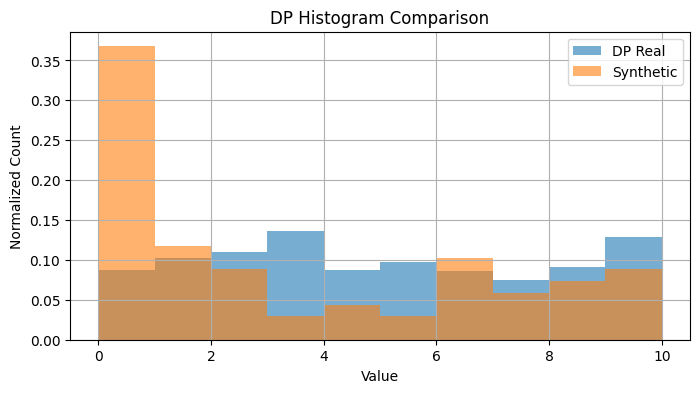

In [ ]:
# from sdmetrics.single_table import DCRBaselineProtection
# from sdv.metadata import SingleTableMetadata

# # Step 1: Detect metadata
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data=real_sorted)

# # ✅ Step 2: Convert to dictionary
# metadata_dict = metadata.to_dict()

# # Step 3: Compute DCR breakdown
# score = DCRBaselineProtection.compute_breakdown(
#     real_data=real_sorted,
#     synthetic_data=synth_sorted,
#     metadata=metadata_dict
# )

# print(score)



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# -----------------------
# Parameters
# -----------------------
epsilon = 0.60  # privacy budget
sensitivity = 1.0  # assume bounded data in [0, 1] range

# -----------------------
# Generate Sample Data
# -----------------------
np.random.seed(42)
real_data = real_sorted[['raw_amount']]
synthetic_data = synth_sorted[['raw_amount']]

# -----------------------
# 1. Differentially Private Mean
# -----------------------
def dp_mean(data, epsilon, sensitivity):
    true_mean = np.mean(data)
    noise = np.random.laplace(loc=0.0, scale=sensitivity/epsilon)
    return true_mean + noise

dp_real_mean = dp_mean(real_data, epsilon, sensitivity)
synthetic_mean = np.mean(synthetic_data)

print(f"Differentially Private Mean (Real): {dp_real_mean:.2f}")
print(f"Mean (Synthetic): {synthetic_mean:.2f}")

# -----------------------
# 2. Differentially Private Histogram
# -----------------------
def dp_histogram(data, bins, epsilon):
    counts, bin_edges = np.histogram(data, bins=bins, range=(0, 10))
    dp_counts = counts + np.random.laplace(scale=1/epsilon, size=len(counts))
    dp_counts = np.clip(dp_counts, 0, None)  # remove negative counts
    return dp_counts, bin_edges

bins = 10
dp_real_hist, bin_edges = dp_histogram(real_data, bins, epsilon)
synthetic_hist, _ = np.histogram(synthetic_data, bins=bins, range=(0, 10))

# Normalize for comparison
dp_real_hist_norm = dp_real_hist / np.sum(dp_real_hist)
synthetic_hist_norm = synthetic_hist / np.sum(synthetic_hist)

# -----------------------
# 3. Compute Histogram Distance
# -----------------------
distance = wasserstein_distance(dp_real_hist_norm, synthetic_hist_norm)
print(f"Wasserstein distance (DP real vs synthetic): {distance:.4f}")

# -----------------------
# 4. Plotting
# -----------------------
plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], dp_real_hist_norm, width=1, alpha=0.6, label="DP Real", align='edge')
plt.bar(bin_edges[:-1], synthetic_hist_norm, width=1, alpha=0.6, label="Synthetic", align='edge')
plt.legend()
plt.title("DP Histogram Comparison")
plt.xlabel("Value")
plt.ylabel("Normalized Count")
plt.grid(True)
plt.show()


In [ ]:

# from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
# n = 1056320
# batch_size = 700
# noise_multiplier = 2.2
# epochs = 100
# delta = 1e-5
# epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=batch_size,noise_multiplier=noise_multiplier,epochs=epochs,delta=delta)
# epsilon

## Evaluation

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.util import ngrams
from scipy.special import rel_entr
from scipy.special import entr
from scipy.spatial import distance

from scipy.stats import energy_distance
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
import random
import os

# random.seed(0)
# np.random.seed(0)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'




def ks_dist(real_obs, gen_obs):
    stat, pval = ks_2samp(real_obs, gen_obs)

    return stat

def comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf):
    """
    CONT_FIELDS : list of continuous columns
    CF_FIELD: name of the column in real_cf and synth_cf (used for computing cash flow)
    CONTINUOUS_METRICS = {"wasser": wasserstein_distance, "ks": ks_dist,"energy_d": energy_distance}
    real_cf, synth_cf: groupby(["account_id", "month", "year"]) real, and synth. and compute the sum of the raw_amount.

    """
    CONTINUOUS_METRICS = {"wasser": wasserstein_distance, "ks": ks_dist,"energy_d": energy_distance}
    univariate_cont_res = {}

    for field in CONT_FIELDS:
        univariate_cont_res[field] = {}
        for name, fn in CONTINUOUS_METRICS.items():
            univariate_cont_res[field][name] = fn(real[field], synth[field])

    univariate_cont_res['CF'] = {}
    for name, fn in CONTINUOUS_METRICS.items():
        univariate_cont_res['CF'][name] = fn(real_cf[CF_FIELD], synth_cf[CF_FIELD])
    return univariate_cont_res

def comapre_unidist_cat(real, synth, field):
    real_distribution = real[field].value_counts(normalize=True).sort_index()
    synthetic_distribution = synth[field].value_counts(normalize=True).sort_index()
    df_tcode = pd.merge(real_distribution, synthetic_distribution, left_index=True, right_index=True, how='outer')
    df_tcode.columns = ['real', 'synthetic']

    # Fill missing values with 0
    df_tcode.fillna(0, inplace=True)
    df_tcode['mid'] = (df_tcode['real'] + df_tcode['synthetic'])/2
    kl_real_M = sum(rel_entr(df_tcode['real'], df_tcode['mid']))
    kl_gen_M = sum(rel_entr(df_tcode['synthetic'], df_tcode['mid']))

    jsd = (kl_real_M + kl_gen_M)/2
    return jsd

def create_ngramcount_df(df, n, field):
    #gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    gb = df.groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1


    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)


    return df.reset_index().rename(columns={"index": "ngram"})

def compute_ngram_metrics(real_df, gen_df, field, n , pseudo_counts=0.0):


    n_codes_unique = len(set(real_df[field].unique()).union(set(gen_df[field].unique())))


    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    real_ngrams = create_ngramcount_df(real_df, n, field)
    gen_ngrams = create_ngramcount_df(gen_df, n, field)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)


    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    N_possible_ngrams = n_codes_unique**n


    # add psudo-counts
    combo_df["counts_real"] += pseudo_counts
    combo_df["ps_real"] = combo_df["counts_real"] / (N_obs_real + N_possible_ngrams*pseudo_counts)
    combo_df["counts_gen"] += pseudo_counts
    combo_df["ps_gen"] = combo_df["counts_gen"] / (N_obs_gen + N_possible_ngrams*pseudo_counts)




    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"]))
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2


    # compute entropy for both distributions
    n_unobs = N_possible_ngrams - len(combo_df)

    entr_r = entr(combo_df["ps_real"]).sum()  # from observed

    entr_g = entr(combo_df["ps_gen"]).sum()  # from observed

    results = {"jsd":jsd,
                      "entr_r":entr_r,
                      "entr_g":entr_g,
                      "NED": entr_r - entr_g,
                      "l1":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=1),
                      "l2":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=2),
                      "jac": distance.jaccard(combo_df["counts_real"]>0, combo_df["counts_gen"] > 0),
                      "count_r": len(real_ngrams),
                      "coverage_r": len(real_ngrams)/N_possible_ngrams,
                      "count_g": len(gen_ngrams),
                      "coverage_g": len(gen_ngrams)/N_possible_ngrams,
                      "count_max": N_possible_ngrams,
                      "field": field,
                       "n":n,
                       "pseudo_counts":pseudo_counts}

    return combo_df, results

#joint distribution of two categorical columns
def compute_2d_categorical_metrics(real_df, gen_df, field1, field2):
    f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))
    f2_opts = set(real_df[field2].unique()).union(set(gen_df[field2].unique()))

    n_opts_total = len(f1_opts) * len(f2_opts)

    kl_r_m = 0.
    kl_g_m = 0.
    entr_r = 0.
    entr_g = 0.
    l1_d = 0.
    l2_d = 0.
    count_g = 0.
    count_r = 0.

    observed_opts = 0

    cont_metric_results = {}
    for code_1 in f1_opts:
        for code_2 in f2_opts:
            cond_r = np.logical_and(real_df[field1] == code_1, real_df[field2] == code_2)
            cond_g = np.logical_and(gen_df[field1] == code_1, gen_df[field2] == code_2)

            p_r = (np.sum(cond_r)) / (len(cond_r))
            p_g = (np.sum(cond_g)) / (len(cond_g))
            p_m = (p_r + p_g) / 2.

            if np.sum(cond_r) + np.sum(cond_g) > 0:
                observed_opts += 1


            count_r += int(np.sum(cond_r) > 0)
            count_g += int(np.sum(cond_g) > 0)

            l1_d += np.abs(p_r - p_g)
            l2_d += (p_r - p_g) ** 2


            if p_r > 0:
                kl_r_m += p_r * np.log(p_r / p_m)
                entr_r += - p_r * np.log(p_r)

            if p_g > 0:
                kl_g_m += p_g * np.log(p_g / p_m)
                entr_g += - p_g * np.log(p_g)

    # compute jaccard
    sr = set(zip(real_df[field1].to_list(), real_df[field2].to_list()))
    sg = set(zip(gen_df[field1].to_list(), gen_df[field2].to_list()))
    s_union = len(sr.union(sg))
    s_inter = len(sr.intersection(sg))
    jacc_d = (s_union - s_inter) / s_union

    # finshed l2
    l2_d = np.sqrt(l2_d)

    # coverage
    coverage_g = count_g / n_opts_total
    coverage_r = count_r / n_opts_total

    #jsd
    jsd = (kl_r_m + kl_g_m) / 2


    result = {'jsd': jsd,
                    'entr_r': entr_r,
                    'entr_g': entr_g,
                    'l1': l1_d,
                    'l2': l2_d,
                    'jac': jacc_d,
                    'count_r': count_r,
                    'coverage_r': coverage_r,
                    'count_g': count_g,
                    'coverage_g': coverage_g,
                    'count_max': n_opts_total}
    return result



In [ ]:
synth_sorted.to_csv('synth_sorted_StDDPM_Bestsofar_02_ctadim_16.csv')

In [12]:
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result



{'jsd': 0.17491328566605566,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.224761313349021),
 'NED': np.float64(-0.7994996550475131),
 'l1': np.float64(0.8973586223983657),
 'l2': 0.07372654563860424,
 'jac': np.float64(0.5787427090084252),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2955,
 'coverage_g': 0.721435546875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [13]:
CAT_FIELDS = ['tcode']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real_sorted, synth_sorted, field)
result_jst_cat

{'tcode': 0.005978862167107553}

In [14]:
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real_sorted, synth_sorted, real_cf, synth_cf)

{'amount': {'wasser': np.float64(1037.9872179258819),
  'ks': np.float64(0.11146419342623443),
  'energy_d': np.float64(10.916381035148875)},
 'td': {'wasser': np.float64(10.47821970009089),
  'ks': np.float64(0.17514179718267198),
  'energy_d': np.float64(1.4040948405282712)},
 'CF': {'wasser': np.float64(5764.385497335616),
  'ks': np.float64(0.19267508678098344),
  'energy_d': np.float64(30.833226284603928)}}

In [15]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_sorted, field)
result_jst_cat

{'tcode': 0.005978862167107553,
 'day': 0.014957158241380976,
 'month': 0.016816985772396528}

In [16]:
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth_sorted, real_cf, synth_cf)

{'amount': {'wasser': np.float64(1037.9872179258819),
  'ks': np.float64(0.11146419342623443),
  'energy_d': np.float64(10.916381035148875)},
 'td': {'wasser': np.float64(10.47821970009089),
  'ks': np.float64(0.17514179718267198),
  'energy_d': np.float64(1.4040948405282712)},
 'CF': {'wasser': np.float64(5764.385497335616),
  'ks': np.float64(0.19267508678098344),
  'energy_d': np.float64(30.833226284603928)}}

In [17]:
field1='tcode'
field2='day'

compute_2d_categorical_metrics(real_sorted, synth_sorted, field1, field2)

{'jsd': np.float64(0.05919772042901358),
 'entr_r': np.float64(4.314351501994386),
 'entr_g': np.float64(4.742873666868754),
 'l1': np.float64(0.4643701529839441),
 'l2': np.float64(0.08722564472730801),
 'jac': 0.5151515151515151,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 495.0,
 'coverage_g': 0.9979838709677419,
 'count_max': 496}

In [ ]:
synth_sorted.to_csv('StDDPM_n_cat_dim_8.csv')

In [ ]:
# batch size 550 , cat_emb_dim 8-- change cat_emb_dim from 8 to 16-- best results

# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 16
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 550
# learning_rate = 2e-4
# n_sequences = 5000

{'jsd': np.float64(0.05940973841613085),
 'entr_r': np.float64(4.314351501994388),
 'entr_g': np.float64(4.831546874802383),
 'l1': np.float64(0.4337062738564076),
 'l2': np.float64(0.09281094111388691),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(1255.2762129354942),
  'ks': np.float64(0.14040384959103303),
  'energy_d': np.float64(9.38177332198155)},
 'td': {'wasser': np.float64(242.25959949560746),
  'ks': np.float64(0.4532925),
  'energy_d': np.float64(9.470416521069259)},
 'CF': {'wasser': np.float64(3952.1926315715114),
  'ks': np.float64(0.25785715143433635),
  'energy_d': np.float64(28.377518673931124)}}


  {'tcode': 0.005053614190809564,
 'day': 0.02161925020852147,
 'month': 0.04013156796115447}



 {'jsd': 0.1778355778234001,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.440842231486638),
 'NED': np.float64(-1.0155805731851295),
 'l1': np.float64(0.8999281530294172),
 'l2': 0.0725494048250931,
 'jac': np.float64(0.5946682823386853),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3208,
 'coverage_g': 0.783203125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}


# batch size 550 , cat_emb_dim 8-- change cat_emb_dim from 4 to 8


# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 8
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 550
# learning_rate = 2e-4
# n_sequences = 5000


{'jsd': np.float64(0.05919772042901356),
 'entr_r': np.float64(4.314351501994387),
 'entr_g': np.float64(4.742873666868757),
 'l1': np.float64(0.4643701529839443),
 'l2': np.float64(0.08722564472730798),
 'jac': 0.5151515151515151,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 495.0,
 'coverage_g': 0.9979838709677419,
 'count_max': 496}


{'amount': {'wasser': np.float64(1037.9872174786492),
  'ks': np.float64(0.14057384959103303),
  'energy_d': np.float64(10.916381033876313)},
 'td': {'wasser': np.float64(183.41011100348382),
  'ks': np.float64(0.4526525),
  'energy_d': np.float64(8.29991828878324)},
 'CF': {'wasser': np.float64(5764.385498403632),
  'ks': np.float64(0.19267508678098344),
  'energy_d': np.float64(30.833226284545027)}}


{'tcode': 0.005978862167107553,
 'day': 0.014957158241380976,
 'month': 0.016816985772396528}


{'jsd': 0.17491328566605566,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.224761313349021),
 'NED': np.float64(-0.7994996550475131),
 'l1': np.float64(0.8973586223983657),
 'l2': 0.07372654563860424,
 'jac': np.float64(0.5787427090084252),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2955,
 'coverage_g': 0.721435546875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}




# batch size = 700

{'jsd': np.float64(0.08503407807059207),
 'entr_r': np.float64(4.314351501994387),
 'entr_g': np.float64(4.897826493345175),
 'l1': np.float64(0.5706705952741593),
 'l2': np.float64(0.09850339154327205),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}

 {'amount': {'wasser': np.float64(573.7790849760546),
  'ks': np.float64(0.138638849591033),
  'energy_d': np.float64(5.030975137678782)},
 'td': {'wasser': np.float64(199.0839010034838),
  'ks': np.float64(0.4536875),
  'energy_d': np.float64(8.26646752122791)},
 'CF': {'wasser': np.float64(7575.510593990444),
  'ks': np.float64(0.25452753550862456),
  'energy_d': np.float64(38.696137244707)}


  {'tcode': 0.006210331675484432,
 'day': 0.02234341771418493,
 'month': 0.03729101335174556}

 {'jsd': 0.17285056082340167,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.185912977868551),
 'NED': np.float64(-0.7606513195670423),
 'l1': np.float64(0.9005789203603434),
 'l2': 0.07304991786541343,
 'jac': np.float64(0.5851528384279476),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3105,
 'coverage_g': 0.758056640625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}


# batch size 600

{'jsd': np.float64(0.08087596483175255),
 'entr_r': np.float64(4.314351501994387),
 'entr_g': np.float64(4.843273489972481),
 'l1': np.float64(0.5584409784913662),
 'l2': np.float64(0.10189335175942371),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(449.5774330946505),
  'ks': np.float64(0.13972884959103302),
  'energy_d': np.float64(4.720317717169141)},
 'td': {'wasser': np.float64(186.97576449560736),
  'ks': np.float64(0.449275),
  'energy_d': np.float64(7.895354577780595)},
 'CF': {'wasser': np.float64(6871.303011376896),
  'ks': np.float64(0.23454992979044237),
  'energy_d': np.float64(34.56760986879632)}}


{'tcode': 0.006845046775373872,
 'day': 0.02536429994123815,
 'month': 0.03941054445912223}

 {'jsd': 0.172344175234331,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.191745884547583),
 'NED': np.float64(-0.7664842262460745),
 'l1': np.float64(0.9010245880817167),
 'l2': 0.07327433962759247,
 'jac': np.float64(0.5781550288276746),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3008,
 'coverage_g': 0.734375,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}



# batch size 512

{'jsd': np.float64(0.07660451637771198),
 'entr_r': np.float64(4.314351501994389),
 'entr_g': np.float64(4.773051648741174),
 'l1': np.float64(0.541468650408967),
 'l2': np.float64(0.1081691638263528),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}

 {'amount': {'wasser': np.float64(494.74082062688717),
  'ks': np.float64(0.140071349591033),
  'energy_d': np.float64(4.923407747866266)},
 'td': {'wasser': np.float64(170.91197350348378),
  'ks': np.float64(0.4429),
  'energy_d': np.float64(7.468495803495549)},
 'CF': {'wasser': np.float64(6469.404941067835),
  'ks': np.float64(0.22359421613371505),
  'energy_d': np.float64(32.54655012173227)}}

{'tcode': 0.008218540637440035,
 'day': 0.03072219669954107,
 'month': 0.036959178592128716}


 {'jsd': 0.1712850436708322,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.11956506835222),
 'NED': np.float64(-0.6943034100507113),
 'l1': np.float64(0.8986747966237636),
 'l2': 0.07427922931108039,
 'jac': np.float64(0.562753036437247),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2829,
 'coverage_g': 0.690673828125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}





# batch size= 550


field1='tcode'
field2='day'

compute_2d_categorical_metrics(real_sorted, synth_sorted, field1, field2)
{'jsd': np.float64(0.0786037011538516),
 'entr_r': np.float64(4.314351501994389),
 'entr_g': np.float64(4.8016396077183074),
 'l1': np.float64(0.5490860602847615),
 'l2': np.float64(0.10509437001523017),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


{'amount': {'wasser': np.float64(444.8504655489797),
  'ks': np.float64(0.13981384959103302),
  'energy_d': np.float64(4.772238504450334)},
 'td': {'wasser': np.float64(179.4046785034838),
  'ks': np.float64(0.445875),
  'energy_d': np.float64(7.672105586019478)},
 'CF': {'wasser': np.float64(6733.25693975155),
  'ks': np.float64(0.22719991172492537),
  'energy_d': np.float64(33.51933003315149)}}


  {'tcode': 0.007818397632609386,
 'day': 0.02832869503996168,
 'month': 0.038070737172335056}


{'jsd': 0.17238163960776848,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.160784423026302),
 'NED': np.float64(-0.7355227647247933),
 'l1': np.float64(0.9006755183682503),
 'l2': 0.07392982060790831,
 'jac': np.float64(0.5753199868723334),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2910,
 'coverage_g': 0.71044921875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}


# batch size=650

{'jsd': np.float64(0.0837002852020813),
 'entr_r': np.float64(4.314351501994389),
 'entr_g': np.float64(4.86526164574032),
 'l1': np.float64(0.5686511299606181),
 'l2': np.float64(0.10119735717192949),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(444.88268393514625),
  'ks': np.float64(0.13929384959103303),
  'energy_d': np.float64(4.942640984538327)},
 'td': {'wasser': np.float64(193.70603600348377),
  'ks': np.float64(0.4500925),
  'energy_d': np.float64(8.120029676102266)},
 'CF': {'wasser': np.float64(6969.059863078965),
  'ks': np.float64(0.24000699396663572),
  'energy_d': np.float64(35.46917455524883)}}


{'tcode': 0.006555427336225996,
 'day': 0.024737811189794484,
 'month': 0.03799567839383504}


 {'jsd': 0.17277805811805708,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.18376414835726),
 'NED': np.float64(-0.7585024900557515),
 'l1': np.float64(0.9011201754514822),
 'l2': 0.0732449248324952,
 'jac': np.float64(0.5802861685214626),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3034,
 'coverage_g': 0.74072265625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}




# stddpm batch size=1024; it make tcode better but ruin amount, cash flow, tcode-day joint

{'jsd': np.float64(0.11121676468932551),
 'entr_r': np.float64(4.3143515019943885),
 'entr_g': np.float64(5.032939399620821),
 'l1': np.float64(0.6744839957588603),
 'l2': np.float64(0.0968417128638896),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}

{'amount': {'wasser': np.float64(3470.920025512225),
  'ks': np.float64(0.12033384959103302),
  'energy_d': np.float64(20.38549383024017)},
 'td': {'wasser': np.float64(237.01550600348384),
  'ks': np.float64(0.46056),
  'energy_d': np.float64(9.422026676847572)},
 'CF': {'wasser': np.float64(13532.383390197554),
  'ks': np.float64(0.2896214075455459),
  'energy_d': np.float64(60.17520872662657)}}

{'tcode': 0.006048111232629034,
 'day': 0.020190802955675623,
 'month': 0.028509262765095952}

{'jsd': 0.18091897130781143,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.257405184736943),
 'NED': np.float64(-0.8321435264354351),
 'l1': np.float64(0.9127953575279321),
 'l2': 0.07312394946402813,
 'jac': np.float64(0.5974025974025974),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3321,
 'coverage_g': 0.810791015625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}


###############################
#StDDPM df=10

{'amount': {'wasser': np.float64(494.6060328511747),
  'ks': np.float64(0.140071349591033),
  'energy_d': np.float64(4.922847198127106)},
 'td': {'wasser': np.float64(170.9193435034838),
  'ks': np.float64(0.4429175),
  'energy_d': np.float64(7.469089767168035)},
 'CF': {'wasser': np.float64(6470.7524965989805),
  'ks': np.float64(0.22358074422803204),
  'energy_d': np.float64(32.54637415891855)}}


  {'tcode': 0.008219681987261595,
 'day': 0.03071660445131572,
 'month': 0.03694779316875245}

 {'jsd': 0.1712658995447815,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.119577100290316),
 'NED': np.float64(-0.6943154419888078),
 'l1': np.float64(0.8985824889314559),
 'l2': 0.07428172198248448,
 'jac': np.float64(0.562753036437247),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2829,
 'coverage_g': 0.690673828125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}


 {'jsd': np.float64(0.0765944579544505),
 'entr_r': np.float64(4.314351501994389),
 'entr_g': np.float64(4.773079154445821),
 'l1': np.float64(0.5414036504089661),
 'l2': np.float64(0.10816282871775047),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


In [ ]:
# NormalDDPM cat_emb_dim= 16



# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 16
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 550
# learning_rate = 2e-4
# n_sequences = 5000



# tcode 3 g
{'jsd': 0.17843809837454452,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.4261757712464),
 'NED': np.float64(-1.0009141129448915),
 'l1': np.float64(0.8997436128550822),
 'l2': 0.07312726942995709,
 'jac': np.float64(0.5958800363526204),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 3204,
 'coverage_g': 0.7822265625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

# tcode- day

{'jsd': np.float64(0.062026249005012),
 'entr_r': np.float64(4.3143515019943885),
 'entr_g': np.float64(4.853588020803628),
 'l1': np.float64(0.4539677067555288),
 'l2': np.float64(0.09551953705573091),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


{'amount': {'wasser': np.float64(812.1152411529121),
  'ks': np.float64(0.125161349591033),
  'energy_d': np.float64(5.0269263458924325)},
 'td': {'wasser': np.float64(235.7787869956074),
  'ks': np.float64(0.4544825),
  'energy_d': np.float64(9.29847162982468)},
 'CF': {'wasser': np.float64(6978.907761465917),
  'ks': np.float64(0.2659913497524982),
  'energy_d': np.float64(35.938454974871355)}}




 {'tcode': 0.005777502537274647,
 'day': 0.022072009621230314,
 'month': 0.04127093362172493}




# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 8
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 550
# learning_rate = 2e-4
# n_sequences = 5000

{'jsd': np.float64(0.06338512704141423),
 'entr_r': np.float64(4.314351501994389),
 'entr_g': np.float64(4.774160895151866),
 'l1': np.float64(0.48103280369584983),
 'l2': np.float64(0.08617029024811015),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(1779.0730542060292),
  'ks': np.float64(0.13275134959103302),
  'energy_d': np.float64(14.213816033542411)},
 'td': {'wasser': np.float64(169.72720600348376),
  'ks': np.float64(0.45158),
  'energy_d': np.float64(7.836254483440049)},
 'CF': {'wasser': np.float64(8821.950507863581),
  'ks': np.float64(0.19875641722785864),
  'energy_d': np.float64(38.46183817294492)}}

  {'tcode': 0.00811875920261603,
 'day': 0.012371116934904725,
 'month': 0.023987099050043644}


 {'jsd': 0.18000682208380347,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.171928078585724),
 'NED': np.float64(-0.7466664202842157),
 'l1': np.float64(0.9160211724773464),
 'l2': 0.07524369914402218,
 'jac': np.float64(0.5787770947913297),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2962,
 'coverage_g': 0.72314453125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [ ]:
# StDDPM df=8
#  {'jsd': np.float64(0.07778238220001725),
#  'entr_r': np.float64(4.314351501994389),
#  'entr_g': np.float64(4.772043570398884),
#  'l1': np.float64(0.5489658573159641),
#  'l2': np.float64(0.10952944797278633),
#  'jac': 0.5181451612903226,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 495.0,
#  'coverage_g': 0.9979838709677419,
#  'count_max': 496}


#  {'amount': {'wasser': np.float64(706.2074812997024),
#   'ks': np.float64(0.14024134959103302),
#   'energy_d': np.float64(5.946062421047733)},
#  'td': {'wasser': np.float64(171.82667100348377),
#   'ks': np.float64(0.4441775),
#   'energy_d': np.float64(7.506624161147231)},
#  'CF': {'wasser': np.float64(5662.095925275572),
#   'ks': np.float64(0.22508261599681095),
#   'energy_d': np.float64(30.895410908673306)}}.



#   {'tcode': 0.009105659450661762,
#  'day': 0.03203650218045237,
#  'month': 0.03750761238221766}


#  {'jsd': 0.17341515524061946,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.112476014493051),
#  'NED': np.float64(-0.6872143561915429),
#  'l1': np.float64(0.9082702391549811),
#  'l2': 0.07488385044436272,
#  'jac': np.float64(0.5649546827794562),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2844,
#  'coverage_g': 0.6943359375,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}

In [ ]:
# # stddpm df=5, (15 was not good)

# {'jsd': np.float64(0.07529878190039124),
#  'entr_r': np.float64(4.314351501994387),
#  'entr_g': np.float64(4.828698762376021),
#  'l1': np.float64(0.5446615692214481),
#  'l2': np.float64(0.10776619107765234),
#  'jac': 0.5151515151515151,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 495.0,
#  'coverage_g': 0.9979838709677419,
#  'count_max': 496}

#  {'amount': {'wasser': np.float64(1203.7321771022657),
#   'ks': np.float64(0.140473849591033),
#   'energy_d': np.float64(9.163172982682672)},
#  'td': {'wasser': np.float64(171.57057699560738),
#   'ks': np.float64(0.4454525),
#   'energy_d': np.float64(7.440856842983495)},
#  'CF': {'wasser': np.float64(4448.071149952515),
#   'ks': np.float64(0.23708903812049004),
#   'energy_d': np.float64(29.09744104271158)}}


#   {'tcode': 0.012445534298523832,
#  'day': 0.029684389232899098,
#  'month': 0.04016987211462156}


#  {'jsd': 0.17775105351885384,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.166170310945912),
#  'NED': np.float64(-0.7409086526444035),
#  'l1': np.float64(0.9152487390036792),
#  'l2': 0.07660509420137199,
#  'jac': np.float64(0.5686077643908969),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2846,
#  'coverage_g': 0.69482421875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}

In [ ]:
# student t results

  {'jsd': np.float64(0.08295930264838589),
 'entr_r': np.float64(4.314351501994392),
 'entr_g': np.float64(4.853933521392153),
 'l1': np.float64(0.5597350984550138),
 'l2': np.float64(0.1139015599337199),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(525.6874720038077),
  'ks': np.float64(0.13977634959103302),
  'energy_d': np.float64(4.959437872557085)},
 'td': {'wasser': np.float64(178.4933769956074),
  'ks': np.float64(0.4499425),
  'energy_d': np.float64(7.643800210593571)},
 'CF': {'wasser': np.float64(6026.613938941345),
  'ks': np.float64(0.20458555783532117),
  'energy_d': np.float64(28.65306240935964)}}


  {'tcode': 0.014388955927836726,
 'day': 0.0324606996074009,
 'month': 0.05102675914252052}



 {'jsd': 0.18684108593051513,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.274975722364785),
 'NED': np.float64(-0.849714064063277),
 'l1': np.float64(0.9412077658531617),
 'l2': 0.07843413033930088,
 'jac': np.float64(0.5759162303664922),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2921,
 'coverage_g': 0.713134765625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [ ]:
# normalddpm




#  day-tcode
  {'jsd': np.float64(0.06867854521161998),
 'entr_r': np.float64(4.314351501994392),
 'entr_g': np.float64(4.826901872221953),
 'l1': np.float64(0.4898315086337478),
 'l2': np.float64(0.09992993747764413),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}


 {'amount': {'wasser': np.float64(1844.512803824054),
  'ks': np.float64(0.11577884959103302),
  'energy_d': np.float64(9.748446975891657)},
 'td': {'wasser': np.float64(10.852639700090878),
  'ks': np.float64(0.14611848000605876),
  'energy_d': np.float64(1.2764814807973328)},
 'CF': {'wasser': np.float64(10874.57488104796),
  'ks': np.float64(0.21112468785250693),
  'energy_d': np.float64(42.492740379906316)}}


  {'tcode': 0.009383858715909469,
 'day': 0.022586889973830182,
 'month': 0.033761669898399134}





 {'jsd': 0.17579718397663519,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.127648474437132),
 'NED': np.float64(-0.7023868161356237),
 'l1': np.float64(0.9079442683988534),
 'l2': 0.07587489437277835,
 'jac': np.float64(0.5656800798137679),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2882,
 'coverage_g': 0.70361328125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [ ]:
synth_sorted_NDDPM=pd.read_csv('synth_sorted_NDDPM.csv')

synth_sorted_NDDPM['datetime'] = pd.to_datetime(synth_sorted_NDDPM[['year', 'month', 'day']], errors='coerce')

# Optionally: Find invalid rows
invalid_dates = synth_sorted_NDDPM[synth_sorted_NDDPM['datetime'].isna()]
synth_sorted_NDDPM['datetime'] = pd.to_datetime(synth_sorted_NDDPM['datetime']).dt.date


from datetime import datetime

synth=synth_sorted_NDDPM
synth['datetime'] = pd.to_datetime(synth['datetime'], errors='coerce')
synth['datetime'] = pd.to_datetime(synth['datetime']).dt.date
synth=synth.dropna()
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["datetime"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month
synth["day"] = synth["datetime"].dt.day
synth["dow"] =  synth["datetime"].dt.dayofweek
synth["year"] = synth["datetime"].dt.year

synth["td"] = synth[["account_id", "datetime"]].groupby("account_id").diff()
synth["td"] = synth["td"].apply(lambda x: x.days)
synth["td"].fillna(0.0, inplace=True)

# synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth["dtme"] = synth.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])


synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

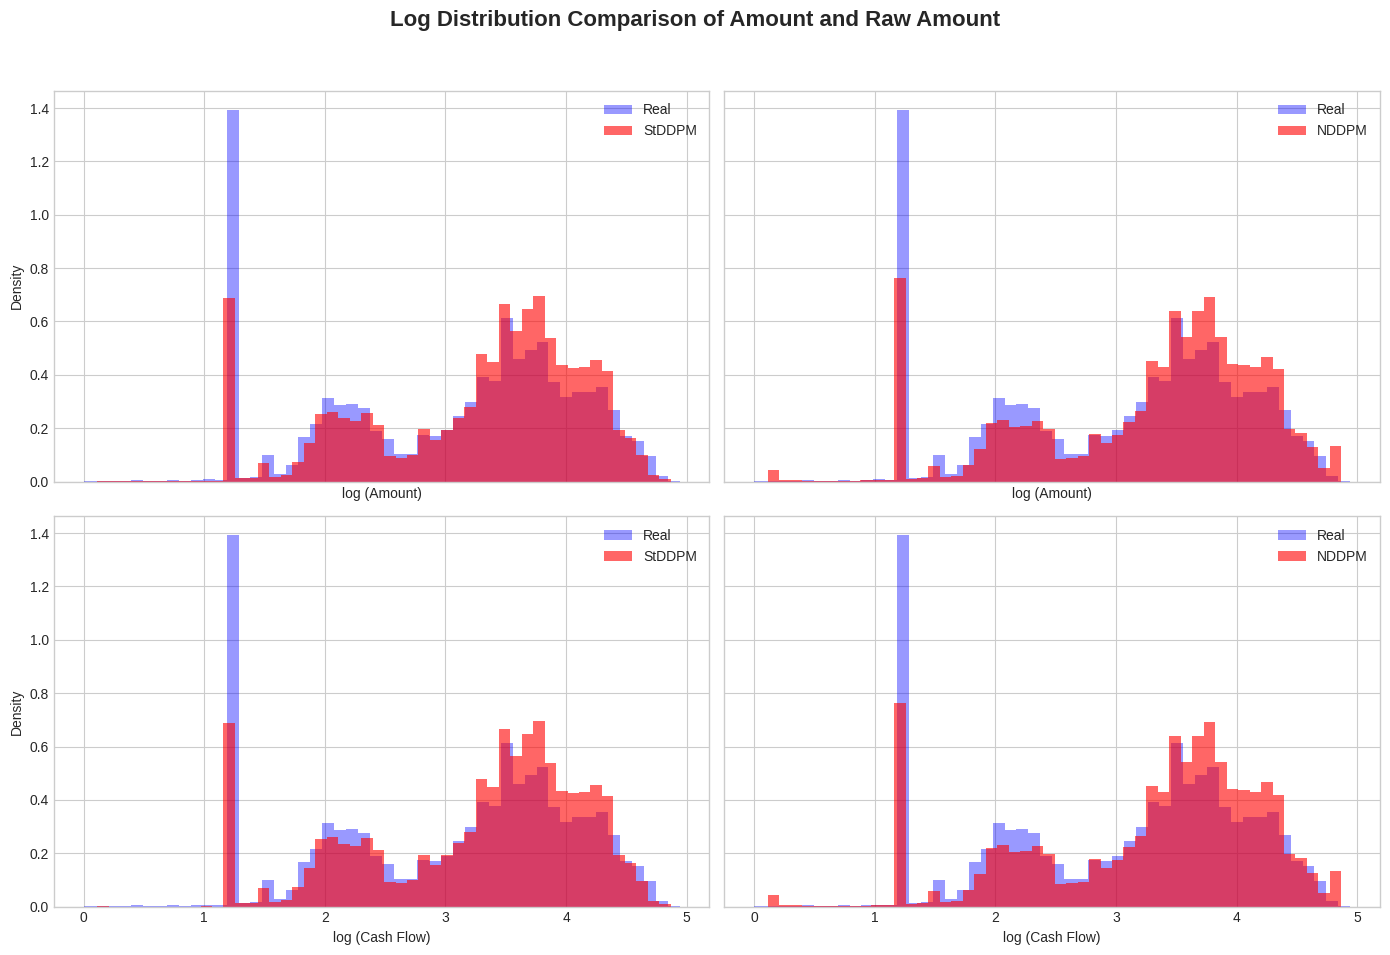

In [ ]:
# import matplotlib.pyplot as plt
# # Extract the 'amount' column from each dataset
# amt_synthbf = np.log10(synth_sorted['amount'] + 1)
# amt_real = np.log10(real_sorted['amount']+ 1)


# # Plot histograms
# plt.hist(amt_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
# plt.hist(amt_synthbf, bins=50, alpha=0.7,color='red',density=True, label='StDDPM')


# plt.xlabel('Amount')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.title('Distribution of Amounts')
# plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Apply log transformation
log_amount_real = np.log10(real_sorted['amount'] + 1)
log_amount_stddpm = np.log10(synth_sorted['amount'] + 1)
log_amount_ndddpm = np.log10(synth_sorted_NDDPM['amount'] + 1)

log_raw_real = np.log10(real_sorted['raw_amount'].abs() + 1)
log_raw_stddpm = np.log10(synth_sorted['raw_amount'].abs() + 1)
log_raw_ndddpm = np.log10(synth_sorted_NDDPM['raw_amount'].abs() + 1)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle("Log Distribution Comparison of Amount and Raw Amount", fontsize=16, fontweight='bold')

# Top-left: Amount (StDDPM)
axes[0, 0].hist(log_amount_real, bins=50, alpha=0.4, color='blue', density=True, label='Real')
axes[0, 0].hist(log_amount_stddpm, bins=50, alpha=0.6, color='red', density=True, label='StDDPM')
# axes[0, 0].set_title("Log(Amount) - StDDPM")
axes[0, 0].legend()



# Top-right: Amount (NDDPM)
axes[0, 1].hist(log_amount_real, bins=50, alpha=0.4, color='blue', density=True, label='Real')
axes[0, 1].hist(log_amount_ndddpm, bins=50, alpha=0.6, color='red', density=True, label='NDDPM')
# axes[0, 1].set_title("Log(Amount) - NDDPM")
axes[0, 1].legend()

# Bottom-left: Raw Amount (StDDPM)
axes[1, 0].hist(log_raw_real, bins=50, alpha=0.4, color='blue', density=True, label='Real')
axes[1, 0].hist(log_raw_stddpm, bins=50, alpha=0.6, color='red', density=True, label='StDDPM')
# axes[1, 0].set_title("Log(Raw Amount) - StDDPM")
axes[1, 0].legend()

# Bottom-right: Raw Amount (NDDPM)
axes[1, 1].hist(log_raw_real, bins=50, alpha=0.4, color='blue', density=True, label='Real')
axes[1, 1].hist(log_raw_ndddpm, bins=50, alpha=0.6, color='red', density=True, label='NDDPM')
# axes[1, 1].set_title("Log(Raw Amount) - NDDPM")
axes[1, 1].legend()

# Axis labels
axes[0, 0].set_xlabel("log (Amount)")
axes[0, 1].set_xlabel("log (Amount)")
axes[1, 0].set_xlabel("log (Cash Flow)")
axes[1, 1].set_xlabel("log (Cash Flow)")

for ax in axes[:, 0]:
    ax.set_ylabel("Density")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("log_distribution_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


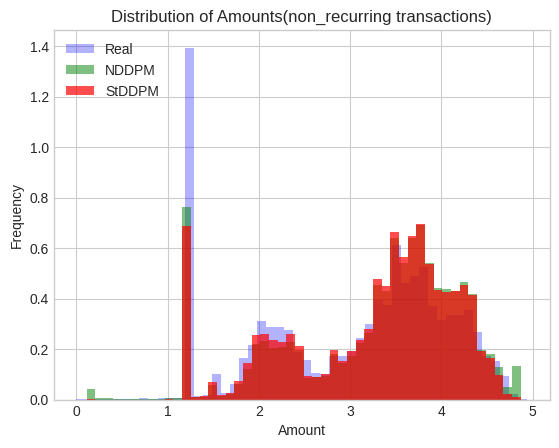

In [ ]:
# import matplotlib.pyplot as plt
# # Extract the 'amount' column from each dataset
# amt_synthbf = np.log10(synth_sorted_NDDPM['amount'] + 1)
# amt_real = np.log10(real_sorted['amount']+ 1)


# # Plot histograms
# plt.hist(amt_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
# plt.hist(amt_synthbf, bins=50, alpha=0.7,color='red',density=True, label='NDDPM')


# plt.xlabel('Amount')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.title('Distribution of Amounts')
# plt.show()



import matplotlib.pyplot as plt
# Extract the 'amount' column from each dataset
amt_synth_sorted= np.log10(synth_sorted['amount'] + 1)
amt_synth_sorted_NDDPM= np.log10(synth_sorted_NDDPM['amount']+ 1)
amt_real_sorted = np.log10(real_sorted['amount']+ 1)


# Plot histograms
plt.hist(amt_real_sorted, bins=50, alpha=0.3,color='blue', density= True, label='Real')
plt.hist(amt_synth_sorted_NDDPM, bins=50, alpha=0.5,color='green',density=True ,label='NDDPM')
plt.hist(amt_synth_sorted, bins=50, alpha=0.7,color='red', density=True, label='StDDPM')
# plt.hist(amt_norec_synthgan, bins=50, alpha=0.9, color='gray',density=True, label='BankGAN')

plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.title('Distribution of Amounts(non_recurring transactions)')
plt.show()

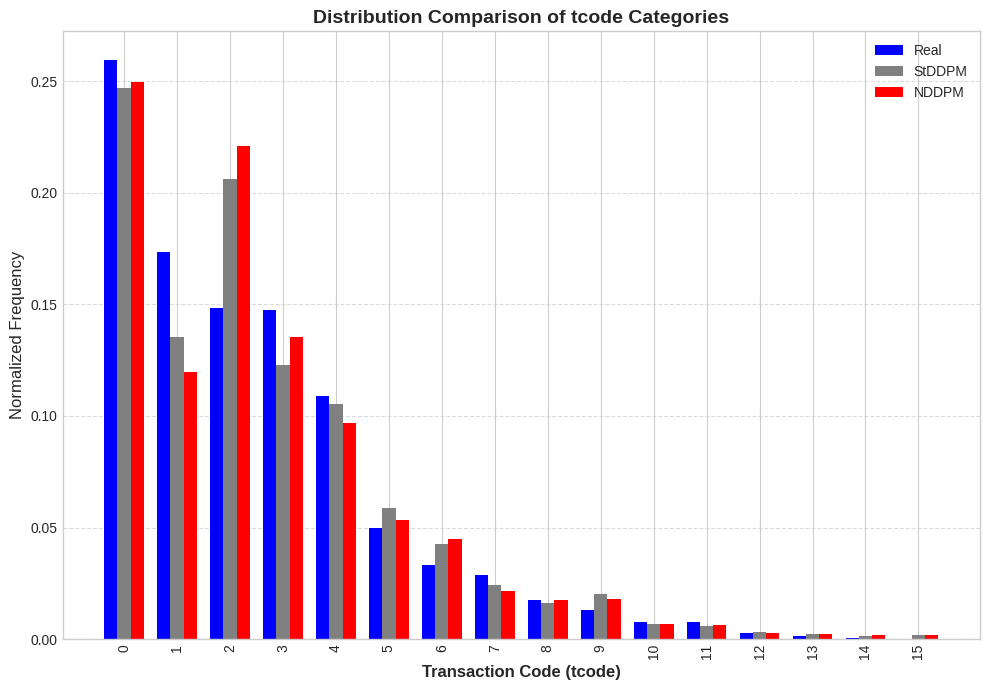

In [ ]:
# import matplotlib.pyplot as plt
# # Calculate the counts of each category for each DataFrame
# tcode_real_sorted = real_sorted['tcode'].value_counts().sort_values(ascending=False)
# tcode_synth_sorted = synth_sorted['tcode'].value_counts().reindex(tcode_real_sorted.index, fill_value=0)
# tcode_synth_sorted_NDDPM = synth_sorted_NDDPM['tcode'].value_counts().reindex(tcode_real_sorted.index, fill_value=0)


tcode_real_sorted_norm = tcode_real_sorted / tcode_real_sorted.sum()
tcode_synth_sorted_norm = tcode_synth_sorted / tcode_synth_sorted.sum()
tcode_synth_sorted_NDDPM_norm = tcode_synth_sorted_NDDPM / tcode_synth_sorted_NDDPM.sum()


# # The x position of bars
# positions = np.arange(len(tcode_real_sorted))

# # Create the bar plots with some transparency

# plt.bar(positions, tcode_synth_sorted_NDDPM_norm, alpha=0.9, color='red', label='NDDPM')
# plt.bar(positions, tcode_synth_sorted_norm, alpha=0.7, color='gray', label='StDDPM')

# plt.bar(positions, tcode_real_sorted_norm, alpha=0.7, color='blue', label='Real')



# # Add labels, legend, and title
# plt.xlabel('Category', fontweight='bold')
# #plt.xticks(positions, tcode_rec_real.index)
# plt.ylabel('Frequency')
# plt.title('Overlapping Bar Plots')

# plt.legend()

# # Show the plot
# plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Assume the value counts are already sorted as in your code
positions = np.arange(len(tcode_real_sorted))

bar_width = 0.25

plt.figure(figsize=(10, 7))

positions = np.arange(len(tcode_real_sorted))

# Plot grouped bars
plt.bar(positions - bar_width, tcode_real_sorted_norm, width=bar_width, label='Real', color='blue')
plt.bar(positions, tcode_synth_sorted_norm, width=bar_width, label='StDDPM', color='gray')
plt.bar(positions + bar_width, tcode_synth_sorted_NDDPM_norm, width=bar_width, label='NDDPM', color='red')

# Add labels and title
plt.xlabel('Transaction Code (tcode)', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Frequency', fontsize=12)
plt.title('Distribution Comparison of tcode Categories', fontsize=14, fontweight='bold')

# X-axis category labels
plt.xticks(positions, rotation=90)

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig("tcode_distribution_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


TypeError: '<=' not supported between instances of 'int' and 'str'

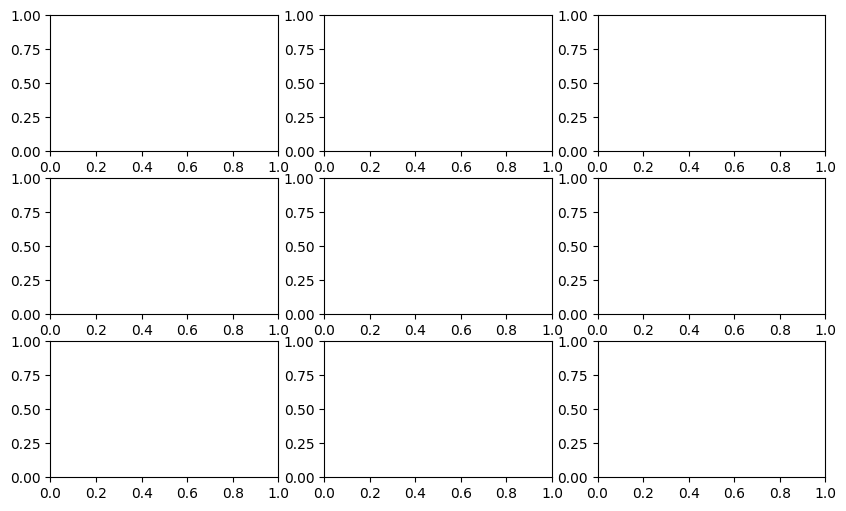

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(real_sorted), np.min(synth_sorted), np.min(synth_sorted_NDDPM))
x_max = max(np.max(real_sorted), np.max(synth_sorted), np.max(synth_sorted_NDDPM))

axes[0, 0].hist(real_sorted, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(synth_sorted, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper right', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(real_sorted, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(synth_sorted_NDDPM, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper right', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)



In [ ]:
import matplotlib.pyplot as plt
# Extract the 'amount' column from each dataset
amt_synthbf = np.log10(synth_sorted['amount'] + 1)
amt_real = np.log10(all_real['amount']+ 1)


# Plot histograms
plt.hist(amt_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
plt.hist(amt_synthbf, bins=50, alpha=0.7,color='red',density=True, label='StDDPM')


plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Amounts')
plt.show()

In [ ]:
# build a metadata for evaluation (from SDV)
metadata= SingleTableMetadata()
metadata.detect_from_dataframe(data=real)

#generate quality report
quality_report= sdv_st.evaluate_quality(
    real_data=real,
    synthetic_data=synth_sorted,
    metadata=metadata
)

ValueError: The metadata does not match the data. The following columns are missing in the real/synthetic data or in the metadata: Unnamed: 0

In [ ]:
# using quantiletransfromation

# {'jsd': 0.20895610685531635,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.470970665757771),
#  'NED': np.float64(-1.0457090074562627),
#  'l1': np.float64(1.0024058377229252),
#  'l2': 0.08006365467671196,
#  'jac': np.float64(0.5559477585598306),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2660,
#  'coverage_g': 0.6494140625,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.02774456991668183}


#  {'amount': {'wasser': np.float64(968.410722896976),
#   'ks': np.float64(0.1406286340572203),
#   'energy_d': np.float64(7.448278441147479)},
#  'td': {'wasser': np.float64(126.02985964069423),
#   'ks': np.float64(0.4282113009306922),
#   'energy_d': np.float64(5.70706700837831)},
#  'CF': {'wasser': np.float64(5247.605577433625),
#   'ks': np.float64(0.18768472068778763),
#   'energy_d': np.float64(26.143051713848166)}}


#   {'jsd': np.float64(0.06410917108699209),
#  'entr_r': np.float64(4.314351501994385),
#  'entr_g': np.float64(4.740457509293517),
#  'l1': np.float64(0.5334007575827873),
#  'l2': np.float64(0.10117351080460896),
#  'jac': 0.5370370370370371,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 471.0,
#  'coverage_g': 0.9495967741935484,
#  'count_max': 496}


# (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.61it/s]|
# Column Shapes Score: 84.3%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:05<00:00, 11.72it/s]|
# Column Pair Trends Score: 78.71%

# Overall Score (Average): 81.51%


#################### minmax scaler

# {'jsd': 0.21269415540111195,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.44288578106312),
#  'NED': np.float64(-1.017624122761612),
#  'l1': np.float64(1.012126580932822),
#  'l2': 0.08190782959868136,
#  'jac': np.float64(0.5562655307064253),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2636,
#  'coverage_g': 0.6435546875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.029975206665479072}



#  {'amount': {'wasser': np.float64(4097.36361365561),
#   'ks': np.float64(0.2365480164483358),
#   'energy_d': np.float64(34.153042649603826)},
#  'td': {'wasser': np.float64(139.95484090662794),
#   'ks': np.float64(0.4323053983355605),
#   'energy_d': np.float64(6.067448603527627)},
#  'CF': {'wasser': np.float64(9090.25328216198),
#   'ks': np.float64(0.20473236614961454),
#   'energy_d': np.float64(45.5045052306492)}}



# {'tcode': 0.029975206665479072,
#  'day': 0.030672299940901253,
#  'month': 0.03590046651411827}

#   {'jsd': np.float64(0.06361582421202078),
#  'entr_r': np.float64(4.31435150199439),
#  'entr_g': np.float64(4.77432743272917),
#  'l1': np.float64(0.546367792278892),
#  'l2': np.float64(0.10059388366937012),
#  'jac': 0.5185185185185185,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 480.0,
#  'coverage_g': 0.967741935483871,
#  'count_max': 496}



# standardization scaler

# {'jsd': 0.21871622040355754,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.317139108886275),
#  'NED': np.float64(-0.8918774505847669),
#  'l1': np.float64(1.0246080237771358),
#  'l2': 0.08424213105580201,
#  'jac': np.float64(0.5533667621776505),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2608,
#  'coverage_g': 0.63671875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}

#  {'tcode': 0.03550033279814385}

# {'amount': {'wasser': np.float64(1184.0571711537327),
#   'ks': np.float64(0.21740345837695266),
#   'energy_d': np.float64(13.36110780205315)},
#  'td': {'wasser': np.float64(125.61508986666297),
#   'ks': np.float64(0.43121447374176897),
#   'energy_d': np.float64(5.623829249655311)},
#  'CF': {'wasser': np.float64(7352.945519113788),
#   'ks': np.float64(0.159792953599026),
#   'energy_d': np.float64(31.66205270212965)}}

# {'tcode': 0.03550033279814385,
#  'day': 0.03472186205573735,
#  'month': 0.03969638143057709}


#  {'jsd': np.float64(0.06919931250185361),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.794699466984028),
#  'l1': np.float64(0.572270769850239),
#  'l2': np.float64(0.10733262603391942),
#  'jac': 0.5175983436853002,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 476.0,
#  'coverage_g': 0.9596774193548387,
#  'count_max': 496}


# (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.77it/s]|
# Column Shapes Score: 82.46%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:06<00:00, 10.51it/s]|
# Column Pair Trends Score: 73.36%

# Overall Score (Average): 77.91%


###################
# robust scaler

{'jsd': 0.2238249506595363,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.468087022035875),
#  'NED': np.float64(-1.0428253637343667),
#  'l1': np.float64(1.038884341292078),
#  'l2': 0.08316677979969443,
#  'jac': np.float64(0.5601659751037344),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2733,
#  'coverage_g': 0.667236328125,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.03769884734572386}

# {'amount': {'wasser': np.float64(1436.3370398134352),
#   'ks': np.float64(0.1892155429517546),
#   'energy_d': np.float64(11.810592396524745)},
#  'td': {'wasser': np.float64(129.2260706775895),
#   'ks': np.float64(0.43184739122323335),
#   'energy_d': np.float64(5.6902182153727505)},
#  'CF': {'wasser': np.float64(4811.216476938086),
#   'ks': np.float64(0.17638743125450845),
#   'energy_d': np.float64(24.666484804077665)}}


# {'tcode': 0.03769884734572386,
#  'day': 0.03578081122324883,
#  'month': 0.021950881272659734}

# {'jsd': np.float64(0.07257442453923015),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.8320032657329275),
#  'l1': np.float64(0.5807335189265228),
#  'l2': np.float64(0.10958341305469754),
#  'jac': 0.5192697768762677,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 490.0,
#  'coverage_g': 0.9879032258064516,
#  'count_max': 496}


#  (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.55it/s]|
# Column Shapes Score: 83.69%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:05<00:00, 11.36it/s]|
# Column Pair Trends Score: 74.05%

# Overall Score (Average): 78.87%


 # yeo johnson---Power Transformation

#  {'jsd': 0.21399510082575945,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.33399198903269),
#  'NED': np.float64(-0.9087303307311814),
#  'l1': np.float64(1.0138228453311977),
#  'l2': 0.08342103237472027,
#  'jac': np.float64(0.5546428571428571),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2616,
#  'coverage_g': 0.638671875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.03226479543497485}

# {'amount': {'wasser': np.float64(11854.191423262853),
#   'ks': np.float64(0.18017404641228188),
#   'energy_d': np.float64(8.686935581859142)},
#  'td': {'wasser': np.float64(128.10299283870805),
#   'ks': np.float64(0.4295799031539563),
#   'energy_d': np.float64(5.6317152086646765)},
#  'CF': {'wasser': np.float64(50156.51252091241),
#   'ks': np.float64(0.14878956069441968),
#   'energy_d': np.float64(32.322595025021315)}}



#   {'tcode': 0.03226479543497485,
#  'day': 0.03153657041535282,
#  'month': 0.038630186702060185}



#  {'jsd': np.float64(0.06685884116011785),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.801256970808941),
#  'l1': np.float64(0.5576092485901796),
#  'l2': np.float64(0.10263866578122155),
#  'jac': 0.5133470225872689,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 484.0,
#  'coverage_g': 0.9758064516129032,
#  'count_max': 496}


#  (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.59it/s]|
# Column Shapes Score: 83.53%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:06<00:00, 10.74it/s]|
# Column Pair Trends Score: 72.97%

# Overall Score (Average): 78.25%

In [ ]:
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [18]:
rec_tcodes = ['DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT', 'CREDIT__nan__INTEREST CREDITED', 'DEBIT__REMITTANCE TO ANOTHER BANK__nan',
                    'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',  'CREDIT__COLLECTION FROM ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__ ',
                    'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT', 'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT',
                     'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION']
norec_tcodes = ['DEBIT__CASH WITHDRAWAL__ ', 'DEBIT__CASH WITHDRAWAL__nan',
                       'DEBIT__CASH WITHDRAWAL__HOUSEHOLD', 'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',  'DEBIT__CREDIT CARD WITHDRAWAL__nan',
                        'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT', 'CREDIT__CREDIT IN CASH__nan']

In [19]:
rec_real = all_real[all_real['tcode'].isin(rec_tcodes)]
rec_real_cf = rec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_real = all_real[all_real['tcode'].isin(norec_tcodes)]
norec_real_cf = norec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [21]:

all_synthbf = pd.read_csv('synth_sorted_Ndddpm_cat_dim_8.csv')
all_synthbf.rename(columns={'days_passed': 'td', 'date':'datetime'}, inplace=True)
all_synthbf['type'] = all_synthbf['tcode'].str.split('__').str[0]
all_synthbf['raw_amount'] = all_synthbf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthbf_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [22]:
rec_synthbf = all_synthbf[all_synthbf['tcode'].isin(rec_tcodes)]
rec_synthbf_cf = rec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_synthbf = all_synthbf[all_synthbf['tcode'].isin(norec_tcodes)]
norec_synthbf_cf = norec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [24]:
all_synthlstm = pd.read_csv('StDDPM_n_cat_dim_8.csv')
all_synthlstm.rename(columns={'days_passed': 'td', 'date':'datetime', 'transaction_code': 'tcode'}, inplace=True)
all_synthlstm['type'] = all_synthlstm['tcode'].str.split('__').str[0]
all_synthlstm['raw_amount'] = all_synthlstm.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthlstm_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [25]:
rec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(rec_tcodes)]
rec_synthlstm_cf = rec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(norec_tcodes)]
norec_synthlstm_cf = norec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [27]:
cf_rec_synthbf = rec_synthbf_cf['raw_amount']
cf_rec_synthlstm = rec_synthlstm_cf['raw_amount']
cf_rec_real = rec_real_cf['raw_amount']



cf_norec_synthbf = norec_synthbf_cf['raw_amount']
cf_norec_synthlstm = norec_synthlstm_cf['raw_amount']
cf_norec_real = norec_real_cf['raw_amount']



tcode_rec_real = rec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_rec_synthbf = rec_synthbf['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthlstm = rec_synthlstm['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)


tcode_rec_real_norm = tcode_rec_real / tcode_rec_real.sum()
tcode_rec_synthbf_norm = tcode_rec_synthbf / tcode_rec_synthbf.sum()
tcode_rec_synthlstm_norm = tcode_rec_synthlstm / tcode_rec_synthlstm.sum()



tcode_norec_real = norec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_norec_synthbf = norec_synthbf['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthlstm = norec_synthlstm['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)


tcode_norec_real_norm = tcode_norec_real / tcode_norec_real.sum()
tcode_norec_synthbf_norm = tcode_norec_synthbf / tcode_norec_synthbf.sum()
tcode_norec_synthlstm_norm = tcode_norec_synthlstm / tcode_norec_synthlstm.sum()



amt_rec_synthbf = np.log10(rec_synthbf['amount'] + 1)
amt_rec_synthlstm = np.log10(rec_synthlstm['amount']+ 1)
amt_rec_real = np.log10(rec_real['amount']+ 1)


amt_norec_synthbf = np.log10(norec_synthbf['amount'] + 1)
amt_norec_synthlstm = np.log10(norec_synthlstm['amount']+ 1)
amt_norec_real = np.log10(norec_real['amount']+ 1)


In [30]:
cf_synthbf = all_synthbf_cf['raw_amount']
cf_synthlstm = all_synthlstm_cf['raw_amount']
cf_real = all_real_cf['raw_amount']
# cf_synthgan = all_synthgan_cf['raw_amount']

hist_cf_real, bin_edges = np.histogram(cf_real, bins=50, density=True)
hist_cf_synthbf, _ = np.histogram(cf_synthbf, bins=50, density=True)
hist_cf_synthlstm, _ = np.histogram(cf_synthlstm, bins=50, density=True)
# hist_cf_synthgan, _ = np.histogram(cf_synthgan, bins=50, density=True)

max_density_cf_real = np.max(hist_cf_real)
max_density_cf_synthbf = np.max(hist_cf_synthbf)
max_density_cf_synthlstm = np.max(hist_cf_synthlstm)
# max_density_cf_synthgan = np.max(hist_cf_synthgan)


day_real = all_real['day'].value_counts().sort_values(ascending=False)
day_synthbf = all_synthbf['day'].value_counts().reindex(day_real.index, fill_value=0)
day_synthlstm = all_synthlstm['day'].value_counts().reindex(day_real.index, fill_value=0)
# day_synthgan = all_synthgan['day'].value_counts().reindex(day_real.index, fill_value=0)

day_real_norm = day_real / day_real.sum()
day_synthbf_norm = day_synthbf / day_synthbf.sum()
day_synthlstm_norm = day_synthlstm / day_synthlstm.sum()
# day_synthgan_norm = day_synthgan / day_synthgan.sum()

tcode_real = all_real['tcode'].value_counts().sort_values(ascending=False)
tcode_synthbf = all_synthbf['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)
tcode_synthlstm = all_synthlstm['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)
# tcode_synthgan = all_synthgan['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)

tcode_real_norm = tcode_real / tcode_real.sum()
tcode_synthbf_norm = tcode_synthbf / tcode_synthbf.sum()
tcode_synthlstm_norm = tcode_synthlstm / tcode_synthlstm.sum()
# tcode_synthgan_norm = tcode_synthgan / tcode_synthgan.sum()

amt_synthbf = np.log10(all_synthbf['amount'] + 1)
amt_synthlstm = np.log10(all_synthlstm['amount']+ 1)
amt_real = np.log10(all_real['amount']+ 1)
# amt_synthgan = np.log10(all_synthgan['amount']+ 1)

hist_amt_real, bin_edges = np.histogram(amt_real, bins=50, density=True)
hist_amt_synthbf, _ = np.histogram(amt_synthbf, bins=50, density=True)
hist_amt_synthlstm, _ = np.histogram(amt_synthlstm, bins=50, density=True)
# hist_amt_synthgan, _ = np.histogram(amt_synthgan, bins=50, density=True)

max_density_amt_real = np.max(hist_amt_real)
max_density_amt_synthbf = np.max(hist_amt_synthbf)
max_density_amt_synthlstm = np.max(hist_amt_synthlstm)
# max_density_amt_synthgan = np.max(hist_amt_synthgan)


td_synthbf = np.log10(all_synthbf['td'] + 1)
td_synthlstm = np.log10(all_synthlstm['td']+ 1)
td_real = np.log10(all_real['td']+ 1)
# td_synthgan = np.log10(all_synthgan['td']+ 1)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
cf_rec_synthbf = rec_synthbf_cf['raw_amount']
cf_rec_synthlstm = rec_synthlstm_cf['raw_amount']
cf_rec_real = rec_real_cf['raw_amount']




hist_cf_rec_real, bin_edges = np.histogram(cf_rec_real, bins=50, density=True)
hist_cf_rec_synthbf, _ = np.histogram(cf_rec_synthbf, bins=50, density=True)
hist_cf_rec_synthlstm, _ = np.histogram(cf_rec_synthlstm, bins=50, density=True)


max_density_cf_rec_real = np.max(hist_cf_rec_real)
max_density_cf_rec_synthbf = np.max(hist_cf_rec_synthbf)
max_density_cf_rec_synthlstm = np.max(hist_cf_rec_synthlstm)




cf_norec_synthbf = norec_synthbf_cf['raw_amount']
cf_norec_synthlstm = norec_synthlstm_cf['raw_amount']
cf_norec_real = norec_real_cf['raw_amount']





hist_cf_norec_real, bin_edges = np.histogram(cf_norec_real, bins=50, density=True)
hist_cf_norec_synthbf, _ = np.histogram(cf_norec_synthbf, bins=50, density=True)
hist_cf_norec_synthlstm, _ = np.histogram(cf_norec_synthlstm, bins=50, density=True)


max_density_cf_norec_real = np.max(hist_cf_norec_real)
max_density_cf_norec_synthbf = np.max(hist_cf_norec_synthbf)
max_density_cf_norec_synthlstm = np.max(hist_cf_norec_synthlstm)



day_rec_real = rec_real['day'].value_counts().sort_values(ascending=False)
day_rec_synthbf = rec_synthbf['day'].value_counts().reindex(day_rec_real.index, fill_value=0)
day_rec_synthlstm = rec_synthlstm['day'].value_counts().reindex(day_rec_real.index, fill_value=0)


day_rec_real_norm = day_rec_real / day_rec_real.sum()
day_rec_synthbf_norm = day_rec_synthbf / day_rec_synthbf.sum()
day_rec_synthlstm_norm = day_rec_synthlstm / day_rec_synthlstm.sum()



day_norec_real = norec_real['day'].value_counts().sort_values(ascending=False)
day_norec_synthbf = norec_synthbf['day'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
day_norec_synthlstm = norec_synthlstm['day'].value_counts().reindex(tcode_norec_real.index, fill_value=0)


day_norec_real_norm = day_norec_real / day_norec_real.sum()
day_norec_synthbf_norm = day_norec_synthbf / day_norec_synthbf.sum()
day_norec_synthlstm_norm = day_norec_synthlstm / day_norec_synthlstm.sum()







tcode_rec_real = rec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_rec_synthbf = rec_synthbf['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthlstm = rec_synthlstm['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)


tcode_rec_real_norm = tcode_rec_real / tcode_rec_real.sum()
tcode_rec_synthbf_norm = tcode_rec_synthbf / tcode_rec_synthbf.sum()
tcode_rec_synthlstm_norm = tcode_rec_synthlstm / tcode_rec_synthlstm.sum()



tcode_norec_real = norec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_norec_synthbf = norec_synthbf['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthlstm = norec_synthlstm['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)


tcode_norec_real_norm = tcode_norec_real / tcode_norec_real.sum()
tcode_norec_synthbf_norm = tcode_norec_synthbf / tcode_norec_synthbf.sum()
tcode_norec_synthlstm_norm = tcode_norec_synthlstm / tcode_norec_synthlstm.sum()



amt_rec_synthbf = np.log10(rec_synthbf['amount'] + 1)
amt_rec_synthlstm = np.log10(rec_synthlstm['amount']+ 1)
amt_rec_real = np.log10(rec_real['amount']+ 1)


hist_amt_rec_real, bin_edges = np.histogram(amt_rec_real, bins=50, density=True)
hist_amt_rec_synthbf, _ = np.histogram(amt_rec_synthbf, bins=50, density=True)
hist_amt_rec_synthlstm, _ = np.histogram(amt_rec_synthlstm, bins=50, density=True)


max_density_amt_rec_real = np.max(hist_amt_rec_real)
max_density_amt_rec_synthbf = np.max(hist_amt_rec_synthbf)
max_density_amt_rec_synthlstm = np.max(hist_amt_rec_synthlstm)


amt_norec_synthbf = np.log10(norec_synthbf['amount'] + 1)
amt_norec_synthlstm = np.log10(norec_synthlstm['amount']+ 1)
amt_norec_real = np.log10(norec_real['amount']+ 1)



hist_amt_norec_real, bin_edges = np.histogram(amt_norec_real, bins=50, density=True)
hist_amt_norec_synthbf, _ = np.histogram(amt_norec_synthbf, bins=50, density=True)
hist_amt_norec_synthlstm, _ = np.histogram(amt_norec_synthlstm, bins=50, density=True)


max_density_amt_norec_real = np.max(hist_amt_norec_real)
max_density_amt_norec_synthbf = np.max(hist_amt_norec_synthbf)
max_density_amt_norec_synthlstm = np.max(hist_amt_norec_synthlstm)



td_rec_synthbf = np.log10(rec_synthbf['td'] + 1)
td_rec_synthlstm = np.log10(rec_synthlstm['td']+ 1)
td_rec_real = np.log10(rec_real['td']+ 1)


td_norec_synthbf = np.log10(norec_synthbf['td'] + 1)
td_norec_synthlstm = np.log10(norec_synthlstm['td']+ 1)
td_norec_real = np.log10(norec_real['td']+ 1)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Comparison of models for recurring transactions

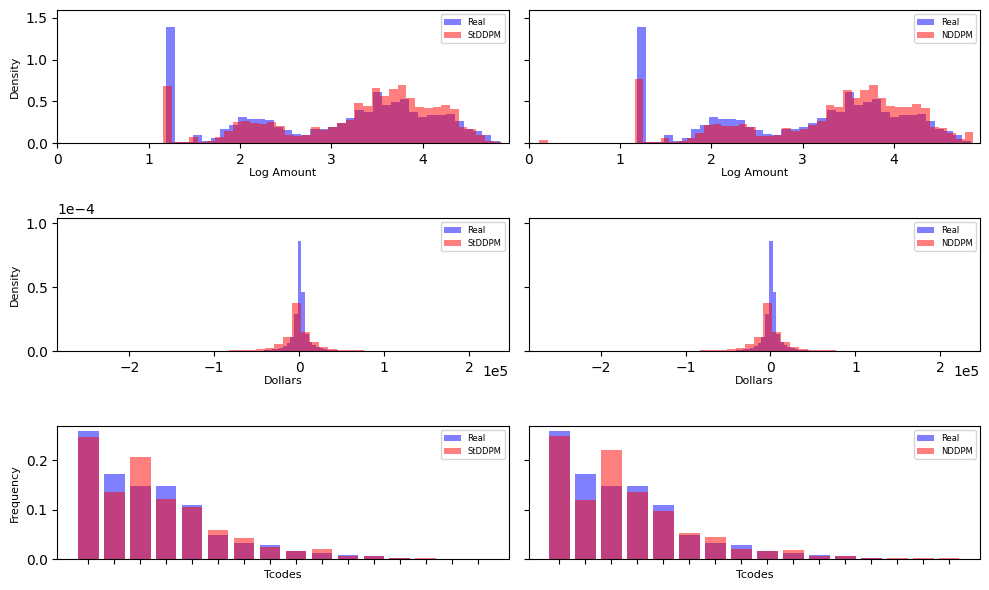

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(amt_real), np.min(amt_synthlstm), np.min(amt_synthbf))
x_max = max(np.max(amt_real), np.max(amt_synthlstm), np.max(amt_synthbf))

axes[0, 0].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(amt_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StDDPM')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper right', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(amt_synthbf, bins=50, alpha=0.5, color='red', density=True, label='NDDPM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper right', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)

# axes[0, 2].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[0, 2].hist(amt_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[0, 2].set_xlim(x_min, x_max)
# axes[0, 2].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
# axes[0, 2].legend(loc='upper right', fontsize=6)
# axes[0, 2].set_yticklabels([])

y_min = 0
y_max_amt = max([max_density_amt_real, max_density_amt_synthlstm, max_density_amt_synthbf])
axes[0, 0].set_ylim(y_min, y_max_amt + 0.2)
axes[0, 1].set_ylim(y_min, y_max_amt +0.2)
# axes[0, 2].set_ylim(y_min, y_max_amt +0.2)



#second row: cash flow
x_min2 = min(np.min(cf_real), np.min(cf_synthlstm), np.min(cf_synthbf))
x_max2 = max(np.max(cf_real), np.max(cf_synthlstm), np.max(cf_synthbf))

axes[1, 0].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 0].hist(cf_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StDDPM')
axes[1, 0].set_xlim(x_min2, x_max2)
axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[1, 0].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 0].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 0].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(loc='upper right', fontsize=6)


axes[1, 1].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 1].hist(cf_synthbf, bins=50, alpha=0.5, color='red', density=True, label='NDDPM')
axes[1, 1].set_xlim(x_min2, x_max2)
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 1].legend(loc='upper right', fontsize=6)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

# axes[1, 2].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[1, 2].hist(cf_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[1, 2].set_xlim(x_min2, x_max2)
# axes[1, 2].xaxis.set_major_formatter(x_formatter)
# axes[1, 2].yaxis.set_major_formatter(y_formatter)
# offset_text = axes[1, 2].xaxis.get_offset_text()
# offset_text.set_verticalalignment('bottom')
# offset_text.set_horizontalalignment('right')
# axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
# axes[1, 2].legend(loc='upper right', fontsize=6)
# axes[1, 2].set_yticklabels([])
# axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

y_min = 0
y_max_cf = max([max_density_cf_real, max_density_cf_synthlstm, max_density_cf_synthbf])

axes[1, 0].set_ylim(y_min, y_max_cf + 0.18e-4)
axes[1, 1].set_ylim(y_min, y_max_cf + 0.18e-4)
# axes[1, 2].set_ylim(y_min, y_max_cf + 0.18e-4)


#Third Row: Transaction codes
positions = np.arange(len(tcode_real))
#positions = list(tcode_rec_real.index)
axes[2, 0].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 0].bar(positions, tcode_synthlstm_norm, alpha=0.5, color='red', label='StDDPM')
axes[2, 0].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 0].set_ylabel('Frequency', fontsize=8)
axes[2, 0].set_xticks(positions)
axes[2, 0].set_xticklabels([''] * len(positions))
axes[2, 0].legend(loc='upper right', fontsize=6)

axes[2, 1].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 1].bar(positions, tcode_synthbf_norm, alpha=0.5, color='red', label='NDDPM')
axes[2, 1].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 1].set_xticks(positions)
axes[2, 1].set_xticklabels([''] * len(positions))
axes[2, 1].set_yticklabels([])
axes[2, 1].legend(loc='upper right', fontsize=6)


# axes[2, 2].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 2].bar(positions, tcode_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
# axes[2, 2].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
# axes[2, 2].set_xticks(positions)
# axes[2, 2].set_xticklabels([''] * len(positions))
# #axes[2, 2].set_xticklabels(positions, rotation=45, fontsize=6)
# axes[2, 2].set_yticklabels([])
# axes[2, 2].legend(loc='upper right', fontsize=6)


y_max_tcode = max([max(tcode_real_norm), max(tcode_synthbf_norm), max(tcode_synthlstm_norm)])
axes[2, 0].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 1].set_ylim(y_min, y_max_tcode + 0.01)
# axes[2, 2].set_ylim(y_min, y_max_tcode + 0.01)



# # Add a title for the first row
# fig.text(0.53, 1, 'Transaction Log Amount Distributions', ha='center', va='center', fontsize=10)
# # Add a title for the second row
# fig.text(0.53, 0.65, 'Monthly Cash Flow Distributions', ha='center', va='center', fontsize=10)
# # Add a title for the third row
# fig.text(0.53, 0.315, 'Tcode Distributions', ha='center', va='center', fontsize=10)
# Add a title for the fourth row
#fig.text(0.5, 0.24, 'Log Time Delta Distributions', ha='center', va='center', fontsize=10)

fig.subplots_adjust()
fig.tight_layout(h_pad=1.8)

## Comparison of models for non-recurring transactions

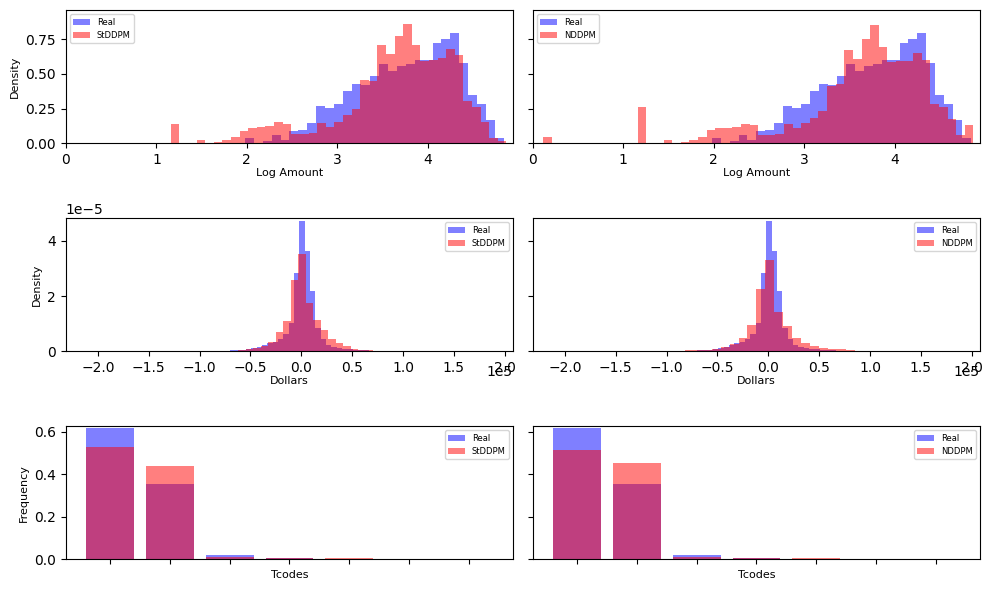

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(amt_norec_real), np.min(amt_norec_synthlstm), np.min(amt_norec_synthbf))
x_max = max(np.max(amt_norec_real), np.max(amt_norec_synthlstm), np.max(amt_norec_synthbf))

axes[0, 0].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(amt_norec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StDDPM')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper left', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(amt_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='NDDPM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper left', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)

# axes[0, 2].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[0, 2].hist(amt_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[0, 2].set_xlim(x_min, x_max)
# axes[0, 2].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
# axes[0, 2].legend(loc='upper left', fontsize=6)
# axes[0, 2].set_yticklabels([])

y_min = 0
y_max_amt_norec = max([max_density_amt_norec_real, max_density_amt_norec_synthlstm, max_density_amt_norec_synthbf])
axes[0, 0].set_ylim(y_min, y_max_amt_norec + 0.1)
axes[0, 1].set_ylim(y_min, y_max_amt_norec +0.1)
# axes[0, 2].set_ylim(y_min, y_max_amt_norec +0.1)



#second row: cash flow
x_min2 = min(np.min(cf_norec_real), np.min(cf_norec_synthlstm), np.min(cf_norec_synthbf))
x_max2 = max(np.max(cf_norec_real), np.max(cf_norec_synthlstm), np.max(cf_norec_synthbf))

axes[1, 0].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 0].hist(cf_norec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StDDPM')
axes[1, 0].set_xlim(x_min2, x_max2)
axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[1, 0].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 0].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 0].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(loc='upper right', fontsize=6)


axes[1, 1].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 1].hist(cf_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='NDDPM')
axes[1, 1].set_xlim(x_min2, x_max2)
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 1].legend(loc='upper right', fontsize=6)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

# axes[1, 2].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[1, 2].hist(cf_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[1, 2].set_xlim(x_min2, x_max2)
# axes[1, 2].xaxis.set_major_formatter(x_formatter)
# axes[1, 2].yaxis.set_major_formatter(y_formatter)
# offset_text = axes[1, 2].xaxis.get_offset_text()
# offset_text.set_verticalalignment('bottom')
# offset_text.set_horizontalalignment('right')
# axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
# axes[1, 2].legend(loc='upper right', fontsize=6)
# axes[1, 2].set_yticklabels([])
# axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

y_min = 0
y_max_cf_norec = max([max_density_cf_norec_real, max_density_cf_norec_synthlstm, max_density_cf_norec_synthbf])

axes[1, 0].set_ylim(y_min, y_max_cf_norec + 0.01e-4)
axes[1, 1].set_ylim(y_min, y_max_cf_norec + 0.01e-4)
# axes[1, 2].set_ylim(y_min, y_max_cf_norec + 0.01e-4)


#Third Row: Transaction codes
#positions = np.arange(len(tcode_norec_real))
positions = list(tcode_norec_real.index)
axes[2, 0].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 0].bar(positions, tcode_norec_synthlstm_norm, alpha=0.5, color='red', label='StDDPM')
axes[2, 0].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 0].set_ylabel('Frequency', fontsize=8)
axes[2, 0].set_xticks(positions)
#axes[2, 0].set_xticklabels(positions, rotation=45, fontsize=6)
axes[2, 0].set_xticklabels([''] * len(positions))
axes[2, 0].legend(loc='upper right', fontsize=6)

axes[2, 1].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 1].bar(positions, tcode_norec_synthbf_norm, alpha=0.5, color='red', label='NDDPM')
axes[2, 1].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 1].set_xticks(positions)
axes[2, 1].set_xticklabels([''] * len(positions))
axes[2, 1].set_yticklabels([])
axes[2, 1].legend(loc='upper right', fontsize=6)


# axes[2, 2].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 2].bar(positions, tcode_norec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
# axes[2, 2].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
# axes[2, 2].set_xticks(positions)
# axes[2, 2].set_xticklabels([''] * len(positions))
# axes[2, 2].set_yticklabels([])
# axes[2, 2].legend(loc='upper right', fontsize=6)

# axes[2, 0].set_xticklabels(positions, rotation=45, fontsize=6)
# axes[2, 1].set_xticklabels(positions, rotation=45, fontsize=6)
# axes[2, 2].set_xticklabels(positions, rotation=45, fontsize=6)

y_max_tcode = max([max(tcode_norec_real_norm), max(tcode_norec_synthbf_norm), max(tcode_norec_synthlstm_norm)])
axes[2, 0].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 1].set_ylim(y_min, y_max_tcode + 0.01)
# axes[2, 2].set_ylim(y_min, y_max_tcode + 0.01)




# Third Row: Day of Month
# positions = np.arange(len(day_rec_real))
# axes[2, 0].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 0].bar(positions, day_rec_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
# axes[2, 0].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 0].set_ylabel('Frequency', fontsize=8)
# axes[2, 0].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 0].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 0].legend(loc='upper right', fontsize=6)

# axes[2, 1].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 1].bar(positions, day_rec_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
# axes[2, 1].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 1].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 1].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 1].set_yticklabels([])
# axes[2, 1].legend(loc='upper right', fontsize=6)


# axes[2, 2].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 2].bar(positions, day_rec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
# axes[2, 2].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 2].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 2].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 2].set_yticklabels([])
# axes[2, 2].legend(loc='upper right', fontsize=6)


# y_max_day = max([max(day_rec_real_norm), max(day_rec_synthbf_norm), max(day_rec_synthlstm_norm), max(day_rec_synthgan_norm)])
# axes[2, 0].set_ylim(y_min, y_max_day)
# axes[2, 1].set_ylim(y_min, y_max_day)
# axes[2, 2].set_ylim(y_min, y_max_day)

# x_min3 = min(np.min(td_rec_real), np.min(td_rec_synthgan), np.min(td_rec_synthlstm), np.min(td_rec_synthbf))
# x_max3 = max(np.max(td_rec_real), np.max(td_rec_synthgan), np.max(td_rec_synthlstm), np.max(td_rec_synthbf))

# axes[3, 0].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 0].hist(td_rec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
# axes[3, 0].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 0].legend(loc='upper right', fontsize=6)
# axes[3, 0].set_ylabel('Density', fontsize=8)
# axes[3, 0].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)


# axes[3, 1].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 1].hist(td_rec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
# axes[3, 1].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 1].legend(loc='upper right', fontsize=6)
# axes[3, 1].set_yticklabels([])
# axes[3, 1].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)

# axes[3, 2].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 2].hist(td_rec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[3, 2].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 2].legend(loc='upper right', fontsize=6)
# axes[3, 2].set_yticklabels([])
# axes[3, 2].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)



# Add a title for the first row
# fig.text(0.53, 1, 'Transaction Log Amount Distributions', ha='center', va='center', fontsize=10)
# # Add a title for the second row
# fig.text(0.53, 0.65, 'Monthly Cash Flow Distributions', ha='center', va='center', fontsize=10)
# # Add a title for the third row
# fig.text(0.53, 0.315, 'Tcode Distributions', ha='center', va='center', fontsize=10)
# Add a title for the fourth row
#fig.text(0.5, 0.24, 'Log Time Delta Distributions', ha='center', va='center', fontsize=10)

fig.subplots_adjust()
fig.tight_layout(h_pad=1.8)

In [42]:
real_sorted.columns

Index(['account_id', 'tcode', 'datetime', 'amount', 'raw_amount', 'month',
       'day', 'dow', 'year', 'td', 'type', 'dtme'],
      dtype='object')

In [22]:
real_sorted02=real_sorted[['tcode', 'amount', 'raw_amount', 'month',
       'day', 'dow', 'year', 'td']]

synth_sorted02=synth_sorted[['tcode', 'amount', 'raw_amount', 'month',
       'day', 'dow', 'year', 'td']]


synth_sorted_NDDPM02=synth_sorted_NDDPM[['tcode', 'amount', 'raw_amount', 'month',
       'day', 'dow', 'year', 'td']]


In [18]:
# # import numpy as np
# # from sklearn.metrics import pairwise_distances
# # from sklearn.preprocessing import StandardScaler

# # def compute_dcr(real_data, synthetic_data, distance_metric='euclidean'):
# #     """
# #     Compute the Distance to Closest Record (DCR) between synthetic and real datasets.

# #     Args:
# #         real_data (pd.DataFrame or np.ndarray): Real dataset.
# #         synthetic_data (pd.DataFrame or np.ndarray): Synthetic dataset.
# #         distance_metric (str): Distance metric to use (default='euclidean').

# #     Returns:
# #         float: Median DCR value (higher = more private).
# #     """
# #     # Convert to numpy and scale both datasets
# #     scaler = StandardScaler()
# #     real_scaled = scaler.fit_transform(real_data)
# #     synth_scaled = scaler.transform(synthetic_data)

# #     # Compute pairwise distances (synthetic → real)
# #     distances = pairwise_distances(synth_scaled, real_scaled, metric=distance_metric)

# #     # For each synthetic record, find the minimum distance to any real record
# #     dcr_values = distances.min(axis=1)

# #     # Return the median DCR as the final score
# #     return np.median(dcr_values)


# # compute_dcr(real_sorted, synth_sorted, distance_metric='euclidean')


# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import pairwise_distances
# import numpy as np
# import pandas as pd

# def label_encode_dataframe(df, categorical_cols):
#     """
#     Label encodes the specified categorical columns in the dataframe.
#     """
#     df_encoded = df.copy()
#     for col in categorical_cols:
#         le = LabelEncoder()
#         df_encoded[col] = le.fit_transform(df[col].astype(str))
#     return df_encoded

# def compute_dcr_label_encoded(real_data, synthetic_data, categorical_cols, distance_metric='euclidean'):
#     """
#     Compute DCR with label encoding on categorical columns.
#     """
#     # Encode categorical columns
#     real_encoded = label_encode_dataframe(real_data, categorical_cols)
#     synth_encoded = label_encode_dataframe(synthetic_data, categorical_cols)

#     # Scale all features
#     scaler = StandardScaler()
#     real_scaled = scaler.fit_transform(real_encoded)
#     synth_scaled = scaler.transform(synth_encoded)

#     # Compute pairwise distances
#     distances = pairwise_distances(synth_scaled, real_scaled, metric=distance_metric)
#     dcr_values = distances.min(axis=1)

#     return np.median(dcr_values)


# categorical_cols = ['tcode']  # Replace with your actual column
# dcr_score = compute_dcr_label_encoded(real_sorted02, synth_sorted02, categorical_cols)
# print(f"DCR (Label Encoded): {dcr_score:.4f}")


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

def label_encode_dataframe(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
    return df_encoded

def compute_dcr_label_encoded_batch(real_data, synthetic_data, categorical_cols, distance_metric='euclidean', batch_size=1000):
    """
    Compute DCR with batching to avoid memory overload.
    """
    # Encode categorical columns
    real_encoded = label_encode_dataframe(real_data, categorical_cols)
    synth_encoded = label_encode_dataframe(synthetic_data, categorical_cols)

    # Scale all features
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_encoded)
    synth_scaled = scaler.transform(synth_encoded)

    min_distances = []

    for i in range(0, synth_scaled.shape[0], batch_size):
        synth_batch = synth_scaled[i:i+batch_size]
        dists = pairwise_distances(synth_batch, real_scaled, metric=distance_metric)
        min_dists = np.min(dists, axis=1)
        min_distances.extend(min_dists)

    return np.median(min_distances)


categorical_cols = ['tcode']
dcr_score = compute_dcr_label_encoded_batch(real_sorted02, synth_sorted02, categorical_cols, batch_size=500)
print(f"DCR (Label Encoded, Batched): {dcr_score:.4f}")




KeyboardInterrupt: 

In [17]:
# from sdmetrics.single_table import DCRBaselineProtection

# score = DCRBaselineProtection.compute_breakdown(
#     real_data=real_sorted02,
#     synthetic_data=synth_sorted02,
#     metadata={
#         "fields": {
#             "amount": {"type": "numerical"},
#             "raw_amount": {"type": "numerical"},
#             "tcode": {"type": "categorical"},
#             "day": {"type": "numerical"}  # Replace with your actual columns
#         }
#     }
# )

# print(score)

metadata = {
    "columns": {
        "amount": {"sdtype": "numerical"},
        "raw_amount": {"sdtype": "numerical"},
        "tcode": {"sdtype": "categorical"},
        "day": {"sdtype": "numerical"}  # or "datetime" if it's a timestamp
    }
}


from sdmetrics.single_table import DCRBaselineProtection

score = DCRBaselineProtection.compute(
    real_data=real_sorted02,
    synthetic_data=synth_sorted02,
    metadata=metadata
)
print("Overall DCR score:", score)




/usr/local/lib/python3.11/dist-packages/sdmetrics/_utils_metadata.py:115: UserWarning: The columns ('dow', 'month', 'td', 'year') are not present in the metadata. They will not be included for further evaluation.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sdmetrics/_utils_metadata.py:115: UserWarning: The columns ('dow', 'month', 'td', 'year') are not present in the metadata. They will not be included for further evaluation.
  warnings.warn(


KeyboardInterrupt: 

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def label_encode_dataframe(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
    return df_encoded

def compute_nndr(real_data, synthetic_data, categorical_cols=None, k=5):

    if categorical_cols is None:
        categorical_cols = []

    # Encode categorical columns
    real_enc = label_encode_dataframe(real_data, categorical_cols)
    synth_enc = label_encode_dataframe(synthetic_data, categorical_cols)

    # Scale everything
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_enc)
    synth_scaled = scaler.transform(synth_enc)

    # Step 1: Distance from each synthetic point to nearest real point
    nn_real = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(real_scaled)
    distances_to_real_nn, _ = nn_real.kneighbors(synth_scaled, return_distance=True)
    distances_to_real_nn = distances_to_real_nn.flatten()  # numerator

    # Step 2: For each real point, average distance to its k nearest neighbors
    nn_k_real = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(real_scaled)
    distances_among_real, _ = nn_k_real.kneighbors(real_scaled)
    # Exclude the first column (distance to self = 0)
    avg_real_nn_dists = distances_among_real[:, 1:].mean(axis=1)
    avg_distance_among_real = avg_real_nn_dists.mean()  # denominator

    # Step 3: Compute NNDR for each synthetic record
    nndr_values = distances_to_real_nn / avg_distance_among_real

    return np.median(nndr_values)


categorical_cols = ['tcode']  # Add other categorical fields as needed
nndr_score = compute_nndr(real_sorted02, synth_sorted_NDDPM02, categorical_cols, k=5)
print(f"NNDR Score (median): {nndr_score:.4f}")


NNDR Score (median): 1.6646
